In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer

from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
df.shape

(300000, 26)

In [4]:
df.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,N,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,O,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,F,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,K,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,N,1.058291,0.367492,-0.052389,0.232407,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
import seaborn as sns

<AxesSubplot:xlabel='cont8'>

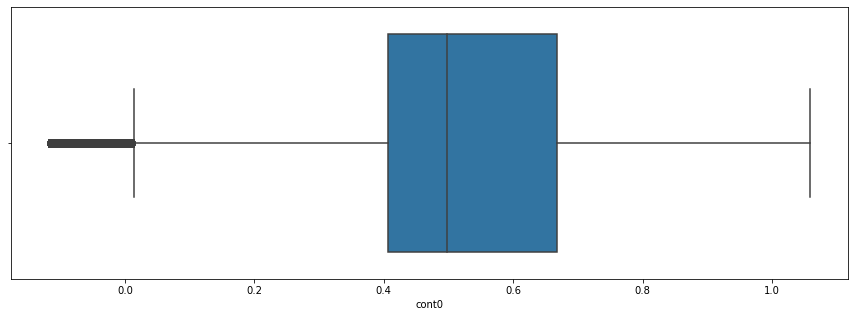

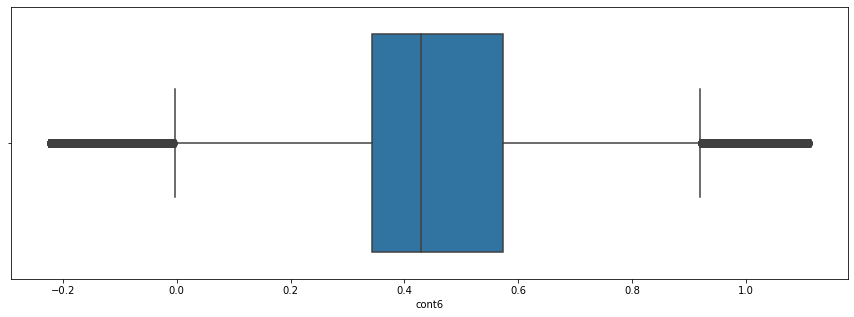

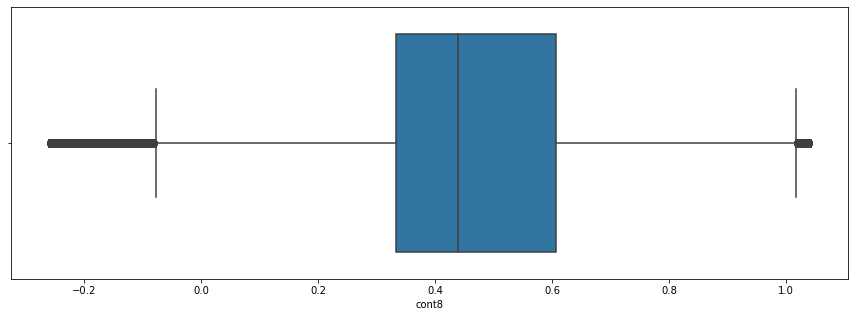

In [6]:
figuresizes = (15,5)
plt.figure(figsize=figuresizes)
sns.boxplot(x='cont0', data=df)

plt.figure(figsize=figuresizes)
sns.boxplot(x='cont6', data=df)

plt.figure(figsize=figuresizes)
sns.boxplot(x='cont8', data=df)

In [7]:
# cont0:
 
# IQR:    
IQR0 = 0.6680601239204407 - 0.4059654474258423

# Upper bound
upper0 = (0.6680601239204407+1.5*IQR0)
# Lower bound
lower0 = (0.4059654474258423-1.5*IQR0)

In [8]:
print(f'{np.sum(df["cont0"] > upper0)}, {np.sum(df["cont0"] < lower0)}')

0, 4480


In [10]:
from scipy.stats import zscore

In [11]:
# calculates z-score values
df["zscore_0"] = zscore(df["cont0"]) 

# creates `is_outlier` column with either True or False values, 
# so that you could filter your dataframe accordingly
df["is_outlier_0"] = df["zscore_0"].apply(lambda x: x <= -1.96 or x >= 1.96)

In [12]:
df = df[~df['is_outlier_0']]

In [13]:
print(f'{np.sum(df["cont0"] > upper0)}, {np.sum(df["cont0"] < lower0)}')

0, 0


In [14]:
# cont6:
 
# IQR:
IQR6 = 0.5733827650547028 - 0.34287314862012863
 
# Upper bound
upper6 = (0.5733827650547028+1.5*IQR6)
# Lower bound
lower6 = (0.34287314862012863-1.5*IQR6)

In [15]:
print(f'{np.sum(df["cont6"] > upper6)}, {np.sum(df["cont6"] < lower6)}')

11767, 3533


In [16]:
df["zscore_6"] = zscore(df["cont6"]) 

# creates `is_outlier` column with either True or False values, 
# so that you could filter your dataframe accordingly
df["is_outlier_6"] = df["zscore_6"].apply(lambda x: x <= -1.96 or x >= 1.96)

In [17]:
df = df[~df['is_outlier_6']]

In [18]:
print(f'{np.sum(df["cont6"] > upper6)}, {np.sum(df["cont6"] < lower6)}')

0, 0


In [19]:
# cont8:
 
# IQR:    
IQR8 = 0.6060555577278137 - 0.33248579502105713

# Upper bound
upper8 = (0.6060555577278137+1.5*IQR8)
# Lower bound
lower8 = (0.33248579502105713-1.5*IQR8)

In [20]:
print(f'{np.sum(df["cont8"] > upper8)}, {np.sum(df["cont8"] < lower8)}')

7861, 2637


In [21]:
df["zscore_8"] = zscore(df["cont8"]) 

# creates `is_outlier` column with either True or False values, 
# so that you could filter your dataframe accordingly
df["is_outlier_8"] = df["zscore_8"].apply(lambda x: x <= -1.96 or x >= 1.96)

In [22]:
df = df[~df['is_outlier_8']]

In [23]:
print(f'{np.sum(df["cont8"] > upper8)}, {np.sum(df["cont8"] < lower8)}')

0, 0


In [24]:
df.shape

(235707, 32)

In [25]:
del df['id']

test_data = test.copy()
del test['id']

In [27]:
df = df.drop(['zscore_0','is_outlier_0', 'zscore_6', 'is_outlier_6', 'zscore_8', 'is_outlier_8'], axis=1)

In [28]:
df.shape, test.shape

((235707, 25), (200000, 24))

### Simple Preprocessing

In [29]:
# Ordinal Encoding

object_cols = df.columns[:3].tolist()

ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])
test[object_cols] = ordinal_encoder.transform(test[object_cols])

df[object_cols] = df[object_cols].astype('int64')
test[object_cols] = test[object_cols].astype('int64')

In [30]:
# One Hot Encoding

not_so_hot_columns = df.columns[3:10].tolist()

df = pd.get_dummies(data = df, columns = not_so_hot_columns)
test = pd.get_dummies(data = test, columns = not_so_hot_columns)

In [31]:
df.head()

,cat0,cat1,cat2,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target,cat3_A,cat3_B,cat3_C,cat3_D,cat4_A,cat4_B,cat4_C,cat4_D,cat5_A,cat5_B,cat5_C,cat5_D,cat6_A,cat6_B,cat6_C,cat6_D,cat6_E,cat6_G,cat6_H,cat6_I,cat7_A,cat7_B,cat7_C,cat7_D,cat7_E,cat7_F,cat7_G,cat7_I,cat8_A,cat8_B,cat8_C,cat8_D,cat8_E,cat8_F,cat8_G,cat9_A,cat9_B,cat9_C,cat9_D,cat9_E,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
0,1,1,1,0.201470,-0.014822,0.669699,0.136278,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,1,0,0.743068,0.367411,1.021605,0.365798,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0.742708,0.310383,-0.012673,0.576957,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,1,0,0.429551,0.620998,0.577942,0.280610,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,1,0,0.402056,0.837058,0.737991,0.778429,0.530250,0.392432,0.658169,0.997473,0.569874,0.960864,0.238050,0.316065,0.731729,0.694719,8.028558,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Model

In [32]:
y = df['target']
X = df.loc[:, df.columns != 'target']

In [33]:
scaler = MinMaxScaler()
scaler.fit(X)

test = scaler.transform(test)

In [34]:
lgbm_parameters = {
    'metric': 'rmse', 
    'n_jobs': -1,
    'n_estimators': 50000,
    'reg_alpha': 10.924491968127692,
    'reg_lambda': 17.396730654687218,
    'colsample_bytree': 0.21497646795452627,
    'subsample': 0.7582562557431147,
    'learning_rate': 0.009985133666265425,
    'max_depth': 18,
    'num_leaves': 63,
    'min_child_samples': 27,
    'max_bin': 523,
    'cat_l2': 0.025083670064082797
}

In [35]:
score_r2 = []
score_rmse = []
pred_list = []
fold = KFold(n_splits = 8, shuffle = True, random_state = 42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = LGBMRegressor(**lgbm_parameters, random_state = 32)
    model.fit(X_train, y_train, eval_set = ((X_test, y_test)), early_stopping_rounds = 400)
    
    y_pred = model.predict(X_test)
    print('Root_mean_squared_error:', np.sqrt(mean_squared_error(y_pred, y_test)), '\n')
    
    score_rmse.append(np.sqrt(mean_squared_error(y_pred, y_test)))
    
    predict = model.predict(test)
    pred_list.append(predict)

[1]	valid_0's rmse: 0.74423
Training until validation scores don't improve for 400 rounds
[2]	valid_0's rmse: 0.744125
[3]	valid_0's rmse: 0.744054
[4]	valid_0's rmse: 0.743946
[5]	valid_0's rmse: 0.743913
[6]	valid_0's rmse: 0.743892
[7]	valid_0's rmse: 0.743832
[8]	valid_0's rmse: 0.743718
[9]	valid_0's rmse: 0.743628
[10]	valid_0's rmse: 0.743577
[11]	valid_0's rmse: 0.743515
[12]	valid_0's rmse: 0.743464
[13]	valid_0's rmse: 0.743441
[14]	valid_0's rmse: 0.743382
[15]	valid_0's rmse: 0.743274
[16]	valid_0's rmse: 0.743168
[17]	valid_0's rmse: 0.743074
[18]	valid_0's rmse: 0.742988
[19]	valid_0's rmse: 0.742913
[20]	valid_0's rmse: 0.742859
[21]	valid_0's rmse: 0.742781
[22]	valid_0's rmse: 0.742673
[23]	valid_0's rmse: 0.742604
[24]	valid_0's rmse: 0.742498
[25]	valid_0's rmse: 0.742463
[26]	valid_0's rmse: 0.742355
[27]	valid_0's rmse: 0.742286
[28]	valid_0's rmse: 0.742189
[29]	valid_0's rmse: 0.742075
[30]	valid_0's rmse: 0.741935
[31]	valid_0's rmse: 0.741868
[32]	valid_0's rms

[273]	valid_0's rmse: 0.730695
[274]	valid_0's rmse: 0.730649
[275]	valid_0's rmse: 0.730632
[276]	valid_0's rmse: 0.7306
[277]	valid_0's rmse: 0.730584
[278]	valid_0's rmse: 0.730533
[279]	valid_0's rmse: 0.730525
[280]	valid_0's rmse: 0.730508
[281]	valid_0's rmse: 0.730462
[282]	valid_0's rmse: 0.73043
[283]	valid_0's rmse: 0.730424
[284]	valid_0's rmse: 0.730369
[285]	valid_0's rmse: 0.730356
[286]	valid_0's rmse: 0.730307
[287]	valid_0's rmse: 0.730274
[288]	valid_0's rmse: 0.730233
[289]	valid_0's rmse: 0.730207
[290]	valid_0's rmse: 0.73019
[291]	valid_0's rmse: 0.730154
[292]	valid_0's rmse: 0.730111
[293]	valid_0's rmse: 0.73008
[294]	valid_0's rmse: 0.730027
[295]	valid_0's rmse: 0.729993
[296]	valid_0's rmse: 0.729979
[297]	valid_0's rmse: 0.72996
[298]	valid_0's rmse: 0.729954
[299]	valid_0's rmse: 0.729915
[300]	valid_0's rmse: 0.729881
[301]	valid_0's rmse: 0.729867
[302]	valid_0's rmse: 0.729824
[303]	valid_0's rmse: 0.729792
[304]	valid_0's rmse: 0.729755
[305]	valid_0'

[542]	valid_0's rmse: 0.724701
[543]	valid_0's rmse: 0.724689
[544]	valid_0's rmse: 0.724674
[545]	valid_0's rmse: 0.724656
[546]	valid_0's rmse: 0.724643
[547]	valid_0's rmse: 0.724628
[548]	valid_0's rmse: 0.724613
[549]	valid_0's rmse: 0.724594
[550]	valid_0's rmse: 0.724581
[551]	valid_0's rmse: 0.724562
[552]	valid_0's rmse: 0.724545
[553]	valid_0's rmse: 0.72453
[554]	valid_0's rmse: 0.724514
[555]	valid_0's rmse: 0.724494
[556]	valid_0's rmse: 0.724492
[557]	valid_0's rmse: 0.724482
[558]	valid_0's rmse: 0.724466
[559]	valid_0's rmse: 0.72445
[560]	valid_0's rmse: 0.724438
[561]	valid_0's rmse: 0.724421
[562]	valid_0's rmse: 0.724409
[563]	valid_0's rmse: 0.72439
[564]	valid_0's rmse: 0.724364
[565]	valid_0's rmse: 0.724354
[566]	valid_0's rmse: 0.724331
[567]	valid_0's rmse: 0.724314
[568]	valid_0's rmse: 0.724295
[569]	valid_0's rmse: 0.724276
[570]	valid_0's rmse: 0.724251
[571]	valid_0's rmse: 0.72423
[572]	valid_0's rmse: 0.724221
[573]	valid_0's rmse: 0.724204
[574]	valid_

[809]	valid_0's rmse: 0.721456
[810]	valid_0's rmse: 0.721448
[811]	valid_0's rmse: 0.721438
[812]	valid_0's rmse: 0.721434
[813]	valid_0's rmse: 0.721424
[814]	valid_0's rmse: 0.721409
[815]	valid_0's rmse: 0.721397
[816]	valid_0's rmse: 0.721391
[817]	valid_0's rmse: 0.721381
[818]	valid_0's rmse: 0.721368
[819]	valid_0's rmse: 0.721358
[820]	valid_0's rmse: 0.721343
[821]	valid_0's rmse: 0.721335
[822]	valid_0's rmse: 0.721334
[823]	valid_0's rmse: 0.721324
[824]	valid_0's rmse: 0.72132
[825]	valid_0's rmse: 0.72131
[826]	valid_0's rmse: 0.721296
[827]	valid_0's rmse: 0.721295
[828]	valid_0's rmse: 0.721283
[829]	valid_0's rmse: 0.721275
[830]	valid_0's rmse: 0.721261
[831]	valid_0's rmse: 0.721254
[832]	valid_0's rmse: 0.721252
[833]	valid_0's rmse: 0.721242
[834]	valid_0's rmse: 0.721231
[835]	valid_0's rmse: 0.721226
[836]	valid_0's rmse: 0.72122
[837]	valid_0's rmse: 0.721212
[838]	valid_0's rmse: 0.721202
[839]	valid_0's rmse: 0.721191
[840]	valid_0's rmse: 0.721185
[841]	valid

[1089]	valid_0's rmse: 0.719529
[1090]	valid_0's rmse: 0.719526
[1091]	valid_0's rmse: 0.719526
[1092]	valid_0's rmse: 0.719524
[1093]	valid_0's rmse: 0.719514
[1094]	valid_0's rmse: 0.719503
[1095]	valid_0's rmse: 0.719497
[1096]	valid_0's rmse: 0.719493
[1097]	valid_0's rmse: 0.719488
[1098]	valid_0's rmse: 0.719487
[1099]	valid_0's rmse: 0.719483
[1100]	valid_0's rmse: 0.719479
[1101]	valid_0's rmse: 0.719473
[1102]	valid_0's rmse: 0.719467
[1103]	valid_0's rmse: 0.71946
[1104]	valid_0's rmse: 0.719459
[1105]	valid_0's rmse: 0.719455
[1106]	valid_0's rmse: 0.71945
[1107]	valid_0's rmse: 0.71945
[1108]	valid_0's rmse: 0.719442
[1109]	valid_0's rmse: 0.719435
[1110]	valid_0's rmse: 0.719424
[1111]	valid_0's rmse: 0.719415
[1112]	valid_0's rmse: 0.719407
[1113]	valid_0's rmse: 0.719406
[1114]	valid_0's rmse: 0.7194
[1115]	valid_0's rmse: 0.719388
[1116]	valid_0's rmse: 0.719382
[1117]	valid_0's rmse: 0.719377
[1118]	valid_0's rmse: 0.719363
[1119]	valid_0's rmse: 0.719354
[1120]	valid_

[1355]	valid_0's rmse: 0.718348
[1356]	valid_0's rmse: 0.718344
[1357]	valid_0's rmse: 0.718338
[1358]	valid_0's rmse: 0.718338
[1359]	valid_0's rmse: 0.718336
[1360]	valid_0's rmse: 0.718331
[1361]	valid_0's rmse: 0.718327
[1362]	valid_0's rmse: 0.718323
[1363]	valid_0's rmse: 0.718323
[1364]	valid_0's rmse: 0.718322
[1365]	valid_0's rmse: 0.718317
[1366]	valid_0's rmse: 0.718309
[1367]	valid_0's rmse: 0.718307
[1368]	valid_0's rmse: 0.718304
[1369]	valid_0's rmse: 0.718303
[1370]	valid_0's rmse: 0.718297
[1371]	valid_0's rmse: 0.718296
[1372]	valid_0's rmse: 0.71829
[1373]	valid_0's rmse: 0.718288
[1374]	valid_0's rmse: 0.718284
[1375]	valid_0's rmse: 0.71828
[1376]	valid_0's rmse: 0.718274
[1377]	valid_0's rmse: 0.718267
[1378]	valid_0's rmse: 0.718266
[1379]	valid_0's rmse: 0.718262
[1380]	valid_0's rmse: 0.718256
[1381]	valid_0's rmse: 0.718252
[1382]	valid_0's rmse: 0.718249
[1383]	valid_0's rmse: 0.718245
[1384]	valid_0's rmse: 0.718243
[1385]	valid_0's rmse: 0.718239
[1386]	val

[1615]	valid_0's rmse: 0.717588
[1616]	valid_0's rmse: 0.717588
[1617]	valid_0's rmse: 0.717582
[1618]	valid_0's rmse: 0.717579
[1619]	valid_0's rmse: 0.717578
[1620]	valid_0's rmse: 0.717577
[1621]	valid_0's rmse: 0.717577
[1622]	valid_0's rmse: 0.717577
[1623]	valid_0's rmse: 0.717572
[1624]	valid_0's rmse: 0.717569
[1625]	valid_0's rmse: 0.717567
[1626]	valid_0's rmse: 0.717563
[1627]	valid_0's rmse: 0.717561
[1628]	valid_0's rmse: 0.717559
[1629]	valid_0's rmse: 0.717554
[1630]	valid_0's rmse: 0.717552
[1631]	valid_0's rmse: 0.717552
[1632]	valid_0's rmse: 0.717551
[1633]	valid_0's rmse: 0.717548
[1634]	valid_0's rmse: 0.717545
[1635]	valid_0's rmse: 0.717543
[1636]	valid_0's rmse: 0.717542
[1637]	valid_0's rmse: 0.71754
[1638]	valid_0's rmse: 0.717537
[1639]	valid_0's rmse: 0.717535
[1640]	valid_0's rmse: 0.71753
[1641]	valid_0's rmse: 0.717528
[1642]	valid_0's rmse: 0.717525
[1643]	valid_0's rmse: 0.717522
[1644]	valid_0's rmse: 0.717524
[1645]	valid_0's rmse: 0.717522
[1646]	val

[1876]	valid_0's rmse: 0.717069
[1877]	valid_0's rmse: 0.717069
[1878]	valid_0's rmse: 0.717067
[1879]	valid_0's rmse: 0.717065
[1880]	valid_0's rmse: 0.717063
[1881]	valid_0's rmse: 0.717061
[1882]	valid_0's rmse: 0.717061
[1883]	valid_0's rmse: 0.717061
[1884]	valid_0's rmse: 0.71706
[1885]	valid_0's rmse: 0.717059
[1886]	valid_0's rmse: 0.717056
[1887]	valid_0's rmse: 0.717055
[1888]	valid_0's rmse: 0.717053
[1889]	valid_0's rmse: 0.717052
[1890]	valid_0's rmse: 0.717051
[1891]	valid_0's rmse: 0.71705
[1892]	valid_0's rmse: 0.717052
[1893]	valid_0's rmse: 0.71705
[1894]	valid_0's rmse: 0.717047
[1895]	valid_0's rmse: 0.717046
[1896]	valid_0's rmse: 0.717044
[1897]	valid_0's rmse: 0.717045
[1898]	valid_0's rmse: 0.717044
[1899]	valid_0's rmse: 0.717043
[1900]	valid_0's rmse: 0.717045
[1901]	valid_0's rmse: 0.717043
[1902]	valid_0's rmse: 0.717042
[1903]	valid_0's rmse: 0.717041
[1904]	valid_0's rmse: 0.717042
[1905]	valid_0's rmse: 0.717042
[1906]	valid_0's rmse: 0.717039
[1907]	vali

[2142]	valid_0's rmse: 0.716821
[2143]	valid_0's rmse: 0.716819
[2144]	valid_0's rmse: 0.716817
[2145]	valid_0's rmse: 0.716817
[2146]	valid_0's rmse: 0.716818
[2147]	valid_0's rmse: 0.716819
[2148]	valid_0's rmse: 0.716818
[2149]	valid_0's rmse: 0.716818
[2150]	valid_0's rmse: 0.716817
[2151]	valid_0's rmse: 0.716817
[2152]	valid_0's rmse: 0.716817
[2153]	valid_0's rmse: 0.716816
[2154]	valid_0's rmse: 0.716815
[2155]	valid_0's rmse: 0.716815
[2156]	valid_0's rmse: 0.716811
[2157]	valid_0's rmse: 0.716811
[2158]	valid_0's rmse: 0.716811
[2159]	valid_0's rmse: 0.71681
[2160]	valid_0's rmse: 0.71681
[2161]	valid_0's rmse: 0.716808
[2162]	valid_0's rmse: 0.716808
[2163]	valid_0's rmse: 0.71681
[2164]	valid_0's rmse: 0.716808
[2165]	valid_0's rmse: 0.716809
[2166]	valid_0's rmse: 0.716807
[2167]	valid_0's rmse: 0.716807
[2168]	valid_0's rmse: 0.716808
[2169]	valid_0's rmse: 0.716804
[2170]	valid_0's rmse: 0.716804
[2171]	valid_0's rmse: 0.716803
[2172]	valid_0's rmse: 0.716801
[2173]	vali

[2407]	valid_0's rmse: 0.716621
[2408]	valid_0's rmse: 0.716622
[2409]	valid_0's rmse: 0.716619
[2410]	valid_0's rmse: 0.716617
[2411]	valid_0's rmse: 0.716615
[2412]	valid_0's rmse: 0.716615
[2413]	valid_0's rmse: 0.716613
[2414]	valid_0's rmse: 0.716613
[2415]	valid_0's rmse: 0.716613
[2416]	valid_0's rmse: 0.716613
[2417]	valid_0's rmse: 0.716613
[2418]	valid_0's rmse: 0.716614
[2419]	valid_0's rmse: 0.716611
[2420]	valid_0's rmse: 0.71661
[2421]	valid_0's rmse: 0.716607
[2422]	valid_0's rmse: 0.716606
[2423]	valid_0's rmse: 0.716603
[2424]	valid_0's rmse: 0.716604
[2425]	valid_0's rmse: 0.716602
[2426]	valid_0's rmse: 0.716602
[2427]	valid_0's rmse: 0.7166
[2428]	valid_0's rmse: 0.716597
[2429]	valid_0's rmse: 0.716594
[2430]	valid_0's rmse: 0.716594
[2431]	valid_0's rmse: 0.716595
[2432]	valid_0's rmse: 0.716595
[2433]	valid_0's rmse: 0.716592
[2434]	valid_0's rmse: 0.716594
[2435]	valid_0's rmse: 0.716595
[2436]	valid_0's rmse: 0.716595
[2437]	valid_0's rmse: 0.716595
[2438]	vali

[2674]	valid_0's rmse: 0.716509
[2675]	valid_0's rmse: 0.716508
[2676]	valid_0's rmse: 0.716509
[2677]	valid_0's rmse: 0.716509
[2678]	valid_0's rmse: 0.71651
[2679]	valid_0's rmse: 0.716509
[2680]	valid_0's rmse: 0.71651
[2681]	valid_0's rmse: 0.716511
[2682]	valid_0's rmse: 0.716511
[2683]	valid_0's rmse: 0.716513
[2684]	valid_0's rmse: 0.716512
[2685]	valid_0's rmse: 0.716512
[2686]	valid_0's rmse: 0.716512
[2687]	valid_0's rmse: 0.716513
[2688]	valid_0's rmse: 0.716513
[2689]	valid_0's rmse: 0.716511
[2690]	valid_0's rmse: 0.716509
[2691]	valid_0's rmse: 0.716511
[2692]	valid_0's rmse: 0.71651
[2693]	valid_0's rmse: 0.716509
[2694]	valid_0's rmse: 0.716506
[2695]	valid_0's rmse: 0.716505
[2696]	valid_0's rmse: 0.716505
[2697]	valid_0's rmse: 0.716504
[2698]	valid_0's rmse: 0.716503
[2699]	valid_0's rmse: 0.716504
[2700]	valid_0's rmse: 0.716502
[2701]	valid_0's rmse: 0.7165
[2702]	valid_0's rmse: 0.7165
[2703]	valid_0's rmse: 0.716499
[2704]	valid_0's rmse: 0.7165
[2705]	valid_0's 

[2938]	valid_0's rmse: 0.71645
[2939]	valid_0's rmse: 0.71645
[2940]	valid_0's rmse: 0.716449
[2941]	valid_0's rmse: 0.716448
[2942]	valid_0's rmse: 0.716448
[2943]	valid_0's rmse: 0.716448
[2944]	valid_0's rmse: 0.716448
[2945]	valid_0's rmse: 0.716445
[2946]	valid_0's rmse: 0.716444
[2947]	valid_0's rmse: 0.716444
[2948]	valid_0's rmse: 0.716443
[2949]	valid_0's rmse: 0.716444
[2950]	valid_0's rmse: 0.716442
[2951]	valid_0's rmse: 0.716442
[2952]	valid_0's rmse: 0.716441
[2953]	valid_0's rmse: 0.716441
[2954]	valid_0's rmse: 0.716442
[2955]	valid_0's rmse: 0.716443
[2956]	valid_0's rmse: 0.716443
[2957]	valid_0's rmse: 0.716444
[2958]	valid_0's rmse: 0.716445
[2959]	valid_0's rmse: 0.716443
[2960]	valid_0's rmse: 0.716443
[2961]	valid_0's rmse: 0.716442
[2962]	valid_0's rmse: 0.716443
[2963]	valid_0's rmse: 0.716442
[2964]	valid_0's rmse: 0.716443
[2965]	valid_0's rmse: 0.716443
[2966]	valid_0's rmse: 0.716443
[2967]	valid_0's rmse: 0.716442
[2968]	valid_0's rmse: 0.716442
[2969]	val

[3196]	valid_0's rmse: 0.716379
[3197]	valid_0's rmse: 0.716379
[3198]	valid_0's rmse: 0.71638
[3199]	valid_0's rmse: 0.71638
[3200]	valid_0's rmse: 0.716381
[3201]	valid_0's rmse: 0.716378
[3202]	valid_0's rmse: 0.716378
[3203]	valid_0's rmse: 0.716375
[3204]	valid_0's rmse: 0.716374
[3205]	valid_0's rmse: 0.716374
[3206]	valid_0's rmse: 0.716373
[3207]	valid_0's rmse: 0.716373
[3208]	valid_0's rmse: 0.716373
[3209]	valid_0's rmse: 0.716375
[3210]	valid_0's rmse: 0.716376
[3211]	valid_0's rmse: 0.716376
[3212]	valid_0's rmse: 0.716377
[3213]	valid_0's rmse: 0.716377
[3214]	valid_0's rmse: 0.716377
[3215]	valid_0's rmse: 0.716376
[3216]	valid_0's rmse: 0.716376
[3217]	valid_0's rmse: 0.716375
[3218]	valid_0's rmse: 0.716375
[3219]	valid_0's rmse: 0.716377
[3220]	valid_0's rmse: 0.716376
[3221]	valid_0's rmse: 0.716376
[3222]	valid_0's rmse: 0.716377
[3223]	valid_0's rmse: 0.716377
[3224]	valid_0's rmse: 0.716375
[3225]	valid_0's rmse: 0.716376
[3226]	valid_0's rmse: 0.716376
[3227]	val

[3459]	valid_0's rmse: 0.716376
[3460]	valid_0's rmse: 0.716376
[3461]	valid_0's rmse: 0.716378
[3462]	valid_0's rmse: 0.716376
[3463]	valid_0's rmse: 0.716377
[3464]	valid_0's rmse: 0.716376
[3465]	valid_0's rmse: 0.716376
[3466]	valid_0's rmse: 0.716374
[3467]	valid_0's rmse: 0.716372
[3468]	valid_0's rmse: 0.716371
[3469]	valid_0's rmse: 0.71637
[3470]	valid_0's rmse: 0.716369
[3471]	valid_0's rmse: 0.716366
[3472]	valid_0's rmse: 0.716366
[3473]	valid_0's rmse: 0.716365
[3474]	valid_0's rmse: 0.716364
[3475]	valid_0's rmse: 0.716366
[3476]	valid_0's rmse: 0.716366
[3477]	valid_0's rmse: 0.716366
[3478]	valid_0's rmse: 0.716367
[3479]	valid_0's rmse: 0.716367
[3480]	valid_0's rmse: 0.716366
[3481]	valid_0's rmse: 0.716363
[3482]	valid_0's rmse: 0.716364
[3483]	valid_0's rmse: 0.716363
[3484]	valid_0's rmse: 0.716364
[3485]	valid_0's rmse: 0.716362
[3486]	valid_0's rmse: 0.716361
[3487]	valid_0's rmse: 0.716363
[3488]	valid_0's rmse: 0.716364
[3489]	valid_0's rmse: 0.716364
[3490]	va

[3717]	valid_0's rmse: 0.716367
[3718]	valid_0's rmse: 0.716367
[3719]	valid_0's rmse: 0.716368
[3720]	valid_0's rmse: 0.716367
[3721]	valid_0's rmse: 0.716369
[3722]	valid_0's rmse: 0.716369
[3723]	valid_0's rmse: 0.716369
[3724]	valid_0's rmse: 0.716371
[3725]	valid_0's rmse: 0.71637
[3726]	valid_0's rmse: 0.71637
[3727]	valid_0's rmse: 0.716371
[3728]	valid_0's rmse: 0.716372
[3729]	valid_0's rmse: 0.716371
[3730]	valid_0's rmse: 0.71637
[3731]	valid_0's rmse: 0.716369
[3732]	valid_0's rmse: 0.716368
[3733]	valid_0's rmse: 0.716369
[3734]	valid_0's rmse: 0.716367
[3735]	valid_0's rmse: 0.716368
[3736]	valid_0's rmse: 0.716366
[3737]	valid_0's rmse: 0.716366
[3738]	valid_0's rmse: 0.716366
[3739]	valid_0's rmse: 0.716366
[3740]	valid_0's rmse: 0.716368
[3741]	valid_0's rmse: 0.716368
[3742]	valid_0's rmse: 0.71637
[3743]	valid_0's rmse: 0.716368
[3744]	valid_0's rmse: 0.716368
[3745]	valid_0's rmse: 0.716369
[3746]	valid_0's rmse: 0.716368
[3747]	valid_0's rmse: 0.716368
[3748]	valid

[3976]	valid_0's rmse: 0.716358
[3977]	valid_0's rmse: 0.716357
[3978]	valid_0's rmse: 0.716357
[3979]	valid_0's rmse: 0.716354
[3980]	valid_0's rmse: 0.716355
[3981]	valid_0's rmse: 0.716356
[3982]	valid_0's rmse: 0.716357
[3983]	valid_0's rmse: 0.716354
[3984]	valid_0's rmse: 0.716354
[3985]	valid_0's rmse: 0.716352
[3986]	valid_0's rmse: 0.716352
[3987]	valid_0's rmse: 0.716353
[3988]	valid_0's rmse: 0.716354
[3989]	valid_0's rmse: 0.716354
[3990]	valid_0's rmse: 0.716353
[3991]	valid_0's rmse: 0.716353
[3992]	valid_0's rmse: 0.716354
[3993]	valid_0's rmse: 0.716354
[3994]	valid_0's rmse: 0.716354
[3995]	valid_0's rmse: 0.716354
[3996]	valid_0's rmse: 0.716354
[3997]	valid_0's rmse: 0.716354
[3998]	valid_0's rmse: 0.716354
[3999]	valid_0's rmse: 0.716356
[4000]	valid_0's rmse: 0.716355
[4001]	valid_0's rmse: 0.716356
[4002]	valid_0's rmse: 0.716356
[4003]	valid_0's rmse: 0.716354
[4004]	valid_0's rmse: 0.716355
[4005]	valid_0's rmse: 0.716354
[4006]	valid_0's rmse: 0.716353
[4007]	v

[4235]	valid_0's rmse: 0.716358
[4236]	valid_0's rmse: 0.716359
[4237]	valid_0's rmse: 0.71636
[4238]	valid_0's rmse: 0.716358
[4239]	valid_0's rmse: 0.716359
[4240]	valid_0's rmse: 0.71636
[4241]	valid_0's rmse: 0.716359
[4242]	valid_0's rmse: 0.716359
[4243]	valid_0's rmse: 0.71636
[4244]	valid_0's rmse: 0.716359
[4245]	valid_0's rmse: 0.71636
[4246]	valid_0's rmse: 0.71636
[4247]	valid_0's rmse: 0.716359
[4248]	valid_0's rmse: 0.716359
[4249]	valid_0's rmse: 0.71636
[4250]	valid_0's rmse: 0.716359
[4251]	valid_0's rmse: 0.716359
[4252]	valid_0's rmse: 0.716359
[4253]	valid_0's rmse: 0.716359
[4254]	valid_0's rmse: 0.716358
[4255]	valid_0's rmse: 0.716358
[4256]	valid_0's rmse: 0.716358
[4257]	valid_0's rmse: 0.716359
[4258]	valid_0's rmse: 0.71636
[4259]	valid_0's rmse: 0.716359
[4260]	valid_0's rmse: 0.716358
[4261]	valid_0's rmse: 0.716358
[4262]	valid_0's rmse: 0.71636
[4263]	valid_0's rmse: 0.71636
[4264]	valid_0's rmse: 0.716361
[4265]	valid_0's rmse: 0.716359
[4266]	valid_0's 

[91]	valid_0's rmse: 0.740491
[92]	valid_0's rmse: 0.740406
[93]	valid_0's rmse: 0.740369
[94]	valid_0's rmse: 0.740251
[95]	valid_0's rmse: 0.740181
[96]	valid_0's rmse: 0.740151
[97]	valid_0's rmse: 0.740133
[98]	valid_0's rmse: 0.740103
[99]	valid_0's rmse: 0.740049
[100]	valid_0's rmse: 0.739972
[101]	valid_0's rmse: 0.739893
[102]	valid_0's rmse: 0.739857
[103]	valid_0's rmse: 0.739775
[104]	valid_0's rmse: 0.739718
[105]	valid_0's rmse: 0.739712
[106]	valid_0's rmse: 0.739627
[107]	valid_0's rmse: 0.739574
[108]	valid_0's rmse: 0.739493
[109]	valid_0's rmse: 0.739451
[110]	valid_0's rmse: 0.739419
[111]	valid_0's rmse: 0.73934
[112]	valid_0's rmse: 0.739251
[113]	valid_0's rmse: 0.739192
[114]	valid_0's rmse: 0.739087
[115]	valid_0's rmse: 0.739011
[116]	valid_0's rmse: 0.738969
[117]	valid_0's rmse: 0.738931
[118]	valid_0's rmse: 0.738855
[119]	valid_0's rmse: 0.738813
[120]	valid_0's rmse: 0.738779
[121]	valid_0's rmse: 0.738738
[122]	valid_0's rmse: 0.738719
[123]	valid_0's rm

[370]	valid_0's rmse: 0.729468
[371]	valid_0's rmse: 0.729462
[372]	valid_0's rmse: 0.729456
[373]	valid_0's rmse: 0.729442
[374]	valid_0's rmse: 0.729409
[375]	valid_0's rmse: 0.729373
[376]	valid_0's rmse: 0.729336
[377]	valid_0's rmse: 0.729312
[378]	valid_0's rmse: 0.729296
[379]	valid_0's rmse: 0.729268
[380]	valid_0's rmse: 0.729242
[381]	valid_0's rmse: 0.729221
[382]	valid_0's rmse: 0.729178
[383]	valid_0's rmse: 0.729144
[384]	valid_0's rmse: 0.729112
[385]	valid_0's rmse: 0.729087
[386]	valid_0's rmse: 0.729056
[387]	valid_0's rmse: 0.729033
[388]	valid_0's rmse: 0.729008
[389]	valid_0's rmse: 0.728989
[390]	valid_0's rmse: 0.728951
[391]	valid_0's rmse: 0.728932
[392]	valid_0's rmse: 0.728891
[393]	valid_0's rmse: 0.728869
[394]	valid_0's rmse: 0.728851
[395]	valid_0's rmse: 0.728824
[396]	valid_0's rmse: 0.728793
[397]	valid_0's rmse: 0.72879
[398]	valid_0's rmse: 0.728757
[399]	valid_0's rmse: 0.728727
[400]	valid_0's rmse: 0.728698
[401]	valid_0's rmse: 0.728667
[402]	val

[642]	valid_0's rmse: 0.724484
[643]	valid_0's rmse: 0.724476
[644]	valid_0's rmse: 0.724456
[645]	valid_0's rmse: 0.724444
[646]	valid_0's rmse: 0.724428
[647]	valid_0's rmse: 0.724413
[648]	valid_0's rmse: 0.724401
[649]	valid_0's rmse: 0.724388
[650]	valid_0's rmse: 0.724382
[651]	valid_0's rmse: 0.724374
[652]	valid_0's rmse: 0.724359
[653]	valid_0's rmse: 0.724352
[654]	valid_0's rmse: 0.72433
[655]	valid_0's rmse: 0.724308
[656]	valid_0's rmse: 0.724287
[657]	valid_0's rmse: 0.724276
[658]	valid_0's rmse: 0.724261
[659]	valid_0's rmse: 0.724249
[660]	valid_0's rmse: 0.724242
[661]	valid_0's rmse: 0.724227
[662]	valid_0's rmse: 0.724208
[663]	valid_0's rmse: 0.724195
[664]	valid_0's rmse: 0.724179
[665]	valid_0's rmse: 0.724166
[666]	valid_0's rmse: 0.724163
[667]	valid_0's rmse: 0.724149
[668]	valid_0's rmse: 0.724133
[669]	valid_0's rmse: 0.724122
[670]	valid_0's rmse: 0.724109
[671]	valid_0's rmse: 0.724099
[672]	valid_0's rmse: 0.724091
[673]	valid_0's rmse: 0.724077
[674]	val

[918]	valid_0's rmse: 0.721677
[919]	valid_0's rmse: 0.721669
[920]	valid_0's rmse: 0.721662
[921]	valid_0's rmse: 0.721655
[922]	valid_0's rmse: 0.721652
[923]	valid_0's rmse: 0.721645
[924]	valid_0's rmse: 0.721636
[925]	valid_0's rmse: 0.721627
[926]	valid_0's rmse: 0.721619
[927]	valid_0's rmse: 0.721612
[928]	valid_0's rmse: 0.7216
[929]	valid_0's rmse: 0.721592
[930]	valid_0's rmse: 0.72159
[931]	valid_0's rmse: 0.721582
[932]	valid_0's rmse: 0.721576
[933]	valid_0's rmse: 0.721573
[934]	valid_0's rmse: 0.721567
[935]	valid_0's rmse: 0.721562
[936]	valid_0's rmse: 0.721551
[937]	valid_0's rmse: 0.721545
[938]	valid_0's rmse: 0.721538
[939]	valid_0's rmse: 0.721531
[940]	valid_0's rmse: 0.721527
[941]	valid_0's rmse: 0.72152
[942]	valid_0's rmse: 0.721515
[943]	valid_0's rmse: 0.72151
[944]	valid_0's rmse: 0.721506
[945]	valid_0's rmse: 0.721501
[946]	valid_0's rmse: 0.721488
[947]	valid_0's rmse: 0.721483
[948]	valid_0's rmse: 0.721473
[949]	valid_0's rmse: 0.721467
[950]	valid_0

[1187]	valid_0's rmse: 0.720054
[1188]	valid_0's rmse: 0.72005
[1189]	valid_0's rmse: 0.720047
[1190]	valid_0's rmse: 0.72004
[1191]	valid_0's rmse: 0.720034
[1192]	valid_0's rmse: 0.720032
[1193]	valid_0's rmse: 0.720028
[1194]	valid_0's rmse: 0.720023
[1195]	valid_0's rmse: 0.720019
[1196]	valid_0's rmse: 0.720013
[1197]	valid_0's rmse: 0.720009
[1198]	valid_0's rmse: 0.720003
[1199]	valid_0's rmse: 0.719999
[1200]	valid_0's rmse: 0.719992
[1201]	valid_0's rmse: 0.719989
[1202]	valid_0's rmse: 0.719983
[1203]	valid_0's rmse: 0.719982
[1204]	valid_0's rmse: 0.719981
[1205]	valid_0's rmse: 0.719974
[1206]	valid_0's rmse: 0.719969
[1207]	valid_0's rmse: 0.719963
[1208]	valid_0's rmse: 0.719955
[1209]	valid_0's rmse: 0.719949
[1210]	valid_0's rmse: 0.719944
[1211]	valid_0's rmse: 0.719937
[1212]	valid_0's rmse: 0.719934
[1213]	valid_0's rmse: 0.719929
[1214]	valid_0's rmse: 0.719923
[1215]	valid_0's rmse: 0.719918
[1216]	valid_0's rmse: 0.719915
[1217]	valid_0's rmse: 0.719909
[1218]	val

[1447]	valid_0's rmse: 0.719037
[1448]	valid_0's rmse: 0.719034
[1449]	valid_0's rmse: 0.71903
[1450]	valid_0's rmse: 0.719024
[1451]	valid_0's rmse: 0.719022
[1452]	valid_0's rmse: 0.71902
[1453]	valid_0's rmse: 0.719016
[1454]	valid_0's rmse: 0.719013
[1455]	valid_0's rmse: 0.719009
[1456]	valid_0's rmse: 0.719006
[1457]	valid_0's rmse: 0.719004
[1458]	valid_0's rmse: 0.719003
[1459]	valid_0's rmse: 0.719
[1460]	valid_0's rmse: 0.718997
[1461]	valid_0's rmse: 0.718996
[1462]	valid_0's rmse: 0.718994
[1463]	valid_0's rmse: 0.71899
[1464]	valid_0's rmse: 0.718985
[1465]	valid_0's rmse: 0.718983
[1466]	valid_0's rmse: 0.718978
[1467]	valid_0's rmse: 0.718976
[1468]	valid_0's rmse: 0.718977
[1469]	valid_0's rmse: 0.718975
[1470]	valid_0's rmse: 0.718969
[1471]	valid_0's rmse: 0.718964
[1472]	valid_0's rmse: 0.718962
[1473]	valid_0's rmse: 0.718957
[1474]	valid_0's rmse: 0.718952
[1475]	valid_0's rmse: 0.718948
[1476]	valid_0's rmse: 0.718945
[1477]	valid_0's rmse: 0.71894
[1478]	valid_0'

[1707]	valid_0's rmse: 0.718376
[1708]	valid_0's rmse: 0.718376
[1709]	valid_0's rmse: 0.718376
[1710]	valid_0's rmse: 0.718373
[1711]	valid_0's rmse: 0.718371
[1712]	valid_0's rmse: 0.718371
[1713]	valid_0's rmse: 0.718368
[1714]	valid_0's rmse: 0.718364
[1715]	valid_0's rmse: 0.718361
[1716]	valid_0's rmse: 0.718357
[1717]	valid_0's rmse: 0.718356
[1718]	valid_0's rmse: 0.718356
[1719]	valid_0's rmse: 0.718352
[1720]	valid_0's rmse: 0.718351
[1721]	valid_0's rmse: 0.718346
[1722]	valid_0's rmse: 0.718346
[1723]	valid_0's rmse: 0.718343
[1724]	valid_0's rmse: 0.718337
[1725]	valid_0's rmse: 0.718335
[1726]	valid_0's rmse: 0.718336
[1727]	valid_0's rmse: 0.718335
[1728]	valid_0's rmse: 0.718333
[1729]	valid_0's rmse: 0.718332
[1730]	valid_0's rmse: 0.718328
[1731]	valid_0's rmse: 0.718322
[1732]	valid_0's rmse: 0.71832
[1733]	valid_0's rmse: 0.718316
[1734]	valid_0's rmse: 0.718316
[1735]	valid_0's rmse: 0.718317
[1736]	valid_0's rmse: 0.718316
[1737]	valid_0's rmse: 0.718317
[1738]	va

[1967]	valid_0's rmse: 0.717964
[1968]	valid_0's rmse: 0.717966
[1969]	valid_0's rmse: 0.717965
[1970]	valid_0's rmse: 0.717964
[1971]	valid_0's rmse: 0.717963
[1972]	valid_0's rmse: 0.717963
[1973]	valid_0's rmse: 0.717964
[1974]	valid_0's rmse: 0.717958
[1975]	valid_0's rmse: 0.71796
[1976]	valid_0's rmse: 0.717959
[1977]	valid_0's rmse: 0.717957
[1978]	valid_0's rmse: 0.717954
[1979]	valid_0's rmse: 0.717951
[1980]	valid_0's rmse: 0.717949
[1981]	valid_0's rmse: 0.717949
[1982]	valid_0's rmse: 0.717948
[1983]	valid_0's rmse: 0.717946
[1984]	valid_0's rmse: 0.717944
[1985]	valid_0's rmse: 0.717944
[1986]	valid_0's rmse: 0.717943
[1987]	valid_0's rmse: 0.717938
[1988]	valid_0's rmse: 0.717936
[1989]	valid_0's rmse: 0.717934
[1990]	valid_0's rmse: 0.717931
[1991]	valid_0's rmse: 0.71793
[1992]	valid_0's rmse: 0.717929
[1993]	valid_0's rmse: 0.717926
[1994]	valid_0's rmse: 0.717926
[1995]	valid_0's rmse: 0.717928
[1996]	valid_0's rmse: 0.717925
[1997]	valid_0's rmse: 0.717922
[1998]	val

[2223]	valid_0's rmse: 0.717672
[2224]	valid_0's rmse: 0.717672
[2225]	valid_0's rmse: 0.717673
[2226]	valid_0's rmse: 0.717673
[2227]	valid_0's rmse: 0.717671
[2228]	valid_0's rmse: 0.717669
[2229]	valid_0's rmse: 0.717667
[2230]	valid_0's rmse: 0.717667
[2231]	valid_0's rmse: 0.717666
[2232]	valid_0's rmse: 0.717663
[2233]	valid_0's rmse: 0.717661
[2234]	valid_0's rmse: 0.71766
[2235]	valid_0's rmse: 0.717659
[2236]	valid_0's rmse: 0.717658
[2237]	valid_0's rmse: 0.717656
[2238]	valid_0's rmse: 0.717657
[2239]	valid_0's rmse: 0.717657
[2240]	valid_0's rmse: 0.717657
[2241]	valid_0's rmse: 0.717657
[2242]	valid_0's rmse: 0.717656
[2243]	valid_0's rmse: 0.717654
[2244]	valid_0's rmse: 0.717653
[2245]	valid_0's rmse: 0.717654
[2246]	valid_0's rmse: 0.71765
[2247]	valid_0's rmse: 0.717651
[2248]	valid_0's rmse: 0.717652
[2249]	valid_0's rmse: 0.717651
[2250]	valid_0's rmse: 0.717649
[2251]	valid_0's rmse: 0.717648
[2252]	valid_0's rmse: 0.717647
[2253]	valid_0's rmse: 0.717644
[2254]	val

[2482]	valid_0's rmse: 0.717471
[2483]	valid_0's rmse: 0.717469
[2484]	valid_0's rmse: 0.717469
[2485]	valid_0's rmse: 0.717467
[2486]	valid_0's rmse: 0.717465
[2487]	valid_0's rmse: 0.717464
[2488]	valid_0's rmse: 0.717463
[2489]	valid_0's rmse: 0.717463
[2490]	valid_0's rmse: 0.717461
[2491]	valid_0's rmse: 0.717461
[2492]	valid_0's rmse: 0.717462
[2493]	valid_0's rmse: 0.717462
[2494]	valid_0's rmse: 0.71746
[2495]	valid_0's rmse: 0.717458
[2496]	valid_0's rmse: 0.717458
[2497]	valid_0's rmse: 0.717459
[2498]	valid_0's rmse: 0.717459
[2499]	valid_0's rmse: 0.717459
[2500]	valid_0's rmse: 0.717456
[2501]	valid_0's rmse: 0.717455
[2502]	valid_0's rmse: 0.717455
[2503]	valid_0's rmse: 0.717454
[2504]	valid_0's rmse: 0.717453
[2505]	valid_0's rmse: 0.717455
[2506]	valid_0's rmse: 0.717456
[2507]	valid_0's rmse: 0.717455
[2508]	valid_0's rmse: 0.717455
[2509]	valid_0's rmse: 0.717454
[2510]	valid_0's rmse: 0.717452
[2511]	valid_0's rmse: 0.717452
[2512]	valid_0's rmse: 0.71745
[2513]	val

[2746]	valid_0's rmse: 0.717314
[2747]	valid_0's rmse: 0.717313
[2748]	valid_0's rmse: 0.717313
[2749]	valid_0's rmse: 0.717311
[2750]	valid_0's rmse: 0.717309
[2751]	valid_0's rmse: 0.717307
[2752]	valid_0's rmse: 0.717305
[2753]	valid_0's rmse: 0.717304
[2754]	valid_0's rmse: 0.717305
[2755]	valid_0's rmse: 0.717305
[2756]	valid_0's rmse: 0.717304
[2757]	valid_0's rmse: 0.717303
[2758]	valid_0's rmse: 0.717302
[2759]	valid_0's rmse: 0.717302
[2760]	valid_0's rmse: 0.717302
[2761]	valid_0's rmse: 0.717299
[2762]	valid_0's rmse: 0.717299
[2763]	valid_0's rmse: 0.717299
[2764]	valid_0's rmse: 0.717302
[2765]	valid_0's rmse: 0.717302
[2766]	valid_0's rmse: 0.7173
[2767]	valid_0's rmse: 0.717299
[2768]	valid_0's rmse: 0.717298
[2769]	valid_0's rmse: 0.717299
[2770]	valid_0's rmse: 0.717301
[2771]	valid_0's rmse: 0.717302
[2772]	valid_0's rmse: 0.717304
[2773]	valid_0's rmse: 0.717302
[2774]	valid_0's rmse: 0.717301
[2775]	valid_0's rmse: 0.717301
[2776]	valid_0's rmse: 0.717304
[2777]	val

[3009]	valid_0's rmse: 0.717195
[3010]	valid_0's rmse: 0.717196
[3011]	valid_0's rmse: 0.717197
[3012]	valid_0's rmse: 0.717195
[3013]	valid_0's rmse: 0.717195
[3014]	valid_0's rmse: 0.717194
[3015]	valid_0's rmse: 0.717193
[3016]	valid_0's rmse: 0.717192
[3017]	valid_0's rmse: 0.717193
[3018]	valid_0's rmse: 0.717196
[3019]	valid_0's rmse: 0.7172
[3020]	valid_0's rmse: 0.7172
[3021]	valid_0's rmse: 0.717198
[3022]	valid_0's rmse: 0.7172
[3023]	valid_0's rmse: 0.717202
[3024]	valid_0's rmse: 0.717201
[3025]	valid_0's rmse: 0.717203
[3026]	valid_0's rmse: 0.717204
[3027]	valid_0's rmse: 0.717205
[3028]	valid_0's rmse: 0.717205
[3029]	valid_0's rmse: 0.717207
[3030]	valid_0's rmse: 0.71721
[3031]	valid_0's rmse: 0.717209
[3032]	valid_0's rmse: 0.717208
[3033]	valid_0's rmse: 0.717207
[3034]	valid_0's rmse: 0.717209
[3035]	valid_0's rmse: 0.717208
[3036]	valid_0's rmse: 0.717211
[3037]	valid_0's rmse: 0.717213
[3038]	valid_0's rmse: 0.717211
[3039]	valid_0's rmse: 0.717211
[3040]	valid_0'

[3280]	valid_0's rmse: 0.717117
[3281]	valid_0's rmse: 0.717115
[3282]	valid_0's rmse: 0.717118
[3283]	valid_0's rmse: 0.717117
[3284]	valid_0's rmse: 0.717117
[3285]	valid_0's rmse: 0.717118
[3286]	valid_0's rmse: 0.717118
[3287]	valid_0's rmse: 0.717118
[3288]	valid_0's rmse: 0.717118
[3289]	valid_0's rmse: 0.717119
[3290]	valid_0's rmse: 0.717117
[3291]	valid_0's rmse: 0.717117
[3292]	valid_0's rmse: 0.717115
[3293]	valid_0's rmse: 0.717117
[3294]	valid_0's rmse: 0.717115
[3295]	valid_0's rmse: 0.717114
[3296]	valid_0's rmse: 0.717113
[3297]	valid_0's rmse: 0.717112
[3298]	valid_0's rmse: 0.717113
[3299]	valid_0's rmse: 0.717115
[3300]	valid_0's rmse: 0.717116
[3301]	valid_0's rmse: 0.717117
[3302]	valid_0's rmse: 0.717116
[3303]	valid_0's rmse: 0.717113
[3304]	valid_0's rmse: 0.717112
[3305]	valid_0's rmse: 0.71711
[3306]	valid_0's rmse: 0.717111
[3307]	valid_0's rmse: 0.717111
[3308]	valid_0's rmse: 0.717111
[3309]	valid_0's rmse: 0.71711
[3310]	valid_0's rmse: 0.717111
[3311]	val

[3539]	valid_0's rmse: 0.717066
[3540]	valid_0's rmse: 0.717066
[3541]	valid_0's rmse: 0.717067
[3542]	valid_0's rmse: 0.717067
[3543]	valid_0's rmse: 0.717068
[3544]	valid_0's rmse: 0.717067
[3545]	valid_0's rmse: 0.717068
[3546]	valid_0's rmse: 0.71707
[3547]	valid_0's rmse: 0.717071
[3548]	valid_0's rmse: 0.717071
[3549]	valid_0's rmse: 0.71707
[3550]	valid_0's rmse: 0.717069
[3551]	valid_0's rmse: 0.717068
[3552]	valid_0's rmse: 0.717066
[3553]	valid_0's rmse: 0.717067
[3554]	valid_0's rmse: 0.717067
[3555]	valid_0's rmse: 0.717068
[3556]	valid_0's rmse: 0.71707
[3557]	valid_0's rmse: 0.717072
[3558]	valid_0's rmse: 0.717073
[3559]	valid_0's rmse: 0.717073
[3560]	valid_0's rmse: 0.717074
[3561]	valid_0's rmse: 0.717074
[3562]	valid_0's rmse: 0.717073
[3563]	valid_0's rmse: 0.717072
[3564]	valid_0's rmse: 0.717071
[3565]	valid_0's rmse: 0.717071
[3566]	valid_0's rmse: 0.717071
[3567]	valid_0's rmse: 0.717072
[3568]	valid_0's rmse: 0.717072
[3569]	valid_0's rmse: 0.71707
[3570]	valid

[3797]	valid_0's rmse: 0.717082
[3798]	valid_0's rmse: 0.717081
[3799]	valid_0's rmse: 0.717083
[3800]	valid_0's rmse: 0.717084
[3801]	valid_0's rmse: 0.717084
[3802]	valid_0's rmse: 0.717085
[3803]	valid_0's rmse: 0.717086
[3804]	valid_0's rmse: 0.717086
[3805]	valid_0's rmse: 0.717086
[3806]	valid_0's rmse: 0.717088
[3807]	valid_0's rmse: 0.717089
[3808]	valid_0's rmse: 0.71709
[3809]	valid_0's rmse: 0.71709
[3810]	valid_0's rmse: 0.717089
[3811]	valid_0's rmse: 0.717088
[3812]	valid_0's rmse: 0.717088
[3813]	valid_0's rmse: 0.717087
[3814]	valid_0's rmse: 0.717086
[3815]	valid_0's rmse: 0.717086
[3816]	valid_0's rmse: 0.717088
[3817]	valid_0's rmse: 0.71709
[3818]	valid_0's rmse: 0.717089
[3819]	valid_0's rmse: 0.717088
[3820]	valid_0's rmse: 0.717088
[3821]	valid_0's rmse: 0.717087
[3822]	valid_0's rmse: 0.717086
[3823]	valid_0's rmse: 0.717085
[3824]	valid_0's rmse: 0.717084
[3825]	valid_0's rmse: 0.717083
[3826]	valid_0's rmse: 0.71708
[3827]	valid_0's rmse: 0.71708
[3828]	valid_

[36]	valid_0's rmse: 0.746604
[37]	valid_0's rmse: 0.746512
[38]	valid_0's rmse: 0.746419
[39]	valid_0's rmse: 0.74631
[40]	valid_0's rmse: 0.746218
[41]	valid_0's rmse: 0.746143
[42]	valid_0's rmse: 0.746071
[43]	valid_0's rmse: 0.746017
[44]	valid_0's rmse: 0.745931
[45]	valid_0's rmse: 0.745905
[46]	valid_0's rmse: 0.745815
[47]	valid_0's rmse: 0.74572
[48]	valid_0's rmse: 0.745632
[49]	valid_0's rmse: 0.74554
[50]	valid_0's rmse: 0.745458
[51]	valid_0's rmse: 0.745411
[52]	valid_0's rmse: 0.745366
[53]	valid_0's rmse: 0.745284
[54]	valid_0's rmse: 0.745242
[55]	valid_0's rmse: 0.745188
[56]	valid_0's rmse: 0.745127
[57]	valid_0's rmse: 0.745047
[58]	valid_0's rmse: 0.744989
[59]	valid_0's rmse: 0.744937
[60]	valid_0's rmse: 0.74484
[61]	valid_0's rmse: 0.744774
[62]	valid_0's rmse: 0.744759
[63]	valid_0's rmse: 0.744723
[64]	valid_0's rmse: 0.74471
[65]	valid_0's rmse: 0.744682
[66]	valid_0's rmse: 0.744625
[67]	valid_0's rmse: 0.744548
[68]	valid_0's rmse: 0.744471
[69]	valid_0's 

[303]	valid_0's rmse: 0.735264
[304]	valid_0's rmse: 0.735224
[305]	valid_0's rmse: 0.735219
[306]	valid_0's rmse: 0.735182
[307]	valid_0's rmse: 0.735151
[308]	valid_0's rmse: 0.735128
[309]	valid_0's rmse: 0.735101
[310]	valid_0's rmse: 0.735067
[311]	valid_0's rmse: 0.735041
[312]	valid_0's rmse: 0.735008
[313]	valid_0's rmse: 0.734977
[314]	valid_0's rmse: 0.734947
[315]	valid_0's rmse: 0.73494
[316]	valid_0's rmse: 0.734905
[317]	valid_0's rmse: 0.734888
[318]	valid_0's rmse: 0.734855
[319]	valid_0's rmse: 0.734834
[320]	valid_0's rmse: 0.734805
[321]	valid_0's rmse: 0.734766
[322]	valid_0's rmse: 0.734729
[323]	valid_0's rmse: 0.734711
[324]	valid_0's rmse: 0.734679
[325]	valid_0's rmse: 0.734646
[326]	valid_0's rmse: 0.734637
[327]	valid_0's rmse: 0.734603
[328]	valid_0's rmse: 0.734574
[329]	valid_0's rmse: 0.734539
[330]	valid_0's rmse: 0.734502
[331]	valid_0's rmse: 0.734471
[332]	valid_0's rmse: 0.734442
[333]	valid_0's rmse: 0.734418
[334]	valid_0's rmse: 0.734381
[335]	val

[577]	valid_0's rmse: 0.729973
[578]	valid_0's rmse: 0.72995
[579]	valid_0's rmse: 0.72993
[580]	valid_0's rmse: 0.729911
[581]	valid_0's rmse: 0.729896
[582]	valid_0's rmse: 0.729896
[583]	valid_0's rmse: 0.729871
[584]	valid_0's rmse: 0.729854
[585]	valid_0's rmse: 0.729837
[586]	valid_0's rmse: 0.729828
[587]	valid_0's rmse: 0.729814
[588]	valid_0's rmse: 0.729804
[589]	valid_0's rmse: 0.729791
[590]	valid_0's rmse: 0.729775
[591]	valid_0's rmse: 0.729751
[592]	valid_0's rmse: 0.729737
[593]	valid_0's rmse: 0.729721
[594]	valid_0's rmse: 0.729717
[595]	valid_0's rmse: 0.729716
[596]	valid_0's rmse: 0.729697
[597]	valid_0's rmse: 0.729674
[598]	valid_0's rmse: 0.729645
[599]	valid_0's rmse: 0.729639
[600]	valid_0's rmse: 0.729612
[601]	valid_0's rmse: 0.729597
[602]	valid_0's rmse: 0.729584
[603]	valid_0's rmse: 0.729568
[604]	valid_0's rmse: 0.729568
[605]	valid_0's rmse: 0.729561
[606]	valid_0's rmse: 0.729545
[607]	valid_0's rmse: 0.729532
[608]	valid_0's rmse: 0.729522
[609]	vali

[849]	valid_0's rmse: 0.726928
[850]	valid_0's rmse: 0.726924
[851]	valid_0's rmse: 0.726922
[852]	valid_0's rmse: 0.726918
[853]	valid_0's rmse: 0.726908
[854]	valid_0's rmse: 0.726903
[855]	valid_0's rmse: 0.726903
[856]	valid_0's rmse: 0.7269
[857]	valid_0's rmse: 0.726885
[858]	valid_0's rmse: 0.726878
[859]	valid_0's rmse: 0.726866
[860]	valid_0's rmse: 0.726862
[861]	valid_0's rmse: 0.72685
[862]	valid_0's rmse: 0.726844
[863]	valid_0's rmse: 0.726835
[864]	valid_0's rmse: 0.72682
[865]	valid_0's rmse: 0.726805
[866]	valid_0's rmse: 0.726792
[867]	valid_0's rmse: 0.726786
[868]	valid_0's rmse: 0.726773
[869]	valid_0's rmse: 0.726766
[870]	valid_0's rmse: 0.726757
[871]	valid_0's rmse: 0.726739
[872]	valid_0's rmse: 0.726727
[873]	valid_0's rmse: 0.726711
[874]	valid_0's rmse: 0.726707
[875]	valid_0's rmse: 0.726699
[876]	valid_0's rmse: 0.72669
[877]	valid_0's rmse: 0.72668
[878]	valid_0's rmse: 0.726662
[879]	valid_0's rmse: 0.726652
[880]	valid_0's rmse: 0.726651
[881]	valid_0'

[1117]	valid_0's rmse: 0.725042
[1118]	valid_0's rmse: 0.725035
[1119]	valid_0's rmse: 0.725028
[1120]	valid_0's rmse: 0.725027
[1121]	valid_0's rmse: 0.725022
[1122]	valid_0's rmse: 0.725013
[1123]	valid_0's rmse: 0.725006
[1124]	valid_0's rmse: 0.725002
[1125]	valid_0's rmse: 0.724998
[1126]	valid_0's rmse: 0.72499
[1127]	valid_0's rmse: 0.724988
[1128]	valid_0's rmse: 0.724979
[1129]	valid_0's rmse: 0.724974
[1130]	valid_0's rmse: 0.724973
[1131]	valid_0's rmse: 0.724969
[1132]	valid_0's rmse: 0.724968
[1133]	valid_0's rmse: 0.724964
[1134]	valid_0's rmse: 0.72496
[1135]	valid_0's rmse: 0.724952
[1136]	valid_0's rmse: 0.724946
[1137]	valid_0's rmse: 0.724944
[1138]	valid_0's rmse: 0.72493
[1139]	valid_0's rmse: 0.724921
[1140]	valid_0's rmse: 0.724915
[1141]	valid_0's rmse: 0.724911
[1142]	valid_0's rmse: 0.724907
[1143]	valid_0's rmse: 0.724903
[1144]	valid_0's rmse: 0.724898
[1145]	valid_0's rmse: 0.724891
[1146]	valid_0's rmse: 0.724884
[1147]	valid_0's rmse: 0.724876
[1148]	vali

[1373]	valid_0's rmse: 0.723866
[1374]	valid_0's rmse: 0.723864
[1375]	valid_0's rmse: 0.72386
[1376]	valid_0's rmse: 0.723858
[1377]	valid_0's rmse: 0.723857
[1378]	valid_0's rmse: 0.723855
[1379]	valid_0's rmse: 0.723853
[1380]	valid_0's rmse: 0.72385
[1381]	valid_0's rmse: 0.723845
[1382]	valid_0's rmse: 0.72384
[1383]	valid_0's rmse: 0.723836
[1384]	valid_0's rmse: 0.723835
[1385]	valid_0's rmse: 0.723831
[1386]	valid_0's rmse: 0.723828
[1387]	valid_0's rmse: 0.723822
[1388]	valid_0's rmse: 0.723817
[1389]	valid_0's rmse: 0.723813
[1390]	valid_0's rmse: 0.723808
[1391]	valid_0's rmse: 0.723801
[1392]	valid_0's rmse: 0.723796
[1393]	valid_0's rmse: 0.723791
[1394]	valid_0's rmse: 0.723784
[1395]	valid_0's rmse: 0.723779
[1396]	valid_0's rmse: 0.723777
[1397]	valid_0's rmse: 0.723775
[1398]	valid_0's rmse: 0.723773
[1399]	valid_0's rmse: 0.723769
[1400]	valid_0's rmse: 0.723769
[1401]	valid_0's rmse: 0.723761
[1402]	valid_0's rmse: 0.723761
[1403]	valid_0's rmse: 0.72376
[1404]	valid

[1632]	valid_0's rmse: 0.72309
[1633]	valid_0's rmse: 0.723088
[1634]	valid_0's rmse: 0.723086
[1635]	valid_0's rmse: 0.72308
[1636]	valid_0's rmse: 0.723078
[1637]	valid_0's rmse: 0.723075
[1638]	valid_0's rmse: 0.723068
[1639]	valid_0's rmse: 0.723067
[1640]	valid_0's rmse: 0.723061
[1641]	valid_0's rmse: 0.723056
[1642]	valid_0's rmse: 0.723053
[1643]	valid_0's rmse: 0.723047
[1644]	valid_0's rmse: 0.723047
[1645]	valid_0's rmse: 0.723045
[1646]	valid_0's rmse: 0.723042
[1647]	valid_0's rmse: 0.723038
[1648]	valid_0's rmse: 0.723039
[1649]	valid_0's rmse: 0.723036
[1650]	valid_0's rmse: 0.723035
[1651]	valid_0's rmse: 0.723028
[1652]	valid_0's rmse: 0.723027
[1653]	valid_0's rmse: 0.723027
[1654]	valid_0's rmse: 0.723024
[1655]	valid_0's rmse: 0.723017
[1656]	valid_0's rmse: 0.723017
[1657]	valid_0's rmse: 0.723018
[1658]	valid_0's rmse: 0.723015
[1659]	valid_0's rmse: 0.723013
[1660]	valid_0's rmse: 0.723013
[1661]	valid_0's rmse: 0.723009
[1662]	valid_0's rmse: 0.723006
[1663]	val

[1893]	valid_0's rmse: 0.722508
[1894]	valid_0's rmse: 0.722509
[1895]	valid_0's rmse: 0.722508
[1896]	valid_0's rmse: 0.722504
[1897]	valid_0's rmse: 0.722501
[1898]	valid_0's rmse: 0.722499
[1899]	valid_0's rmse: 0.722495
[1900]	valid_0's rmse: 0.722492
[1901]	valid_0's rmse: 0.722485
[1902]	valid_0's rmse: 0.72248
[1903]	valid_0's rmse: 0.722479
[1904]	valid_0's rmse: 0.722479
[1905]	valid_0's rmse: 0.722476
[1906]	valid_0's rmse: 0.722475
[1907]	valid_0's rmse: 0.722472
[1908]	valid_0's rmse: 0.722472
[1909]	valid_0's rmse: 0.722471
[1910]	valid_0's rmse: 0.722472
[1911]	valid_0's rmse: 0.72247
[1912]	valid_0's rmse: 0.72247
[1913]	valid_0's rmse: 0.722463
[1914]	valid_0's rmse: 0.722463
[1915]	valid_0's rmse: 0.722463
[1916]	valid_0's rmse: 0.72246
[1917]	valid_0's rmse: 0.722458
[1918]	valid_0's rmse: 0.722458
[1919]	valid_0's rmse: 0.722456
[1920]	valid_0's rmse: 0.722453
[1921]	valid_0's rmse: 0.722453
[1922]	valid_0's rmse: 0.722449
[1923]	valid_0's rmse: 0.722449
[1924]	valid

[2150]	valid_0's rmse: 0.7221
[2151]	valid_0's rmse: 0.722098
[2152]	valid_0's rmse: 0.722098
[2153]	valid_0's rmse: 0.722094
[2154]	valid_0's rmse: 0.722093
[2155]	valid_0's rmse: 0.722092
[2156]	valid_0's rmse: 0.722091
[2157]	valid_0's rmse: 0.722091
[2158]	valid_0's rmse: 0.722092
[2159]	valid_0's rmse: 0.72209
[2160]	valid_0's rmse: 0.722086
[2161]	valid_0's rmse: 0.722084
[2162]	valid_0's rmse: 0.722084
[2163]	valid_0's rmse: 0.722081
[2164]	valid_0's rmse: 0.72208
[2165]	valid_0's rmse: 0.722075
[2166]	valid_0's rmse: 0.722076
[2167]	valid_0's rmse: 0.722074
[2168]	valid_0's rmse: 0.722073
[2169]	valid_0's rmse: 0.72207
[2170]	valid_0's rmse: 0.722067
[2171]	valid_0's rmse: 0.722068
[2172]	valid_0's rmse: 0.722068
[2173]	valid_0's rmse: 0.722068
[2174]	valid_0's rmse: 0.722065
[2175]	valid_0's rmse: 0.722066
[2176]	valid_0's rmse: 0.722062
[2177]	valid_0's rmse: 0.722063
[2178]	valid_0's rmse: 0.722056
[2179]	valid_0's rmse: 0.722056
[2180]	valid_0's rmse: 0.722057
[2181]	valid_

[2408]	valid_0's rmse: 0.721844
[2409]	valid_0's rmse: 0.721845
[2410]	valid_0's rmse: 0.721844
[2411]	valid_0's rmse: 0.721843
[2412]	valid_0's rmse: 0.721839
[2413]	valid_0's rmse: 0.721838
[2414]	valid_0's rmse: 0.721839
[2415]	valid_0's rmse: 0.72184
[2416]	valid_0's rmse: 0.721839
[2417]	valid_0's rmse: 0.72184
[2418]	valid_0's rmse: 0.721838
[2419]	valid_0's rmse: 0.721837
[2420]	valid_0's rmse: 0.721837
[2421]	valid_0's rmse: 0.721838
[2422]	valid_0's rmse: 0.721837
[2423]	valid_0's rmse: 0.721835
[2424]	valid_0's rmse: 0.721833
[2425]	valid_0's rmse: 0.721833
[2426]	valid_0's rmse: 0.721833
[2427]	valid_0's rmse: 0.721833
[2428]	valid_0's rmse: 0.721833
[2429]	valid_0's rmse: 0.721833
[2430]	valid_0's rmse: 0.721832
[2431]	valid_0's rmse: 0.721832
[2432]	valid_0's rmse: 0.721833
[2433]	valid_0's rmse: 0.721834
[2434]	valid_0's rmse: 0.721835
[2435]	valid_0's rmse: 0.721831
[2436]	valid_0's rmse: 0.721828
[2437]	valid_0's rmse: 0.721827
[2438]	valid_0's rmse: 0.721828
[2439]	val

[2665]	valid_0's rmse: 0.721645
[2666]	valid_0's rmse: 0.721643
[2667]	valid_0's rmse: 0.721644
[2668]	valid_0's rmse: 0.721645
[2669]	valid_0's rmse: 0.721643
[2670]	valid_0's rmse: 0.721643
[2671]	valid_0's rmse: 0.721641
[2672]	valid_0's rmse: 0.721641
[2673]	valid_0's rmse: 0.721639
[2674]	valid_0's rmse: 0.72164
[2675]	valid_0's rmse: 0.721637
[2676]	valid_0's rmse: 0.721639
[2677]	valid_0's rmse: 0.721639
[2678]	valid_0's rmse: 0.721638
[2679]	valid_0's rmse: 0.721637
[2680]	valid_0's rmse: 0.721636
[2681]	valid_0's rmse: 0.721633
[2682]	valid_0's rmse: 0.721634
[2683]	valid_0's rmse: 0.721633
[2684]	valid_0's rmse: 0.721633
[2685]	valid_0's rmse: 0.721634
[2686]	valid_0's rmse: 0.721634
[2687]	valid_0's rmse: 0.721635
[2688]	valid_0's rmse: 0.721636
[2689]	valid_0's rmse: 0.721635
[2690]	valid_0's rmse: 0.721634
[2691]	valid_0's rmse: 0.721634
[2692]	valid_0's rmse: 0.721633
[2693]	valid_0's rmse: 0.721633
[2694]	valid_0's rmse: 0.721632
[2695]	valid_0's rmse: 0.721631
[2696]	va

[2925]	valid_0's rmse: 0.721583
[2926]	valid_0's rmse: 0.721579
[2927]	valid_0's rmse: 0.721578
[2928]	valid_0's rmse: 0.721578
[2929]	valid_0's rmse: 0.721576
[2930]	valid_0's rmse: 0.721577
[2931]	valid_0's rmse: 0.721576
[2932]	valid_0's rmse: 0.721575
[2933]	valid_0's rmse: 0.721575
[2934]	valid_0's rmse: 0.721574
[2935]	valid_0's rmse: 0.721572
[2936]	valid_0's rmse: 0.72157
[2937]	valid_0's rmse: 0.721569
[2938]	valid_0's rmse: 0.721569
[2939]	valid_0's rmse: 0.721567
[2940]	valid_0's rmse: 0.721567
[2941]	valid_0's rmse: 0.721566
[2942]	valid_0's rmse: 0.721566
[2943]	valid_0's rmse: 0.721564
[2944]	valid_0's rmse: 0.721565
[2945]	valid_0's rmse: 0.721564
[2946]	valid_0's rmse: 0.721563
[2947]	valid_0's rmse: 0.721563
[2948]	valid_0's rmse: 0.721564
[2949]	valid_0's rmse: 0.721565
[2950]	valid_0's rmse: 0.721565
[2951]	valid_0's rmse: 0.721563
[2952]	valid_0's rmse: 0.721562
[2953]	valid_0's rmse: 0.721561
[2954]	valid_0's rmse: 0.72156
[2955]	valid_0's rmse: 0.721559
[2956]	val

[3191]	valid_0's rmse: 0.72145
[3192]	valid_0's rmse: 0.721449
[3193]	valid_0's rmse: 0.721449
[3194]	valid_0's rmse: 0.721447
[3195]	valid_0's rmse: 0.721446
[3196]	valid_0's rmse: 0.721447
[3197]	valid_0's rmse: 0.721446
[3198]	valid_0's rmse: 0.721444
[3199]	valid_0's rmse: 0.721442
[3200]	valid_0's rmse: 0.721443
[3201]	valid_0's rmse: 0.721443
[3202]	valid_0's rmse: 0.721444
[3203]	valid_0's rmse: 0.721443
[3204]	valid_0's rmse: 0.721443
[3205]	valid_0's rmse: 0.721444
[3206]	valid_0's rmse: 0.721443
[3207]	valid_0's rmse: 0.721444
[3208]	valid_0's rmse: 0.721444
[3209]	valid_0's rmse: 0.721444
[3210]	valid_0's rmse: 0.721442
[3211]	valid_0's rmse: 0.721442
[3212]	valid_0's rmse: 0.72144
[3213]	valid_0's rmse: 0.721438
[3214]	valid_0's rmse: 0.721437
[3215]	valid_0's rmse: 0.721439
[3216]	valid_0's rmse: 0.721438
[3217]	valid_0's rmse: 0.721438
[3218]	valid_0's rmse: 0.721439
[3219]	valid_0's rmse: 0.72144
[3220]	valid_0's rmse: 0.721439
[3221]	valid_0's rmse: 0.721436
[3222]	vali

[3457]	valid_0's rmse: 0.721372
[3458]	valid_0's rmse: 0.721373
[3459]	valid_0's rmse: 0.721372
[3460]	valid_0's rmse: 0.721373
[3461]	valid_0's rmse: 0.721372
[3462]	valid_0's rmse: 0.72137
[3463]	valid_0's rmse: 0.721369
[3464]	valid_0's rmse: 0.72137
[3465]	valid_0's rmse: 0.72137
[3466]	valid_0's rmse: 0.72137
[3467]	valid_0's rmse: 0.721371
[3468]	valid_0's rmse: 0.72137
[3469]	valid_0's rmse: 0.721371
[3470]	valid_0's rmse: 0.721371
[3471]	valid_0's rmse: 0.721372
[3472]	valid_0's rmse: 0.721371
[3473]	valid_0's rmse: 0.721369
[3474]	valid_0's rmse: 0.721368
[3475]	valid_0's rmse: 0.721367
[3476]	valid_0's rmse: 0.721367
[3477]	valid_0's rmse: 0.721367
[3478]	valid_0's rmse: 0.721366
[3479]	valid_0's rmse: 0.721368
[3480]	valid_0's rmse: 0.721367
[3481]	valid_0's rmse: 0.721367
[3482]	valid_0's rmse: 0.721368
[3483]	valid_0's rmse: 0.721365
[3484]	valid_0's rmse: 0.721365
[3485]	valid_0's rmse: 0.721365
[3486]	valid_0's rmse: 0.721364
[3487]	valid_0's rmse: 0.721364
[3488]	valid_

[3718]	valid_0's rmse: 0.721346
[3719]	valid_0's rmse: 0.721347
[3720]	valid_0's rmse: 0.721343
[3721]	valid_0's rmse: 0.721343
[3722]	valid_0's rmse: 0.721342
[3723]	valid_0's rmse: 0.721342
[3724]	valid_0's rmse: 0.72134
[3725]	valid_0's rmse: 0.721339
[3726]	valid_0's rmse: 0.721341
[3727]	valid_0's rmse: 0.721341
[3728]	valid_0's rmse: 0.721339
[3729]	valid_0's rmse: 0.721338
[3730]	valid_0's rmse: 0.72134
[3731]	valid_0's rmse: 0.721338
[3732]	valid_0's rmse: 0.721335
[3733]	valid_0's rmse: 0.721334
[3734]	valid_0's rmse: 0.721334
[3735]	valid_0's rmse: 0.721333
[3736]	valid_0's rmse: 0.721333
[3737]	valid_0's rmse: 0.721333
[3738]	valid_0's rmse: 0.721334
[3739]	valid_0's rmse: 0.721332
[3740]	valid_0's rmse: 0.721334
[3741]	valid_0's rmse: 0.721336
[3742]	valid_0's rmse: 0.721337
[3743]	valid_0's rmse: 0.721336
[3744]	valid_0's rmse: 0.721336
[3745]	valid_0's rmse: 0.721335
[3746]	valid_0's rmse: 0.721332
[3747]	valid_0's rmse: 0.721333
[3748]	valid_0's rmse: 0.721333
[3749]	val

[3979]	valid_0's rmse: 0.721317
[3980]	valid_0's rmse: 0.721316
[3981]	valid_0's rmse: 0.721316
[3982]	valid_0's rmse: 0.721315
[3983]	valid_0's rmse: 0.721316
[3984]	valid_0's rmse: 0.721317
[3985]	valid_0's rmse: 0.721317
[3986]	valid_0's rmse: 0.721318
[3987]	valid_0's rmse: 0.721317
[3988]	valid_0's rmse: 0.721316
[3989]	valid_0's rmse: 0.721315
[3990]	valid_0's rmse: 0.721315
[3991]	valid_0's rmse: 0.721314
[3992]	valid_0's rmse: 0.721313
[3993]	valid_0's rmse: 0.721315
[3994]	valid_0's rmse: 0.721313
[3995]	valid_0's rmse: 0.721313
[3996]	valid_0's rmse: 0.721314
[3997]	valid_0's rmse: 0.721314
[3998]	valid_0's rmse: 0.721315
[3999]	valid_0's rmse: 0.721314
[4000]	valid_0's rmse: 0.721313
[4001]	valid_0's rmse: 0.721314
[4002]	valid_0's rmse: 0.721314
[4003]	valid_0's rmse: 0.721311
[4004]	valid_0's rmse: 0.721311
[4005]	valid_0's rmse: 0.72131
[4006]	valid_0's rmse: 0.72131
[4007]	valid_0's rmse: 0.721308
[4008]	valid_0's rmse: 0.721308
[4009]	valid_0's rmse: 0.721308
[4010]	val

[4247]	valid_0's rmse: 0.72128
[4248]	valid_0's rmse: 0.721279
[4249]	valid_0's rmse: 0.721279
[4250]	valid_0's rmse: 0.721279
[4251]	valid_0's rmse: 0.721279
[4252]	valid_0's rmse: 0.721277
[4253]	valid_0's rmse: 0.721277
[4254]	valid_0's rmse: 0.721277
[4255]	valid_0's rmse: 0.721276
[4256]	valid_0's rmse: 0.721275
[4257]	valid_0's rmse: 0.721275
[4258]	valid_0's rmse: 0.721276
[4259]	valid_0's rmse: 0.721275
[4260]	valid_0's rmse: 0.721275
[4261]	valid_0's rmse: 0.721276
[4262]	valid_0's rmse: 0.721275
[4263]	valid_0's rmse: 0.721275
[4264]	valid_0's rmse: 0.721275
[4265]	valid_0's rmse: 0.721276
[4266]	valid_0's rmse: 0.721277
[4267]	valid_0's rmse: 0.721279
[4268]	valid_0's rmse: 0.721279
[4269]	valid_0's rmse: 0.721279
[4270]	valid_0's rmse: 0.721279
[4271]	valid_0's rmse: 0.721278
[4272]	valid_0's rmse: 0.721279
[4273]	valid_0's rmse: 0.721278
[4274]	valid_0's rmse: 0.721278
[4275]	valid_0's rmse: 0.721278
[4276]	valid_0's rmse: 0.721278
[4277]	valid_0's rmse: 0.72128
[4278]	val

[4507]	valid_0's rmse: 0.721282
[4508]	valid_0's rmse: 0.721283
[4509]	valid_0's rmse: 0.721281
[4510]	valid_0's rmse: 0.72128
[4511]	valid_0's rmse: 0.72128
[4512]	valid_0's rmse: 0.721281
[4513]	valid_0's rmse: 0.721281
[4514]	valid_0's rmse: 0.721282
[4515]	valid_0's rmse: 0.721281
[4516]	valid_0's rmse: 0.721281
[4517]	valid_0's rmse: 0.721282
[4518]	valid_0's rmse: 0.721282
[4519]	valid_0's rmse: 0.721282
[4520]	valid_0's rmse: 0.72128
[4521]	valid_0's rmse: 0.721279
[4522]	valid_0's rmse: 0.721278
[4523]	valid_0's rmse: 0.721276
[4524]	valid_0's rmse: 0.721276
[4525]	valid_0's rmse: 0.721276
[4526]	valid_0's rmse: 0.721276
[4527]	valid_0's rmse: 0.721273
[4528]	valid_0's rmse: 0.721273
[4529]	valid_0's rmse: 0.721272
[4530]	valid_0's rmse: 0.721271
[4531]	valid_0's rmse: 0.721271
[4532]	valid_0's rmse: 0.721271
[4533]	valid_0's rmse: 0.721271
[4534]	valid_0's rmse: 0.721271
[4535]	valid_0's rmse: 0.721269
[4536]	valid_0's rmse: 0.721271
[4537]	valid_0's rmse: 0.721273
[4538]	vali

[4764]	valid_0's rmse: 0.721244
[4765]	valid_0's rmse: 0.721246
[4766]	valid_0's rmse: 0.721247
[4767]	valid_0's rmse: 0.721247
[4768]	valid_0's rmse: 0.721246
[4769]	valid_0's rmse: 0.721249
[4770]	valid_0's rmse: 0.721249
[4771]	valid_0's rmse: 0.72125
[4772]	valid_0's rmse: 0.72125
[4773]	valid_0's rmse: 0.721251
[4774]	valid_0's rmse: 0.721249
[4775]	valid_0's rmse: 0.721249
[4776]	valid_0's rmse: 0.721248
[4777]	valid_0's rmse: 0.721248
[4778]	valid_0's rmse: 0.721247
[4779]	valid_0's rmse: 0.721247
[4780]	valid_0's rmse: 0.721247
[4781]	valid_0's rmse: 0.721248
[4782]	valid_0's rmse: 0.721248
[4783]	valid_0's rmse: 0.721248
[4784]	valid_0's rmse: 0.721246
[4785]	valid_0's rmse: 0.721244
[4786]	valid_0's rmse: 0.721242
[4787]	valid_0's rmse: 0.721242
[4788]	valid_0's rmse: 0.721242
[4789]	valid_0's rmse: 0.721242
[4790]	valid_0's rmse: 0.721243
[4791]	valid_0's rmse: 0.721242
[4792]	valid_0's rmse: 0.721242
[4793]	valid_0's rmse: 0.721242
[4794]	valid_0's rmse: 0.721241
[4795]	val

[5026]	valid_0's rmse: 0.721262
[5027]	valid_0's rmse: 0.721263
[5028]	valid_0's rmse: 0.721263
[5029]	valid_0's rmse: 0.721262
[5030]	valid_0's rmse: 0.721262
[5031]	valid_0's rmse: 0.721262
[5032]	valid_0's rmse: 0.721263
[5033]	valid_0's rmse: 0.721263
[5034]	valid_0's rmse: 0.721262
[5035]	valid_0's rmse: 0.721262
[5036]	valid_0's rmse: 0.721262
[5037]	valid_0's rmse: 0.72126
[5038]	valid_0's rmse: 0.72126
[5039]	valid_0's rmse: 0.72126
[5040]	valid_0's rmse: 0.721261
[5041]	valid_0's rmse: 0.721263
[5042]	valid_0's rmse: 0.721264
[5043]	valid_0's rmse: 0.721266
[5044]	valid_0's rmse: 0.721266
[5045]	valid_0's rmse: 0.721266
[5046]	valid_0's rmse: 0.721266
[5047]	valid_0's rmse: 0.721267
[5048]	valid_0's rmse: 0.721264
[5049]	valid_0's rmse: 0.721263
[5050]	valid_0's rmse: 0.721264
[5051]	valid_0's rmse: 0.721263
[5052]	valid_0's rmse: 0.721265
[5053]	valid_0's rmse: 0.721265
[5054]	valid_0's rmse: 0.721264
[5055]	valid_0's rmse: 0.721263
[5056]	valid_0's rmse: 0.721263
[5057]	vali

[142]	valid_0's rmse: 0.736441
[143]	valid_0's rmse: 0.736396
[144]	valid_0's rmse: 0.736367
[145]	valid_0's rmse: 0.736351
[146]	valid_0's rmse: 0.736265
[147]	valid_0's rmse: 0.736254
[148]	valid_0's rmse: 0.736236
[149]	valid_0's rmse: 0.736203
[150]	valid_0's rmse: 0.736129
[151]	valid_0's rmse: 0.736089
[152]	valid_0's rmse: 0.736068
[153]	valid_0's rmse: 0.735994
[154]	valid_0's rmse: 0.73595
[155]	valid_0's rmse: 0.735935
[156]	valid_0's rmse: 0.73586
[157]	valid_0's rmse: 0.735819
[158]	valid_0's rmse: 0.735782
[159]	valid_0's rmse: 0.735763
[160]	valid_0's rmse: 0.735699
[161]	valid_0's rmse: 0.735655
[162]	valid_0's rmse: 0.735602
[163]	valid_0's rmse: 0.735554
[164]	valid_0's rmse: 0.735485
[165]	valid_0's rmse: 0.735415
[166]	valid_0's rmse: 0.735385
[167]	valid_0's rmse: 0.735369
[168]	valid_0's rmse: 0.735286
[169]	valid_0's rmse: 0.735242
[170]	valid_0's rmse: 0.735172
[171]	valid_0's rmse: 0.735137
[172]	valid_0's rmse: 0.735071
[173]	valid_0's rmse: 0.735032
[174]	vali

[413]	valid_0's rmse: 0.727151
[414]	valid_0's rmse: 0.727113
[415]	valid_0's rmse: 0.727094
[416]	valid_0's rmse: 0.727062
[417]	valid_0's rmse: 0.72704
[418]	valid_0's rmse: 0.727006
[419]	valid_0's rmse: 0.726998
[420]	valid_0's rmse: 0.726965
[421]	valid_0's rmse: 0.72695
[422]	valid_0's rmse: 0.726925
[423]	valid_0's rmse: 0.726892
[424]	valid_0's rmse: 0.726859
[425]	valid_0's rmse: 0.726839
[426]	valid_0's rmse: 0.726826
[427]	valid_0's rmse: 0.726806
[428]	valid_0's rmse: 0.726792
[429]	valid_0's rmse: 0.726769
[430]	valid_0's rmse: 0.726735
[431]	valid_0's rmse: 0.726727
[432]	valid_0's rmse: 0.726716
[433]	valid_0's rmse: 0.726694
[434]	valid_0's rmse: 0.726681
[435]	valid_0's rmse: 0.726669
[436]	valid_0's rmse: 0.726635
[437]	valid_0's rmse: 0.7266
[438]	valid_0's rmse: 0.726572
[439]	valid_0's rmse: 0.726554
[440]	valid_0's rmse: 0.726545
[441]	valid_0's rmse: 0.726524
[442]	valid_0's rmse: 0.726495
[443]	valid_0's rmse: 0.726492
[444]	valid_0's rmse: 0.726476
[445]	valid_

[688]	valid_0's rmse: 0.72258
[689]	valid_0's rmse: 0.722574
[690]	valid_0's rmse: 0.722562
[691]	valid_0's rmse: 0.722545
[692]	valid_0's rmse: 0.722525
[693]	valid_0's rmse: 0.722506
[694]	valid_0's rmse: 0.722487
[695]	valid_0's rmse: 0.72248
[696]	valid_0's rmse: 0.722465
[697]	valid_0's rmse: 0.722457
[698]	valid_0's rmse: 0.722439
[699]	valid_0's rmse: 0.722427
[700]	valid_0's rmse: 0.722422
[701]	valid_0's rmse: 0.722406
[702]	valid_0's rmse: 0.722389
[703]	valid_0's rmse: 0.722381
[704]	valid_0's rmse: 0.72236
[705]	valid_0's rmse: 0.722356
[706]	valid_0's rmse: 0.722347
[707]	valid_0's rmse: 0.72233
[708]	valid_0's rmse: 0.72231
[709]	valid_0's rmse: 0.722303
[710]	valid_0's rmse: 0.722287
[711]	valid_0's rmse: 0.72227
[712]	valid_0's rmse: 0.722252
[713]	valid_0's rmse: 0.722245
[714]	valid_0's rmse: 0.722238
[715]	valid_0's rmse: 0.722226
[716]	valid_0's rmse: 0.722206
[717]	valid_0's rmse: 0.722188
[718]	valid_0's rmse: 0.722177
[719]	valid_0's rmse: 0.722159
[720]	valid_0'

[956]	valid_0's rmse: 0.719934
[957]	valid_0's rmse: 0.719932
[958]	valid_0's rmse: 0.71992
[959]	valid_0's rmse: 0.719917
[960]	valid_0's rmse: 0.719909
[961]	valid_0's rmse: 0.719898
[962]	valid_0's rmse: 0.719894
[963]	valid_0's rmse: 0.71989
[964]	valid_0's rmse: 0.719878
[965]	valid_0's rmse: 0.719876
[966]	valid_0's rmse: 0.719863
[967]	valid_0's rmse: 0.719857
[968]	valid_0's rmse: 0.719856
[969]	valid_0's rmse: 0.719852
[970]	valid_0's rmse: 0.719843
[971]	valid_0's rmse: 0.719838
[972]	valid_0's rmse: 0.719828
[973]	valid_0's rmse: 0.719825
[974]	valid_0's rmse: 0.719814
[975]	valid_0's rmse: 0.719807
[976]	valid_0's rmse: 0.719798
[977]	valid_0's rmse: 0.719793
[978]	valid_0's rmse: 0.719782
[979]	valid_0's rmse: 0.719771
[980]	valid_0's rmse: 0.719764
[981]	valid_0's rmse: 0.719757
[982]	valid_0's rmse: 0.719749
[983]	valid_0's rmse: 0.719743
[984]	valid_0's rmse: 0.719735
[985]	valid_0's rmse: 0.719731
[986]	valid_0's rmse: 0.719727
[987]	valid_0's rmse: 0.719719
[988]	vali

[1217]	valid_0's rmse: 0.718443
[1218]	valid_0's rmse: 0.718438
[1219]	valid_0's rmse: 0.71844
[1220]	valid_0's rmse: 0.718431
[1221]	valid_0's rmse: 0.718427
[1222]	valid_0's rmse: 0.718423
[1223]	valid_0's rmse: 0.718418
[1224]	valid_0's rmse: 0.718415
[1225]	valid_0's rmse: 0.718416
[1226]	valid_0's rmse: 0.718415
[1227]	valid_0's rmse: 0.718416
[1228]	valid_0's rmse: 0.718413
[1229]	valid_0's rmse: 0.718406
[1230]	valid_0's rmse: 0.718404
[1231]	valid_0's rmse: 0.718402
[1232]	valid_0's rmse: 0.718395
[1233]	valid_0's rmse: 0.718393
[1234]	valid_0's rmse: 0.718391
[1235]	valid_0's rmse: 0.718387
[1236]	valid_0's rmse: 0.71838
[1237]	valid_0's rmse: 0.718372
[1238]	valid_0's rmse: 0.718367
[1239]	valid_0's rmse: 0.718363
[1240]	valid_0's rmse: 0.718353
[1241]	valid_0's rmse: 0.718351
[1242]	valid_0's rmse: 0.718346
[1243]	valid_0's rmse: 0.718346
[1244]	valid_0's rmse: 0.718343
[1245]	valid_0's rmse: 0.71834
[1246]	valid_0's rmse: 0.718339
[1247]	valid_0's rmse: 0.718339
[1248]	vali

[1485]	valid_0's rmse: 0.717408
[1486]	valid_0's rmse: 0.717406
[1487]	valid_0's rmse: 0.717406
[1488]	valid_0's rmse: 0.717402
[1489]	valid_0's rmse: 0.7174
[1490]	valid_0's rmse: 0.717397
[1491]	valid_0's rmse: 0.717392
[1492]	valid_0's rmse: 0.717391
[1493]	valid_0's rmse: 0.717389
[1494]	valid_0's rmse: 0.717385
[1495]	valid_0's rmse: 0.717384
[1496]	valid_0's rmse: 0.71738
[1497]	valid_0's rmse: 0.717376
[1498]	valid_0's rmse: 0.717373
[1499]	valid_0's rmse: 0.717368
[1500]	valid_0's rmse: 0.717365
[1501]	valid_0's rmse: 0.717359
[1502]	valid_0's rmse: 0.717354
[1503]	valid_0's rmse: 0.717349
[1504]	valid_0's rmse: 0.717346
[1505]	valid_0's rmse: 0.717342
[1506]	valid_0's rmse: 0.717338
[1507]	valid_0's rmse: 0.717337
[1508]	valid_0's rmse: 0.717333
[1509]	valid_0's rmse: 0.717329
[1510]	valid_0's rmse: 0.717327
[1511]	valid_0's rmse: 0.717325
[1512]	valid_0's rmse: 0.717319
[1513]	valid_0's rmse: 0.717314
[1514]	valid_0's rmse: 0.717311
[1515]	valid_0's rmse: 0.717307
[1516]	vali

[1749]	valid_0's rmse: 0.716678
[1750]	valid_0's rmse: 0.716677
[1751]	valid_0's rmse: 0.716672
[1752]	valid_0's rmse: 0.716671
[1753]	valid_0's rmse: 0.716668
[1754]	valid_0's rmse: 0.716665
[1755]	valid_0's rmse: 0.716667
[1756]	valid_0's rmse: 0.716666
[1757]	valid_0's rmse: 0.716665
[1758]	valid_0's rmse: 0.716663
[1759]	valid_0's rmse: 0.716663
[1760]	valid_0's rmse: 0.716663
[1761]	valid_0's rmse: 0.716661
[1762]	valid_0's rmse: 0.71666
[1763]	valid_0's rmse: 0.716657
[1764]	valid_0's rmse: 0.716654
[1765]	valid_0's rmse: 0.716652
[1766]	valid_0's rmse: 0.716646
[1767]	valid_0's rmse: 0.716642
[1768]	valid_0's rmse: 0.716639
[1769]	valid_0's rmse: 0.716636
[1770]	valid_0's rmse: 0.716633
[1771]	valid_0's rmse: 0.716631
[1772]	valid_0's rmse: 0.71663
[1773]	valid_0's rmse: 0.716625
[1774]	valid_0's rmse: 0.716622
[1775]	valid_0's rmse: 0.716622
[1776]	valid_0's rmse: 0.716617
[1777]	valid_0's rmse: 0.716612
[1778]	valid_0's rmse: 0.716608
[1779]	valid_0's rmse: 0.716609
[1780]	val

[2020]	valid_0's rmse: 0.716252
[2021]	valid_0's rmse: 0.716247
[2022]	valid_0's rmse: 0.716244
[2023]	valid_0's rmse: 0.716244
[2024]	valid_0's rmse: 0.716243
[2025]	valid_0's rmse: 0.716243
[2026]	valid_0's rmse: 0.716242
[2027]	valid_0's rmse: 0.716242
[2028]	valid_0's rmse: 0.716242
[2029]	valid_0's rmse: 0.716241
[2030]	valid_0's rmse: 0.716237
[2031]	valid_0's rmse: 0.716236
[2032]	valid_0's rmse: 0.716236
[2033]	valid_0's rmse: 0.716233
[2034]	valid_0's rmse: 0.716232
[2035]	valid_0's rmse: 0.716231
[2036]	valid_0's rmse: 0.716227
[2037]	valid_0's rmse: 0.716224
[2038]	valid_0's rmse: 0.716219
[2039]	valid_0's rmse: 0.716219
[2040]	valid_0's rmse: 0.716219
[2041]	valid_0's rmse: 0.716218
[2042]	valid_0's rmse: 0.716214
[2043]	valid_0's rmse: 0.716212
[2044]	valid_0's rmse: 0.716211
[2045]	valid_0's rmse: 0.716209
[2046]	valid_0's rmse: 0.71621
[2047]	valid_0's rmse: 0.716211
[2048]	valid_0's rmse: 0.716208
[2049]	valid_0's rmse: 0.71621
[2050]	valid_0's rmse: 0.716209
[2051]	val

[2288]	valid_0's rmse: 0.715949
[2289]	valid_0's rmse: 0.715948
[2290]	valid_0's rmse: 0.715948
[2291]	valid_0's rmse: 0.715947
[2292]	valid_0's rmse: 0.715946
[2293]	valid_0's rmse: 0.715944
[2294]	valid_0's rmse: 0.715942
[2295]	valid_0's rmse: 0.715941
[2296]	valid_0's rmse: 0.715941
[2297]	valid_0's rmse: 0.71594
[2298]	valid_0's rmse: 0.715939
[2299]	valid_0's rmse: 0.715939
[2300]	valid_0's rmse: 0.715938
[2301]	valid_0's rmse: 0.715939
[2302]	valid_0's rmse: 0.715939
[2303]	valid_0's rmse: 0.715938
[2304]	valid_0's rmse: 0.715938
[2305]	valid_0's rmse: 0.715937
[2306]	valid_0's rmse: 0.715935
[2307]	valid_0's rmse: 0.715935
[2308]	valid_0's rmse: 0.715934
[2309]	valid_0's rmse: 0.715935
[2310]	valid_0's rmse: 0.715934
[2311]	valid_0's rmse: 0.715933
[2312]	valid_0's rmse: 0.715934
[2313]	valid_0's rmse: 0.71593
[2314]	valid_0's rmse: 0.715931
[2315]	valid_0's rmse: 0.715929
[2316]	valid_0's rmse: 0.715927
[2317]	valid_0's rmse: 0.715926
[2318]	valid_0's rmse: 0.715926
[2319]	val

[2545]	valid_0's rmse: 0.715791
[2546]	valid_0's rmse: 0.715791
[2547]	valid_0's rmse: 0.715791
[2548]	valid_0's rmse: 0.71579
[2549]	valid_0's rmse: 0.715789
[2550]	valid_0's rmse: 0.71579
[2551]	valid_0's rmse: 0.715789
[2552]	valid_0's rmse: 0.715788
[2553]	valid_0's rmse: 0.715788
[2554]	valid_0's rmse: 0.71579
[2555]	valid_0's rmse: 0.715789
[2556]	valid_0's rmse: 0.715789
[2557]	valid_0's rmse: 0.715788
[2558]	valid_0's rmse: 0.715788
[2559]	valid_0's rmse: 0.715789
[2560]	valid_0's rmse: 0.71579
[2561]	valid_0's rmse: 0.71579
[2562]	valid_0's rmse: 0.715789
[2563]	valid_0's rmse: 0.715786
[2564]	valid_0's rmse: 0.715785
[2565]	valid_0's rmse: 0.715785
[2566]	valid_0's rmse: 0.715783
[2567]	valid_0's rmse: 0.715782
[2568]	valid_0's rmse: 0.715781
[2569]	valid_0's rmse: 0.715779
[2570]	valid_0's rmse: 0.715779
[2571]	valid_0's rmse: 0.715778
[2572]	valid_0's rmse: 0.715778
[2573]	valid_0's rmse: 0.715777
[2574]	valid_0's rmse: 0.715775
[2575]	valid_0's rmse: 0.715774
[2576]	valid_

[2810]	valid_0's rmse: 0.715668
[2811]	valid_0's rmse: 0.715667
[2812]	valid_0's rmse: 0.715666
[2813]	valid_0's rmse: 0.715664
[2814]	valid_0's rmse: 0.715664
[2815]	valid_0's rmse: 0.715665
[2816]	valid_0's rmse: 0.715667
[2817]	valid_0's rmse: 0.715668
[2818]	valid_0's rmse: 0.715669
[2819]	valid_0's rmse: 0.715669
[2820]	valid_0's rmse: 0.715668
[2821]	valid_0's rmse: 0.715666
[2822]	valid_0's rmse: 0.715665
[2823]	valid_0's rmse: 0.715663
[2824]	valid_0's rmse: 0.715658
[2825]	valid_0's rmse: 0.715657
[2826]	valid_0's rmse: 0.715656
[2827]	valid_0's rmse: 0.715656
[2828]	valid_0's rmse: 0.715654
[2829]	valid_0's rmse: 0.715655
[2830]	valid_0's rmse: 0.715653
[2831]	valid_0's rmse: 0.715657
[2832]	valid_0's rmse: 0.715657
[2833]	valid_0's rmse: 0.715658
[2834]	valid_0's rmse: 0.715657
[2835]	valid_0's rmse: 0.715656
[2836]	valid_0's rmse: 0.715655
[2837]	valid_0's rmse: 0.715656
[2838]	valid_0's rmse: 0.715656
[2839]	valid_0's rmse: 0.715656
[2840]	valid_0's rmse: 0.715656
[2841]	v

[3082]	valid_0's rmse: 0.715589
[3083]	valid_0's rmse: 0.715591
[3084]	valid_0's rmse: 0.715591
[3085]	valid_0's rmse: 0.715591
[3086]	valid_0's rmse: 0.71559
[3087]	valid_0's rmse: 0.71559
[3088]	valid_0's rmse: 0.71559
[3089]	valid_0's rmse: 0.715591
[3090]	valid_0's rmse: 0.71559
[3091]	valid_0's rmse: 0.71559
[3092]	valid_0's rmse: 0.715591
[3093]	valid_0's rmse: 0.715589
[3094]	valid_0's rmse: 0.715588
[3095]	valid_0's rmse: 0.71559
[3096]	valid_0's rmse: 0.715588
[3097]	valid_0's rmse: 0.715588
[3098]	valid_0's rmse: 0.715588
[3099]	valid_0's rmse: 0.715589
[3100]	valid_0's rmse: 0.715588
[3101]	valid_0's rmse: 0.715589
[3102]	valid_0's rmse: 0.715587
[3103]	valid_0's rmse: 0.715588
[3104]	valid_0's rmse: 0.715589
[3105]	valid_0's rmse: 0.715587
[3106]	valid_0's rmse: 0.715586
[3107]	valid_0's rmse: 0.715585
[3108]	valid_0's rmse: 0.715585
[3109]	valid_0's rmse: 0.715583
[3110]	valid_0's rmse: 0.715582
[3111]	valid_0's rmse: 0.715582
[3112]	valid_0's rmse: 0.715582
[3113]	valid_0

[3347]	valid_0's rmse: 0.715528
[3348]	valid_0's rmse: 0.715528
[3349]	valid_0's rmse: 0.715528
[3350]	valid_0's rmse: 0.715528
[3351]	valid_0's rmse: 0.715527
[3352]	valid_0's rmse: 0.715527
[3353]	valid_0's rmse: 0.715528
[3354]	valid_0's rmse: 0.715526
[3355]	valid_0's rmse: 0.715526
[3356]	valid_0's rmse: 0.715525
[3357]	valid_0's rmse: 0.715524
[3358]	valid_0's rmse: 0.715525
[3359]	valid_0's rmse: 0.715526
[3360]	valid_0's rmse: 0.715526
[3361]	valid_0's rmse: 0.715526
[3362]	valid_0's rmse: 0.715525
[3363]	valid_0's rmse: 0.715525
[3364]	valid_0's rmse: 0.715524
[3365]	valid_0's rmse: 0.715525
[3366]	valid_0's rmse: 0.715525
[3367]	valid_0's rmse: 0.715523
[3368]	valid_0's rmse: 0.715524
[3369]	valid_0's rmse: 0.715523
[3370]	valid_0's rmse: 0.715523
[3371]	valid_0's rmse: 0.715523
[3372]	valid_0's rmse: 0.715522
[3373]	valid_0's rmse: 0.715523
[3374]	valid_0's rmse: 0.715521
[3375]	valid_0's rmse: 0.715519
[3376]	valid_0's rmse: 0.715518
[3377]	valid_0's rmse: 0.715518
[3378]	v

[3620]	valid_0's rmse: 0.715514
[3621]	valid_0's rmse: 0.715512
[3622]	valid_0's rmse: 0.715508
[3623]	valid_0's rmse: 0.715509
[3624]	valid_0's rmse: 0.71551
[3625]	valid_0's rmse: 0.71551
[3626]	valid_0's rmse: 0.71551
[3627]	valid_0's rmse: 0.715509
[3628]	valid_0's rmse: 0.71551
[3629]	valid_0's rmse: 0.715509
[3630]	valid_0's rmse: 0.71551
[3631]	valid_0's rmse: 0.715508
[3632]	valid_0's rmse: 0.715508
[3633]	valid_0's rmse: 0.715507
[3634]	valid_0's rmse: 0.715507
[3635]	valid_0's rmse: 0.715508
[3636]	valid_0's rmse: 0.715509
[3637]	valid_0's rmse: 0.71551
[3638]	valid_0's rmse: 0.715509
[3639]	valid_0's rmse: 0.71551
[3640]	valid_0's rmse: 0.71551
[3641]	valid_0's rmse: 0.71551
[3642]	valid_0's rmse: 0.71551
[3643]	valid_0's rmse: 0.71551
[3644]	valid_0's rmse: 0.71551
[3645]	valid_0's rmse: 0.715511
[3646]	valid_0's rmse: 0.71551
[3647]	valid_0's rmse: 0.715512
[3648]	valid_0's rmse: 0.715513
[3649]	valid_0's rmse: 0.715513
[3650]	valid_0's rmse: 0.715514
[3651]	valid_0's rmse

[3884]	valid_0's rmse: 0.715506
[3885]	valid_0's rmse: 0.715507
[3886]	valid_0's rmse: 0.715506
[3887]	valid_0's rmse: 0.715505
[3888]	valid_0's rmse: 0.715505
[3889]	valid_0's rmse: 0.715505
[3890]	valid_0's rmse: 0.715507
[3891]	valid_0's rmse: 0.715506
[3892]	valid_0's rmse: 0.715507
[3893]	valid_0's rmse: 0.715507
[3894]	valid_0's rmse: 0.715506
[3895]	valid_0's rmse: 0.715506
[3896]	valid_0's rmse: 0.715507
[3897]	valid_0's rmse: 0.715506
[3898]	valid_0's rmse: 0.715506
[3899]	valid_0's rmse: 0.715506
[3900]	valid_0's rmse: 0.715508
[3901]	valid_0's rmse: 0.715509
[3902]	valid_0's rmse: 0.715509
[3903]	valid_0's rmse: 0.715509
[3904]	valid_0's rmse: 0.715508
[3905]	valid_0's rmse: 0.71551
[3906]	valid_0's rmse: 0.715511
[3907]	valid_0's rmse: 0.715511
[3908]	valid_0's rmse: 0.71551
[3909]	valid_0's rmse: 0.71551
[3910]	valid_0's rmse: 0.715508
[3911]	valid_0's rmse: 0.715509
[3912]	valid_0's rmse: 0.715509
[3913]	valid_0's rmse: 0.715509
[3914]	valid_0's rmse: 0.715509
[3915]	vali

[4152]	valid_0's rmse: 0.715532
[4153]	valid_0's rmse: 0.715535
[4154]	valid_0's rmse: 0.715534
[4155]	valid_0's rmse: 0.715535
[4156]	valid_0's rmse: 0.715535
[4157]	valid_0's rmse: 0.715535
[4158]	valid_0's rmse: 0.715535
[4159]	valid_0's rmse: 0.715536
[4160]	valid_0's rmse: 0.715536
[4161]	valid_0's rmse: 0.715535
[4162]	valid_0's rmse: 0.715534
[4163]	valid_0's rmse: 0.715535
[4164]	valid_0's rmse: 0.715533
[4165]	valid_0's rmse: 0.715533
[4166]	valid_0's rmse: 0.715534
[4167]	valid_0's rmse: 0.715534
[4168]	valid_0's rmse: 0.715534
[4169]	valid_0's rmse: 0.715534
[4170]	valid_0's rmse: 0.715535
[4171]	valid_0's rmse: 0.715534
[4172]	valid_0's rmse: 0.715535
[4173]	valid_0's rmse: 0.715535
[4174]	valid_0's rmse: 0.715535
[4175]	valid_0's rmse: 0.715534
[4176]	valid_0's rmse: 0.715534
[4177]	valid_0's rmse: 0.715537
[4178]	valid_0's rmse: 0.715535
[4179]	valid_0's rmse: 0.715533
[4180]	valid_0's rmse: 0.71553
[4181]	valid_0's rmse: 0.715529
[4182]	valid_0's rmse: 0.715526
[4183]	va

[85]	valid_0's rmse: 0.745156
[86]	valid_0's rmse: 0.745106
[87]	valid_0's rmse: 0.745046
[88]	valid_0's rmse: 0.744964
[89]	valid_0's rmse: 0.744946
[90]	valid_0's rmse: 0.744832
[91]	valid_0's rmse: 0.744746
[92]	valid_0's rmse: 0.744664
[93]	valid_0's rmse: 0.744629
[94]	valid_0's rmse: 0.74452
[95]	valid_0's rmse: 0.744456
[96]	valid_0's rmse: 0.744432
[97]	valid_0's rmse: 0.744412
[98]	valid_0's rmse: 0.744379
[99]	valid_0's rmse: 0.744332
[100]	valid_0's rmse: 0.744258
[101]	valid_0's rmse: 0.744181
[102]	valid_0's rmse: 0.744146
[103]	valid_0's rmse: 0.744067
[104]	valid_0's rmse: 0.744012
[105]	valid_0's rmse: 0.744005
[106]	valid_0's rmse: 0.743923
[107]	valid_0's rmse: 0.743872
[108]	valid_0's rmse: 0.743792
[109]	valid_0's rmse: 0.743747
[110]	valid_0's rmse: 0.743723
[111]	valid_0's rmse: 0.743647
[112]	valid_0's rmse: 0.743567
[113]	valid_0's rmse: 0.743518
[114]	valid_0's rmse: 0.74342
[115]	valid_0's rmse: 0.743344
[116]	valid_0's rmse: 0.743303
[117]	valid_0's rmse: 0.7

[360]	valid_0's rmse: 0.734415
[361]	valid_0's rmse: 0.734382
[362]	valid_0's rmse: 0.734345
[363]	valid_0's rmse: 0.734318
[364]	valid_0's rmse: 0.734281
[365]	valid_0's rmse: 0.734241
[366]	valid_0's rmse: 0.734202
[367]	valid_0's rmse: 0.734179
[368]	valid_0's rmse: 0.734163
[369]	valid_0's rmse: 0.734135
[370]	valid_0's rmse: 0.734103
[371]	valid_0's rmse: 0.734099
[372]	valid_0's rmse: 0.734094
[373]	valid_0's rmse: 0.734081
[374]	valid_0's rmse: 0.734041
[375]	valid_0's rmse: 0.734004
[376]	valid_0's rmse: 0.733967
[377]	valid_0's rmse: 0.733942
[378]	valid_0's rmse: 0.733931
[379]	valid_0's rmse: 0.733913
[380]	valid_0's rmse: 0.733881
[381]	valid_0's rmse: 0.733856
[382]	valid_0's rmse: 0.733815
[383]	valid_0's rmse: 0.733785
[384]	valid_0's rmse: 0.733751
[385]	valid_0's rmse: 0.733723
[386]	valid_0's rmse: 0.733695
[387]	valid_0's rmse: 0.733669
[388]	valid_0's rmse: 0.733647
[389]	valid_0's rmse: 0.733626
[390]	valid_0's rmse: 0.733593
[391]	valid_0's rmse: 0.733571
[392]	va

[627]	valid_0's rmse: 0.72946
[628]	valid_0's rmse: 0.729449
[629]	valid_0's rmse: 0.729436
[630]	valid_0's rmse: 0.729423
[631]	valid_0's rmse: 0.729414
[632]	valid_0's rmse: 0.729391
[633]	valid_0's rmse: 0.729381
[634]	valid_0's rmse: 0.729376
[635]	valid_0's rmse: 0.729371
[636]	valid_0's rmse: 0.729355
[637]	valid_0's rmse: 0.72934
[638]	valid_0's rmse: 0.729337
[639]	valid_0's rmse: 0.72933
[640]	valid_0's rmse: 0.729316
[641]	valid_0's rmse: 0.7293
[642]	valid_0's rmse: 0.729293
[643]	valid_0's rmse: 0.729285
[644]	valid_0's rmse: 0.729265
[645]	valid_0's rmse: 0.729257
[646]	valid_0's rmse: 0.729243
[647]	valid_0's rmse: 0.72923
[648]	valid_0's rmse: 0.729219
[649]	valid_0's rmse: 0.72921
[650]	valid_0's rmse: 0.729203
[651]	valid_0's rmse: 0.729194
[652]	valid_0's rmse: 0.729181
[653]	valid_0's rmse: 0.729165
[654]	valid_0's rmse: 0.729145
[655]	valid_0's rmse: 0.729127
[656]	valid_0's rmse: 0.729106
[657]	valid_0's rmse: 0.729095
[658]	valid_0's rmse: 0.729075
[659]	valid_0's

[902]	valid_0's rmse: 0.726678
[903]	valid_0's rmse: 0.726665
[904]	valid_0's rmse: 0.726657
[905]	valid_0's rmse: 0.726648
[906]	valid_0's rmse: 0.726637
[907]	valid_0's rmse: 0.726627
[908]	valid_0's rmse: 0.726623
[909]	valid_0's rmse: 0.726618
[910]	valid_0's rmse: 0.726613
[911]	valid_0's rmse: 0.726608
[912]	valid_0's rmse: 0.726601
[913]	valid_0's rmse: 0.726596
[914]	valid_0's rmse: 0.726583
[915]	valid_0's rmse: 0.72658
[916]	valid_0's rmse: 0.726575
[917]	valid_0's rmse: 0.726567
[918]	valid_0's rmse: 0.726558
[919]	valid_0's rmse: 0.726551
[920]	valid_0's rmse: 0.726544
[921]	valid_0's rmse: 0.726536
[922]	valid_0's rmse: 0.72653
[923]	valid_0's rmse: 0.726524
[924]	valid_0's rmse: 0.726515
[925]	valid_0's rmse: 0.726506
[926]	valid_0's rmse: 0.726494
[927]	valid_0's rmse: 0.726488
[928]	valid_0's rmse: 0.726481
[929]	valid_0's rmse: 0.726477
[930]	valid_0's rmse: 0.726477
[931]	valid_0's rmse: 0.726467
[932]	valid_0's rmse: 0.726461
[933]	valid_0's rmse: 0.726457
[934]	vali

[1166]	valid_0's rmse: 0.725195
[1167]	valid_0's rmse: 0.72519
[1168]	valid_0's rmse: 0.725181
[1169]	valid_0's rmse: 0.725178
[1170]	valid_0's rmse: 0.725173
[1171]	valid_0's rmse: 0.725173
[1172]	valid_0's rmse: 0.725166
[1173]	valid_0's rmse: 0.725159
[1174]	valid_0's rmse: 0.725153
[1175]	valid_0's rmse: 0.725152
[1176]	valid_0's rmse: 0.725143
[1177]	valid_0's rmse: 0.72514
[1178]	valid_0's rmse: 0.725133
[1179]	valid_0's rmse: 0.725128
[1180]	valid_0's rmse: 0.725124
[1181]	valid_0's rmse: 0.725121
[1182]	valid_0's rmse: 0.725116
[1183]	valid_0's rmse: 0.725116
[1184]	valid_0's rmse: 0.725114
[1185]	valid_0's rmse: 0.725113
[1186]	valid_0's rmse: 0.725111
[1187]	valid_0's rmse: 0.725109
[1188]	valid_0's rmse: 0.725105
[1189]	valid_0's rmse: 0.725103
[1190]	valid_0's rmse: 0.725099
[1191]	valid_0's rmse: 0.725096
[1192]	valid_0's rmse: 0.725093
[1193]	valid_0's rmse: 0.72509
[1194]	valid_0's rmse: 0.725086
[1195]	valid_0's rmse: 0.725082
[1196]	valid_0's rmse: 0.725076
[1197]	vali

[1422]	valid_0's rmse: 0.724274
[1423]	valid_0's rmse: 0.724271
[1424]	valid_0's rmse: 0.724267
[1425]	valid_0's rmse: 0.724266
[1426]	valid_0's rmse: 0.724264
[1427]	valid_0's rmse: 0.724261
[1428]	valid_0's rmse: 0.724258
[1429]	valid_0's rmse: 0.724253
[1430]	valid_0's rmse: 0.724249
[1431]	valid_0's rmse: 0.724248
[1432]	valid_0's rmse: 0.724245
[1433]	valid_0's rmse: 0.724239
[1434]	valid_0's rmse: 0.724237
[1435]	valid_0's rmse: 0.724234
[1436]	valid_0's rmse: 0.724231
[1437]	valid_0's rmse: 0.724229
[1438]	valid_0's rmse: 0.724226
[1439]	valid_0's rmse: 0.724224
[1440]	valid_0's rmse: 0.724223
[1441]	valid_0's rmse: 0.724217
[1442]	valid_0's rmse: 0.724216
[1443]	valid_0's rmse: 0.724212
[1444]	valid_0's rmse: 0.72421
[1445]	valid_0's rmse: 0.724205
[1446]	valid_0's rmse: 0.724201
[1447]	valid_0's rmse: 0.724198
[1448]	valid_0's rmse: 0.724193
[1449]	valid_0's rmse: 0.724191
[1450]	valid_0's rmse: 0.724187
[1451]	valid_0's rmse: 0.724185
[1452]	valid_0's rmse: 0.724186
[1453]	va

[1687]	valid_0's rmse: 0.723604
[1688]	valid_0's rmse: 0.723603
[1689]	valid_0's rmse: 0.723602
[1690]	valid_0's rmse: 0.7236
[1691]	valid_0's rmse: 0.7236
[1692]	valid_0's rmse: 0.723599
[1693]	valid_0's rmse: 0.723595
[1694]	valid_0's rmse: 0.723592
[1695]	valid_0's rmse: 0.72359
[1696]	valid_0's rmse: 0.723587
[1697]	valid_0's rmse: 0.723587
[1698]	valid_0's rmse: 0.723587
[1699]	valid_0's rmse: 0.723584
[1700]	valid_0's rmse: 0.723585
[1701]	valid_0's rmse: 0.723581
[1702]	valid_0's rmse: 0.723576
[1703]	valid_0's rmse: 0.723573
[1704]	valid_0's rmse: 0.72357
[1705]	valid_0's rmse: 0.723568
[1706]	valid_0's rmse: 0.723564
[1707]	valid_0's rmse: 0.723563
[1708]	valid_0's rmse: 0.72356
[1709]	valid_0's rmse: 0.723562
[1710]	valid_0's rmse: 0.723561
[1711]	valid_0's rmse: 0.723559
[1712]	valid_0's rmse: 0.723558
[1713]	valid_0's rmse: 0.723557
[1714]	valid_0's rmse: 0.723554
[1715]	valid_0's rmse: 0.723552
[1716]	valid_0's rmse: 0.723551
[1717]	valid_0's rmse: 0.723549
[1718]	valid_0'

[1947]	valid_0's rmse: 0.723232
[1948]	valid_0's rmse: 0.72323
[1949]	valid_0's rmse: 0.72323
[1950]	valid_0's rmse: 0.72323
[1951]	valid_0's rmse: 0.723228
[1952]	valid_0's rmse: 0.723228
[1953]	valid_0's rmse: 0.723228
[1954]	valid_0's rmse: 0.723227
[1955]	valid_0's rmse: 0.723227
[1956]	valid_0's rmse: 0.723225
[1957]	valid_0's rmse: 0.723223
[1958]	valid_0's rmse: 0.723222
[1959]	valid_0's rmse: 0.723223
[1960]	valid_0's rmse: 0.723224
[1961]	valid_0's rmse: 0.723224
[1962]	valid_0's rmse: 0.723223
[1963]	valid_0's rmse: 0.723222
[1964]	valid_0's rmse: 0.723223
[1965]	valid_0's rmse: 0.723221
[1966]	valid_0's rmse: 0.72322
[1967]	valid_0's rmse: 0.723217
[1968]	valid_0's rmse: 0.723215
[1969]	valid_0's rmse: 0.723214
[1970]	valid_0's rmse: 0.723214
[1971]	valid_0's rmse: 0.723215
[1972]	valid_0's rmse: 0.723213
[1973]	valid_0's rmse: 0.72321
[1974]	valid_0's rmse: 0.723208
[1975]	valid_0's rmse: 0.723205
[1976]	valid_0's rmse: 0.723204
[1977]	valid_0's rmse: 0.723202
[1978]	valid_

[2209]	valid_0's rmse: 0.722973
[2210]	valid_0's rmse: 0.722973
[2211]	valid_0's rmse: 0.722972
[2212]	valid_0's rmse: 0.722974
[2213]	valid_0's rmse: 0.722972
[2214]	valid_0's rmse: 0.722969
[2215]	valid_0's rmse: 0.722969
[2216]	valid_0's rmse: 0.72297
[2217]	valid_0's rmse: 0.722968
[2218]	valid_0's rmse: 0.722967
[2219]	valid_0's rmse: 0.722966
[2220]	valid_0's rmse: 0.722966
[2221]	valid_0's rmse: 0.722967
[2222]	valid_0's rmse: 0.722964
[2223]	valid_0's rmse: 0.722964
[2224]	valid_0's rmse: 0.722962
[2225]	valid_0's rmse: 0.722961
[2226]	valid_0's rmse: 0.722961
[2227]	valid_0's rmse: 0.722958
[2228]	valid_0's rmse: 0.722957
[2229]	valid_0's rmse: 0.722956
[2230]	valid_0's rmse: 0.722955
[2231]	valid_0's rmse: 0.722954
[2232]	valid_0's rmse: 0.722954
[2233]	valid_0's rmse: 0.722955
[2234]	valid_0's rmse: 0.722955
[2235]	valid_0's rmse: 0.722952
[2236]	valid_0's rmse: 0.72295
[2237]	valid_0's rmse: 0.722949
[2238]	valid_0's rmse: 0.722949
[2239]	valid_0's rmse: 0.722949
[2240]	val

[2480]	valid_0's rmse: 0.722786
[2481]	valid_0's rmse: 0.722787
[2482]	valid_0's rmse: 0.722785
[2483]	valid_0's rmse: 0.722784
[2484]	valid_0's rmse: 0.722785
[2485]	valid_0's rmse: 0.722784
[2486]	valid_0's rmse: 0.722782
[2487]	valid_0's rmse: 0.722782
[2488]	valid_0's rmse: 0.722782
[2489]	valid_0's rmse: 0.722782
[2490]	valid_0's rmse: 0.722782
[2491]	valid_0's rmse: 0.722782
[2492]	valid_0's rmse: 0.722782
[2493]	valid_0's rmse: 0.72278
[2494]	valid_0's rmse: 0.722779
[2495]	valid_0's rmse: 0.722778
[2496]	valid_0's rmse: 0.722777
[2497]	valid_0's rmse: 0.722778
[2498]	valid_0's rmse: 0.722775
[2499]	valid_0's rmse: 0.722773
[2500]	valid_0's rmse: 0.722774
[2501]	valid_0's rmse: 0.722774
[2502]	valid_0's rmse: 0.722773
[2503]	valid_0's rmse: 0.722772
[2504]	valid_0's rmse: 0.722772
[2505]	valid_0's rmse: 0.722771
[2506]	valid_0's rmse: 0.72277
[2507]	valid_0's rmse: 0.722767
[2508]	valid_0's rmse: 0.722767
[2509]	valid_0's rmse: 0.722767
[2510]	valid_0's rmse: 0.722766
[2511]	val

[2741]	valid_0's rmse: 0.722693
[2742]	valid_0's rmse: 0.722696
[2743]	valid_0's rmse: 0.722694
[2744]	valid_0's rmse: 0.722695
[2745]	valid_0's rmse: 0.722694
[2746]	valid_0's rmse: 0.722695
[2747]	valid_0's rmse: 0.722693
[2748]	valid_0's rmse: 0.722691
[2749]	valid_0's rmse: 0.72269
[2750]	valid_0's rmse: 0.722691
[2751]	valid_0's rmse: 0.722689
[2752]	valid_0's rmse: 0.722687
[2753]	valid_0's rmse: 0.722688
[2754]	valid_0's rmse: 0.722687
[2755]	valid_0's rmse: 0.722686
[2756]	valid_0's rmse: 0.722686
[2757]	valid_0's rmse: 0.722687
[2758]	valid_0's rmse: 0.722686
[2759]	valid_0's rmse: 0.722685
[2760]	valid_0's rmse: 0.722685
[2761]	valid_0's rmse: 0.722684
[2762]	valid_0's rmse: 0.722684
[2763]	valid_0's rmse: 0.722684
[2764]	valid_0's rmse: 0.722687
[2765]	valid_0's rmse: 0.722688
[2766]	valid_0's rmse: 0.72269
[2767]	valid_0's rmse: 0.722689
[2768]	valid_0's rmse: 0.722688
[2769]	valid_0's rmse: 0.722688
[2770]	valid_0's rmse: 0.722685
[2771]	valid_0's rmse: 0.722685
[2772]	val

[3011]	valid_0's rmse: 0.722632
[3012]	valid_0's rmse: 0.72263
[3013]	valid_0's rmse: 0.722631
[3014]	valid_0's rmse: 0.722632
[3015]	valid_0's rmse: 0.722632
[3016]	valid_0's rmse: 0.722632
[3017]	valid_0's rmse: 0.722632
[3018]	valid_0's rmse: 0.722632
[3019]	valid_0's rmse: 0.722633
[3020]	valid_0's rmse: 0.722633
[3021]	valid_0's rmse: 0.722632
[3022]	valid_0's rmse: 0.722632
[3023]	valid_0's rmse: 0.722632
[3024]	valid_0's rmse: 0.722631
[3025]	valid_0's rmse: 0.72263
[3026]	valid_0's rmse: 0.722628
[3027]	valid_0's rmse: 0.722628
[3028]	valid_0's rmse: 0.722627
[3029]	valid_0's rmse: 0.722629
[3030]	valid_0's rmse: 0.72263
[3031]	valid_0's rmse: 0.722632
[3032]	valid_0's rmse: 0.722634
[3033]	valid_0's rmse: 0.722634
[3034]	valid_0's rmse: 0.722632
[3035]	valid_0's rmse: 0.722629
[3036]	valid_0's rmse: 0.722628
[3037]	valid_0's rmse: 0.722629
[3038]	valid_0's rmse: 0.722628
[3039]	valid_0's rmse: 0.722628
[3040]	valid_0's rmse: 0.72263
[3041]	valid_0's rmse: 0.722629
[3042]	valid

[3280]	valid_0's rmse: 0.722584
[3281]	valid_0's rmse: 0.722584
[3282]	valid_0's rmse: 0.722585
[3283]	valid_0's rmse: 0.722585
[3284]	valid_0's rmse: 0.722585
[3285]	valid_0's rmse: 0.722583
[3286]	valid_0's rmse: 0.722583
[3287]	valid_0's rmse: 0.722583
[3288]	valid_0's rmse: 0.722582
[3289]	valid_0's rmse: 0.722581
[3290]	valid_0's rmse: 0.722581
[3291]	valid_0's rmse: 0.72258
[3292]	valid_0's rmse: 0.72258
[3293]	valid_0's rmse: 0.722581
[3294]	valid_0's rmse: 0.722579
[3295]	valid_0's rmse: 0.722578
[3296]	valid_0's rmse: 0.722576
[3297]	valid_0's rmse: 0.722575
[3298]	valid_0's rmse: 0.722575
[3299]	valid_0's rmse: 0.722574
[3300]	valid_0's rmse: 0.722574
[3301]	valid_0's rmse: 0.722574
[3302]	valid_0's rmse: 0.722575
[3303]	valid_0's rmse: 0.722574
[3304]	valid_0's rmse: 0.722575
[3305]	valid_0's rmse: 0.722574
[3306]	valid_0's rmse: 0.722573
[3307]	valid_0's rmse: 0.722574
[3308]	valid_0's rmse: 0.722575
[3309]	valid_0's rmse: 0.722575
[3310]	valid_0's rmse: 0.722576
[3311]	val

[3538]	valid_0's rmse: 0.722587
[3539]	valid_0's rmse: 0.722588
[3540]	valid_0's rmse: 0.722588
[3541]	valid_0's rmse: 0.722589
[3542]	valid_0's rmse: 0.722588
[3543]	valid_0's rmse: 0.722587
[3544]	valid_0's rmse: 0.722587
[3545]	valid_0's rmse: 0.722587
[3546]	valid_0's rmse: 0.722586
[3547]	valid_0's rmse: 0.722586
[3548]	valid_0's rmse: 0.722586
[3549]	valid_0's rmse: 0.722585
[3550]	valid_0's rmse: 0.722585
[3551]	valid_0's rmse: 0.722586
[3552]	valid_0's rmse: 0.722587
[3553]	valid_0's rmse: 0.722587
[3554]	valid_0's rmse: 0.722587
[3555]	valid_0's rmse: 0.722588
[3556]	valid_0's rmse: 0.722588
[3557]	valid_0's rmse: 0.722588
[3558]	valid_0's rmse: 0.722589
[3559]	valid_0's rmse: 0.722587
[3560]	valid_0's rmse: 0.722588
[3561]	valid_0's rmse: 0.722588
[3562]	valid_0's rmse: 0.722588
[3563]	valid_0's rmse: 0.722588
[3564]	valid_0's rmse: 0.722586
[3565]	valid_0's rmse: 0.722587
[3566]	valid_0's rmse: 0.722587
[3567]	valid_0's rmse: 0.722586
[3568]	valid_0's rmse: 0.722586
[3569]	v

[3801]	valid_0's rmse: 0.72259
[3802]	valid_0's rmse: 0.72259
[3803]	valid_0's rmse: 0.72259
[3804]	valid_0's rmse: 0.722589
[3805]	valid_0's rmse: 0.722589
[3806]	valid_0's rmse: 0.72259
[3807]	valid_0's rmse: 0.722592
[3808]	valid_0's rmse: 0.722593
[3809]	valid_0's rmse: 0.722591
[3810]	valid_0's rmse: 0.722592
[3811]	valid_0's rmse: 0.722592
[3812]	valid_0's rmse: 0.722592
[3813]	valid_0's rmse: 0.722591
[3814]	valid_0's rmse: 0.722594
[3815]	valid_0's rmse: 0.722594
[3816]	valid_0's rmse: 0.722594
[3817]	valid_0's rmse: 0.722593
[3818]	valid_0's rmse: 0.722594
[3819]	valid_0's rmse: 0.722595
[3820]	valid_0's rmse: 0.722595
[3821]	valid_0's rmse: 0.722595
[3822]	valid_0's rmse: 0.722593
[3823]	valid_0's rmse: 0.722594
[3824]	valid_0's rmse: 0.722594
[3825]	valid_0's rmse: 0.722595
[3826]	valid_0's rmse: 0.722595
[3827]	valid_0's rmse: 0.722595
[3828]	valid_0's rmse: 0.722594
[3829]	valid_0's rmse: 0.722595
[3830]	valid_0's rmse: 0.722594
[3831]	valid_0's rmse: 0.722593
[3832]	valid

[16]	valid_0's rmse: 0.745342
[17]	valid_0's rmse: 0.745203
[18]	valid_0's rmse: 0.745103
[19]	valid_0's rmse: 0.745
[20]	valid_0's rmse: 0.744903
[21]	valid_0's rmse: 0.744808
[22]	valid_0's rmse: 0.744765
[23]	valid_0's rmse: 0.74475
[24]	valid_0's rmse: 0.744699
[25]	valid_0's rmse: 0.744594
[26]	valid_0's rmse: 0.744464
[27]	valid_0's rmse: 0.744417
[28]	valid_0's rmse: 0.74428
[29]	valid_0's rmse: 0.744151
[30]	valid_0's rmse: 0.744069
[31]	valid_0's rmse: 0.744008
[32]	valid_0's rmse: 0.743906
[33]	valid_0's rmse: 0.743814
[34]	valid_0's rmse: 0.743718
[35]	valid_0's rmse: 0.743619
[36]	valid_0's rmse: 0.743562
[37]	valid_0's rmse: 0.743471
[38]	valid_0's rmse: 0.743368
[39]	valid_0's rmse: 0.743247
[40]	valid_0's rmse: 0.74315
[41]	valid_0's rmse: 0.743064
[42]	valid_0's rmse: 0.742984
[43]	valid_0's rmse: 0.742925
[44]	valid_0's rmse: 0.742837
[45]	valid_0's rmse: 0.742808
[46]	valid_0's rmse: 0.742714
[47]	valid_0's rmse: 0.742618
[48]	valid_0's rmse: 0.742516
[49]	valid_0's r

[292]	valid_0's rmse: 0.731676
[293]	valid_0's rmse: 0.731658
[294]	valid_0's rmse: 0.731626
[295]	valid_0's rmse: 0.731597
[296]	valid_0's rmse: 0.73158
[297]	valid_0's rmse: 0.731564
[298]	valid_0's rmse: 0.731527
[299]	valid_0's rmse: 0.731516
[300]	valid_0's rmse: 0.731495
[301]	valid_0's rmse: 0.731476
[302]	valid_0's rmse: 0.731457
[303]	valid_0's rmse: 0.731422
[304]	valid_0's rmse: 0.731388
[305]	valid_0's rmse: 0.731379
[306]	valid_0's rmse: 0.731346
[307]	valid_0's rmse: 0.731313
[308]	valid_0's rmse: 0.731285
[309]	valid_0's rmse: 0.731257
[310]	valid_0's rmse: 0.731217
[311]	valid_0's rmse: 0.731185
[312]	valid_0's rmse: 0.731151
[313]	valid_0's rmse: 0.73112
[314]	valid_0's rmse: 0.731088
[315]	valid_0's rmse: 0.731078
[316]	valid_0's rmse: 0.731044
[317]	valid_0's rmse: 0.731027
[318]	valid_0's rmse: 0.730993
[319]	valid_0's rmse: 0.730966
[320]	valid_0's rmse: 0.73093
[321]	valid_0's rmse: 0.730896
[322]	valid_0's rmse: 0.730861
[323]	valid_0's rmse: 0.730843
[324]	valid

[564]	valid_0's rmse: 0.726035
[565]	valid_0's rmse: 0.726018
[566]	valid_0's rmse: 0.726013
[567]	valid_0's rmse: 0.726001
[568]	valid_0's rmse: 0.725987
[569]	valid_0's rmse: 0.725977
[570]	valid_0's rmse: 0.725973
[571]	valid_0's rmse: 0.725965
[572]	valid_0's rmse: 0.725955
[573]	valid_0's rmse: 0.725943
[574]	valid_0's rmse: 0.725925
[575]	valid_0's rmse: 0.725906
[576]	valid_0's rmse: 0.725898
[577]	valid_0's rmse: 0.725883
[578]	valid_0's rmse: 0.725864
[579]	valid_0's rmse: 0.725844
[580]	valid_0's rmse: 0.725823
[581]	valid_0's rmse: 0.725815
[582]	valid_0's rmse: 0.725813
[583]	valid_0's rmse: 0.725793
[584]	valid_0's rmse: 0.725772
[585]	valid_0's rmse: 0.725757
[586]	valid_0's rmse: 0.725747
[587]	valid_0's rmse: 0.725728
[588]	valid_0's rmse: 0.725718
[589]	valid_0's rmse: 0.7257
[590]	valid_0's rmse: 0.725679
[591]	valid_0's rmse: 0.725664
[592]	valid_0's rmse: 0.725648
[593]	valid_0's rmse: 0.725632
[594]	valid_0's rmse: 0.725625
[595]	valid_0's rmse: 0.725623
[596]	vali

[833]	valid_0's rmse: 0.723034
[834]	valid_0's rmse: 0.723026
[835]	valid_0's rmse: 0.723017
[836]	valid_0's rmse: 0.723008
[837]	valid_0's rmse: 0.722999
[838]	valid_0's rmse: 0.72299
[839]	valid_0's rmse: 0.722982
[840]	valid_0's rmse: 0.722976
[841]	valid_0's rmse: 0.722965
[842]	valid_0's rmse: 0.722953
[843]	valid_0's rmse: 0.722938
[844]	valid_0's rmse: 0.722927
[845]	valid_0's rmse: 0.722917
[846]	valid_0's rmse: 0.722908
[847]	valid_0's rmse: 0.722903
[848]	valid_0's rmse: 0.722903
[849]	valid_0's rmse: 0.722895
[850]	valid_0's rmse: 0.722891
[851]	valid_0's rmse: 0.722887
[852]	valid_0's rmse: 0.722883
[853]	valid_0's rmse: 0.722874
[854]	valid_0's rmse: 0.722871
[855]	valid_0's rmse: 0.72287
[856]	valid_0's rmse: 0.722862
[857]	valid_0's rmse: 0.722856
[858]	valid_0's rmse: 0.72285
[859]	valid_0's rmse: 0.72284
[860]	valid_0's rmse: 0.722834
[861]	valid_0's rmse: 0.722825
[862]	valid_0's rmse: 0.722818
[863]	valid_0's rmse: 0.722807
[864]	valid_0's rmse: 0.722797
[865]	valid_

[1095]	valid_0's rmse: 0.721299
[1096]	valid_0's rmse: 0.721296
[1097]	valid_0's rmse: 0.721287
[1098]	valid_0's rmse: 0.721282
[1099]	valid_0's rmse: 0.721277
[1100]	valid_0's rmse: 0.721274
[1101]	valid_0's rmse: 0.721266
[1102]	valid_0's rmse: 0.721259
[1103]	valid_0's rmse: 0.721253
[1104]	valid_0's rmse: 0.72125
[1105]	valid_0's rmse: 0.721243
[1106]	valid_0's rmse: 0.721239
[1107]	valid_0's rmse: 0.721235
[1108]	valid_0's rmse: 0.721229
[1109]	valid_0's rmse: 0.721219
[1110]	valid_0's rmse: 0.72121
[1111]	valid_0's rmse: 0.721208
[1112]	valid_0's rmse: 0.721201
[1113]	valid_0's rmse: 0.721196
[1114]	valid_0's rmse: 0.721195
[1115]	valid_0's rmse: 0.72119
[1116]	valid_0's rmse: 0.721184
[1117]	valid_0's rmse: 0.721181
[1118]	valid_0's rmse: 0.721174
[1119]	valid_0's rmse: 0.721168
[1120]	valid_0's rmse: 0.721167
[1121]	valid_0's rmse: 0.721162
[1122]	valid_0's rmse: 0.721157
[1123]	valid_0's rmse: 0.721151
[1124]	valid_0's rmse: 0.721145
[1125]	valid_0's rmse: 0.72114
[1126]	valid

[1361]	valid_0's rmse: 0.720225
[1362]	valid_0's rmse: 0.720224
[1363]	valid_0's rmse: 0.720223
[1364]	valid_0's rmse: 0.720225
[1365]	valid_0's rmse: 0.72022
[1366]	valid_0's rmse: 0.720217
[1367]	valid_0's rmse: 0.720215
[1368]	valid_0's rmse: 0.720214
[1369]	valid_0's rmse: 0.720209
[1370]	valid_0's rmse: 0.720208
[1371]	valid_0's rmse: 0.720202
[1372]	valid_0's rmse: 0.7202
[1373]	valid_0's rmse: 0.720196
[1374]	valid_0's rmse: 0.720195
[1375]	valid_0's rmse: 0.720194
[1376]	valid_0's rmse: 0.720194
[1377]	valid_0's rmse: 0.720192
[1378]	valid_0's rmse: 0.72019
[1379]	valid_0's rmse: 0.720187
[1380]	valid_0's rmse: 0.720187
[1381]	valid_0's rmse: 0.720182
[1382]	valid_0's rmse: 0.720179
[1383]	valid_0's rmse: 0.720178
[1384]	valid_0's rmse: 0.720174
[1385]	valid_0's rmse: 0.720173
[1386]	valid_0's rmse: 0.720171
[1387]	valid_0's rmse: 0.720169
[1388]	valid_0's rmse: 0.720167
[1389]	valid_0's rmse: 0.720166
[1390]	valid_0's rmse: 0.720163
[1391]	valid_0's rmse: 0.720156
[1392]	valid

[1618]	valid_0's rmse: 0.71963
[1619]	valid_0's rmse: 0.719629
[1620]	valid_0's rmse: 0.719626
[1621]	valid_0's rmse: 0.719626
[1622]	valid_0's rmse: 0.719623
[1623]	valid_0's rmse: 0.71962
[1624]	valid_0's rmse: 0.71962
[1625]	valid_0's rmse: 0.719617
[1626]	valid_0's rmse: 0.719617
[1627]	valid_0's rmse: 0.719616
[1628]	valid_0's rmse: 0.719615
[1629]	valid_0's rmse: 0.719611
[1630]	valid_0's rmse: 0.71961
[1631]	valid_0's rmse: 0.719609
[1632]	valid_0's rmse: 0.71961
[1633]	valid_0's rmse: 0.719609
[1634]	valid_0's rmse: 0.719608
[1635]	valid_0's rmse: 0.719606
[1636]	valid_0's rmse: 0.719605
[1637]	valid_0's rmse: 0.719601
[1638]	valid_0's rmse: 0.719599
[1639]	valid_0's rmse: 0.719596
[1640]	valid_0's rmse: 0.719593
[1641]	valid_0's rmse: 0.719593
[1642]	valid_0's rmse: 0.719593
[1643]	valid_0's rmse: 0.71959
[1644]	valid_0's rmse: 0.719587
[1645]	valid_0's rmse: 0.719586
[1646]	valid_0's rmse: 0.719585
[1647]	valid_0's rmse: 0.719582
[1648]	valid_0's rmse: 0.719582
[1649]	valid_0

[1883]	valid_0's rmse: 0.719209
[1884]	valid_0's rmse: 0.719207
[1885]	valid_0's rmse: 0.719205
[1886]	valid_0's rmse: 0.719206
[1887]	valid_0's rmse: 0.719205
[1888]	valid_0's rmse: 0.719206
[1889]	valid_0's rmse: 0.719204
[1890]	valid_0's rmse: 0.719201
[1891]	valid_0's rmse: 0.719203
[1892]	valid_0's rmse: 0.719205
[1893]	valid_0's rmse: 0.719203
[1894]	valid_0's rmse: 0.719205
[1895]	valid_0's rmse: 0.719205
[1896]	valid_0's rmse: 0.719203
[1897]	valid_0's rmse: 0.719203
[1898]	valid_0's rmse: 0.719202
[1899]	valid_0's rmse: 0.719203
[1900]	valid_0's rmse: 0.719204
[1901]	valid_0's rmse: 0.7192
[1902]	valid_0's rmse: 0.719198
[1903]	valid_0's rmse: 0.719199
[1904]	valid_0's rmse: 0.719196
[1905]	valid_0's rmse: 0.719196
[1906]	valid_0's rmse: 0.719196
[1907]	valid_0's rmse: 0.719194
[1908]	valid_0's rmse: 0.719192
[1909]	valid_0's rmse: 0.71919
[1910]	valid_0's rmse: 0.719187
[1911]	valid_0's rmse: 0.719184
[1912]	valid_0's rmse: 0.71918
[1913]	valid_0's rmse: 0.719175
[1914]	valid

[2150]	valid_0's rmse: 0.71894
[2151]	valid_0's rmse: 0.718941
[2152]	valid_0's rmse: 0.718938
[2153]	valid_0's rmse: 0.718936
[2154]	valid_0's rmse: 0.718936
[2155]	valid_0's rmse: 0.718935
[2156]	valid_0's rmse: 0.718931
[2157]	valid_0's rmse: 0.718931
[2158]	valid_0's rmse: 0.718935
[2159]	valid_0's rmse: 0.718932
[2160]	valid_0's rmse: 0.718932
[2161]	valid_0's rmse: 0.718931
[2162]	valid_0's rmse: 0.71893
[2163]	valid_0's rmse: 0.718925
[2164]	valid_0's rmse: 0.718927
[2165]	valid_0's rmse: 0.718928
[2166]	valid_0's rmse: 0.718927
[2167]	valid_0's rmse: 0.718928
[2168]	valid_0's rmse: 0.718929
[2169]	valid_0's rmse: 0.718928
[2170]	valid_0's rmse: 0.718927
[2171]	valid_0's rmse: 0.718925
[2172]	valid_0's rmse: 0.718924
[2173]	valid_0's rmse: 0.718925
[2174]	valid_0's rmse: 0.718924
[2175]	valid_0's rmse: 0.718923
[2176]	valid_0's rmse: 0.718923
[2177]	valid_0's rmse: 0.71892
[2178]	valid_0's rmse: 0.718919
[2179]	valid_0's rmse: 0.718918
[2180]	valid_0's rmse: 0.718919
[2181]	vali

[2407]	valid_0's rmse: 0.718785
[2408]	valid_0's rmse: 0.718785
[2409]	valid_0's rmse: 0.718786
[2410]	valid_0's rmse: 0.718786
[2411]	valid_0's rmse: 0.718786
[2412]	valid_0's rmse: 0.718786
[2413]	valid_0's rmse: 0.71879
[2414]	valid_0's rmse: 0.71879
[2415]	valid_0's rmse: 0.718787
[2416]	valid_0's rmse: 0.718787
[2417]	valid_0's rmse: 0.718789
[2418]	valid_0's rmse: 0.718787
[2419]	valid_0's rmse: 0.718787
[2420]	valid_0's rmse: 0.718785
[2421]	valid_0's rmse: 0.718785
[2422]	valid_0's rmse: 0.718784
[2423]	valid_0's rmse: 0.718785
[2424]	valid_0's rmse: 0.718784
[2425]	valid_0's rmse: 0.718783
[2426]	valid_0's rmse: 0.718784
[2427]	valid_0's rmse: 0.718782
[2428]	valid_0's rmse: 0.71878
[2429]	valid_0's rmse: 0.718781
[2430]	valid_0's rmse: 0.718781
[2431]	valid_0's rmse: 0.71878
[2432]	valid_0's rmse: 0.718782
[2433]	valid_0's rmse: 0.718781
[2434]	valid_0's rmse: 0.718781
[2435]	valid_0's rmse: 0.718778
[2436]	valid_0's rmse: 0.718777
[2437]	valid_0's rmse: 0.718776
[2438]	valid

[2665]	valid_0's rmse: 0.718708
[2666]	valid_0's rmse: 0.718708
[2667]	valid_0's rmse: 0.718708
[2668]	valid_0's rmse: 0.718709
[2669]	valid_0's rmse: 0.718707
[2670]	valid_0's rmse: 0.718705
[2671]	valid_0's rmse: 0.718704
[2672]	valid_0's rmse: 0.718705
[2673]	valid_0's rmse: 0.718703
[2674]	valid_0's rmse: 0.718703
[2675]	valid_0's rmse: 0.718703
[2676]	valid_0's rmse: 0.718704
[2677]	valid_0's rmse: 0.718701
[2678]	valid_0's rmse: 0.718699
[2679]	valid_0's rmse: 0.718699
[2680]	valid_0's rmse: 0.718696
[2681]	valid_0's rmse: 0.718695
[2682]	valid_0's rmse: 0.718694
[2683]	valid_0's rmse: 0.718692
[2684]	valid_0's rmse: 0.718693
[2685]	valid_0's rmse: 0.718692
[2686]	valid_0's rmse: 0.718691
[2687]	valid_0's rmse: 0.718691
[2688]	valid_0's rmse: 0.71869
[2689]	valid_0's rmse: 0.718689
[2690]	valid_0's rmse: 0.71869
[2691]	valid_0's rmse: 0.718693
[2692]	valid_0's rmse: 0.718694
[2693]	valid_0's rmse: 0.718695
[2694]	valid_0's rmse: 0.718694
[2695]	valid_0's rmse: 0.718694
[2696]	val

[2928]	valid_0's rmse: 0.718657
[2929]	valid_0's rmse: 0.718657
[2930]	valid_0's rmse: 0.718658
[2931]	valid_0's rmse: 0.718656
[2932]	valid_0's rmse: 0.718653
[2933]	valid_0's rmse: 0.718652
[2934]	valid_0's rmse: 0.718652
[2935]	valid_0's rmse: 0.718651
[2936]	valid_0's rmse: 0.71865
[2937]	valid_0's rmse: 0.71865
[2938]	valid_0's rmse: 0.718649
[2939]	valid_0's rmse: 0.71865
[2940]	valid_0's rmse: 0.718648
[2941]	valid_0's rmse: 0.718648
[2942]	valid_0's rmse: 0.718647
[2943]	valid_0's rmse: 0.718646
[2944]	valid_0's rmse: 0.718645
[2945]	valid_0's rmse: 0.718645
[2946]	valid_0's rmse: 0.718646
[2947]	valid_0's rmse: 0.718646
[2948]	valid_0's rmse: 0.718646
[2949]	valid_0's rmse: 0.718647
[2950]	valid_0's rmse: 0.718646
[2951]	valid_0's rmse: 0.718647
[2952]	valid_0's rmse: 0.718645
[2953]	valid_0's rmse: 0.718645
[2954]	valid_0's rmse: 0.718643
[2955]	valid_0's rmse: 0.718643
[2956]	valid_0's rmse: 0.718642
[2957]	valid_0's rmse: 0.718639
[2958]	valid_0's rmse: 0.71864
[2959]	valid

[3186]	valid_0's rmse: 0.718638
[3187]	valid_0's rmse: 0.718639
[3188]	valid_0's rmse: 0.718637
[3189]	valid_0's rmse: 0.718636
[3190]	valid_0's rmse: 0.718636
[3191]	valid_0's rmse: 0.718638
[3192]	valid_0's rmse: 0.718638
[3193]	valid_0's rmse: 0.718639
[3194]	valid_0's rmse: 0.71864
[3195]	valid_0's rmse: 0.718639
[3196]	valid_0's rmse: 0.71864
[3197]	valid_0's rmse: 0.718641
[3198]	valid_0's rmse: 0.718641
[3199]	valid_0's rmse: 0.71864
[3200]	valid_0's rmse: 0.71864
[3201]	valid_0's rmse: 0.718639
[3202]	valid_0's rmse: 0.718639
[3203]	valid_0's rmse: 0.718639
[3204]	valid_0's rmse: 0.718638
[3205]	valid_0's rmse: 0.718637
[3206]	valid_0's rmse: 0.718638
[3207]	valid_0's rmse: 0.718637
[3208]	valid_0's rmse: 0.718636
[3209]	valid_0's rmse: 0.718637
[3210]	valid_0's rmse: 0.718635
[3211]	valid_0's rmse: 0.718635
[3212]	valid_0's rmse: 0.718635
[3213]	valid_0's rmse: 0.718634
[3214]	valid_0's rmse: 0.718634
[3215]	valid_0's rmse: 0.718635
[3216]	valid_0's rmse: 0.718635
[3217]	valid

[3453]	valid_0's rmse: 0.718622
[3454]	valid_0's rmse: 0.718621
[3455]	valid_0's rmse: 0.71862
[3456]	valid_0's rmse: 0.718621
[3457]	valid_0's rmse: 0.718621
[3458]	valid_0's rmse: 0.718621
[3459]	valid_0's rmse: 0.718622
[3460]	valid_0's rmse: 0.718621
[3461]	valid_0's rmse: 0.718621
[3462]	valid_0's rmse: 0.718619
[3463]	valid_0's rmse: 0.718619
[3464]	valid_0's rmse: 0.718619
[3465]	valid_0's rmse: 0.718619
[3466]	valid_0's rmse: 0.718619
[3467]	valid_0's rmse: 0.718621
[3468]	valid_0's rmse: 0.718622
[3469]	valid_0's rmse: 0.718624
[3470]	valid_0's rmse: 0.718625
[3471]	valid_0's rmse: 0.718626
[3472]	valid_0's rmse: 0.718626
[3473]	valid_0's rmse: 0.718626
[3474]	valid_0's rmse: 0.718625
[3475]	valid_0's rmse: 0.718624
[3476]	valid_0's rmse: 0.718625
[3477]	valid_0's rmse: 0.718625
[3478]	valid_0's rmse: 0.718626
[3479]	valid_0's rmse: 0.718624
[3480]	valid_0's rmse: 0.718625
[3481]	valid_0's rmse: 0.718626
[3482]	valid_0's rmse: 0.718625
[3483]	valid_0's rmse: 0.718624
[3484]	va

[3715]	valid_0's rmse: 0.71863
[3716]	valid_0's rmse: 0.718629
[3717]	valid_0's rmse: 0.718631
[3718]	valid_0's rmse: 0.718633
[3719]	valid_0's rmse: 0.718631
[3720]	valid_0's rmse: 0.71863
[3721]	valid_0's rmse: 0.718627
[3722]	valid_0's rmse: 0.718626
[3723]	valid_0's rmse: 0.718626
[3724]	valid_0's rmse: 0.718628
[3725]	valid_0's rmse: 0.71863
[3726]	valid_0's rmse: 0.718631
[3727]	valid_0's rmse: 0.718633
[3728]	valid_0's rmse: 0.718631
[3729]	valid_0's rmse: 0.718632
[3730]	valid_0's rmse: 0.718632
[3731]	valid_0's rmse: 0.718634
[3732]	valid_0's rmse: 0.718634
[3733]	valid_0's rmse: 0.718632
[3734]	valid_0's rmse: 0.718632
[3735]	valid_0's rmse: 0.718633
[3736]	valid_0's rmse: 0.718632
[3737]	valid_0's rmse: 0.718633
[3738]	valid_0's rmse: 0.718633
[3739]	valid_0's rmse: 0.718632
[3740]	valid_0's rmse: 0.718633
[3741]	valid_0's rmse: 0.718633
[3742]	valid_0's rmse: 0.718631
[3743]	valid_0's rmse: 0.71863
[3744]	valid_0's rmse: 0.71863
[3745]	valid_0's rmse: 0.718629
[3746]	valid_

[25]	valid_0's rmse: 0.742809
[26]	valid_0's rmse: 0.742706
[27]	valid_0's rmse: 0.742635
[28]	valid_0's rmse: 0.74252
[29]	valid_0's rmse: 0.74241
[30]	valid_0's rmse: 0.742256
[31]	valid_0's rmse: 0.742188
[32]	valid_0's rmse: 0.742082
[33]	valid_0's rmse: 0.741969
[34]	valid_0's rmse: 0.741925
[35]	valid_0's rmse: 0.741877
[36]	valid_0's rmse: 0.74178
[37]	valid_0's rmse: 0.741679
[38]	valid_0's rmse: 0.741578
[39]	valid_0's rmse: 0.741491
[40]	valid_0's rmse: 0.741478
[41]	valid_0's rmse: 0.741452
[42]	valid_0's rmse: 0.741314
[43]	valid_0's rmse: 0.741274
[44]	valid_0's rmse: 0.741172
[45]	valid_0's rmse: 0.741089
[46]	valid_0's rmse: 0.740987
[47]	valid_0's rmse: 0.740935
[48]	valid_0's rmse: 0.74084
[49]	valid_0's rmse: 0.74079
[50]	valid_0's rmse: 0.7407
[51]	valid_0's rmse: 0.740638
[52]	valid_0's rmse: 0.740608
[53]	valid_0's rmse: 0.74054
[54]	valid_0's rmse: 0.740443
[55]	valid_0's rmse: 0.740393
[56]	valid_0's rmse: 0.740349
[57]	valid_0's rmse: 0.740289
[58]	valid_0's rms

[294]	valid_0's rmse: 0.729262
[295]	valid_0's rmse: 0.729223
[296]	valid_0's rmse: 0.729202
[297]	valid_0's rmse: 0.729178
[298]	valid_0's rmse: 0.729172
[299]	valid_0's rmse: 0.72913
[300]	valid_0's rmse: 0.729084
[301]	valid_0's rmse: 0.729072
[302]	valid_0's rmse: 0.729029
[303]	valid_0's rmse: 0.728994
[304]	valid_0's rmse: 0.728946
[305]	valid_0's rmse: 0.728896
[306]	valid_0's rmse: 0.728853
[307]	valid_0's rmse: 0.728817
[308]	valid_0's rmse: 0.728772
[309]	valid_0's rmse: 0.728751
[310]	valid_0's rmse: 0.72875
[311]	valid_0's rmse: 0.728731
[312]	valid_0's rmse: 0.728688
[313]	valid_0's rmse: 0.728647
[314]	valid_0's rmse: 0.728614
[315]	valid_0's rmse: 0.728568
[316]	valid_0's rmse: 0.728521
[317]	valid_0's rmse: 0.7285
[318]	valid_0's rmse: 0.728478
[319]	valid_0's rmse: 0.728475
[320]	valid_0's rmse: 0.728475
[321]	valid_0's rmse: 0.728425
[322]	valid_0's rmse: 0.728412
[323]	valid_0's rmse: 0.728393
[324]	valid_0's rmse: 0.728358
[325]	valid_0's rmse: 0.728317
[326]	valid_

[564]	valid_0's rmse: 0.722949
[565]	valid_0's rmse: 0.72294
[566]	valid_0's rmse: 0.72292
[567]	valid_0's rmse: 0.722904
[568]	valid_0's rmse: 0.722885
[569]	valid_0's rmse: 0.722869
[570]	valid_0's rmse: 0.722842
[571]	valid_0's rmse: 0.722824
[572]	valid_0's rmse: 0.72281
[573]	valid_0's rmse: 0.722791
[574]	valid_0's rmse: 0.722766
[575]	valid_0's rmse: 0.72275
[576]	valid_0's rmse: 0.722727
[577]	valid_0's rmse: 0.722706
[578]	valid_0's rmse: 0.722691
[579]	valid_0's rmse: 0.722672
[580]	valid_0's rmse: 0.72265
[581]	valid_0's rmse: 0.722631
[582]	valid_0's rmse: 0.722616
[583]	valid_0's rmse: 0.722605
[584]	valid_0's rmse: 0.722586
[585]	valid_0's rmse: 0.722572
[586]	valid_0's rmse: 0.722557
[587]	valid_0's rmse: 0.722536
[588]	valid_0's rmse: 0.722527
[589]	valid_0's rmse: 0.722516
[590]	valid_0's rmse: 0.722489
[591]	valid_0's rmse: 0.722467
[592]	valid_0's rmse: 0.722442
[593]	valid_0's rmse: 0.722429
[594]	valid_0's rmse: 0.722406
[595]	valid_0's rmse: 0.72238
[596]	valid_0'

[831]	valid_0's rmse: 0.71938
[832]	valid_0's rmse: 0.719377
[833]	valid_0's rmse: 0.719365
[834]	valid_0's rmse: 0.719352
[835]	valid_0's rmse: 0.719345
[836]	valid_0's rmse: 0.719336
[837]	valid_0's rmse: 0.719325
[838]	valid_0's rmse: 0.719317
[839]	valid_0's rmse: 0.719306
[840]	valid_0's rmse: 0.719292
[841]	valid_0's rmse: 0.719291
[842]	valid_0's rmse: 0.719278
[843]	valid_0's rmse: 0.719269
[844]	valid_0's rmse: 0.719263
[845]	valid_0's rmse: 0.719256
[846]	valid_0's rmse: 0.71924
[847]	valid_0's rmse: 0.719231
[848]	valid_0's rmse: 0.71922
[849]	valid_0's rmse: 0.71921
[850]	valid_0's rmse: 0.719194
[851]	valid_0's rmse: 0.719185
[852]	valid_0's rmse: 0.719182
[853]	valid_0's rmse: 0.719169
[854]	valid_0's rmse: 0.719156
[855]	valid_0's rmse: 0.719148
[856]	valid_0's rmse: 0.719137
[857]	valid_0's rmse: 0.719127
[858]	valid_0's rmse: 0.719116
[859]	valid_0's rmse: 0.719104
[860]	valid_0's rmse: 0.7191
[861]	valid_0's rmse: 0.719085
[862]	valid_0's rmse: 0.719075
[863]	valid_0'

[1093]	valid_0's rmse: 0.717299
[1094]	valid_0's rmse: 0.717292
[1095]	valid_0's rmse: 0.717289
[1096]	valid_0's rmse: 0.717282
[1097]	valid_0's rmse: 0.717276
[1098]	valid_0's rmse: 0.71727
[1099]	valid_0's rmse: 0.717264
[1100]	valid_0's rmse: 0.717256
[1101]	valid_0's rmse: 0.717251
[1102]	valid_0's rmse: 0.717243
[1103]	valid_0's rmse: 0.717238
[1104]	valid_0's rmse: 0.717234
[1105]	valid_0's rmse: 0.717227
[1106]	valid_0's rmse: 0.71722
[1107]	valid_0's rmse: 0.717219
[1108]	valid_0's rmse: 0.717209
[1109]	valid_0's rmse: 0.717202
[1110]	valid_0's rmse: 0.717195
[1111]	valid_0's rmse: 0.717187
[1112]	valid_0's rmse: 0.717177
[1113]	valid_0's rmse: 0.717173
[1114]	valid_0's rmse: 0.717167
[1115]	valid_0's rmse: 0.717158
[1116]	valid_0's rmse: 0.717153
[1117]	valid_0's rmse: 0.717146
[1118]	valid_0's rmse: 0.717138
[1119]	valid_0's rmse: 0.717129
[1120]	valid_0's rmse: 0.717122
[1121]	valid_0's rmse: 0.717118
[1122]	valid_0's rmse: 0.717114
[1123]	valid_0's rmse: 0.71711
[1124]	vali

[1358]	valid_0's rmse: 0.716
[1359]	valid_0's rmse: 0.715994
[1360]	valid_0's rmse: 0.715987
[1361]	valid_0's rmse: 0.715981
[1362]	valid_0's rmse: 0.715975
[1363]	valid_0's rmse: 0.71597
[1364]	valid_0's rmse: 0.715965
[1365]	valid_0's rmse: 0.715959
[1366]	valid_0's rmse: 0.715954
[1367]	valid_0's rmse: 0.715951
[1368]	valid_0's rmse: 0.715948
[1369]	valid_0's rmse: 0.715946
[1370]	valid_0's rmse: 0.715941
[1371]	valid_0's rmse: 0.71594
[1372]	valid_0's rmse: 0.715935
[1373]	valid_0's rmse: 0.715929
[1374]	valid_0's rmse: 0.71593
[1375]	valid_0's rmse: 0.715931
[1376]	valid_0's rmse: 0.715926
[1377]	valid_0's rmse: 0.715921
[1378]	valid_0's rmse: 0.715921
[1379]	valid_0's rmse: 0.715917
[1380]	valid_0's rmse: 0.715914
[1381]	valid_0's rmse: 0.715911
[1382]	valid_0's rmse: 0.715907
[1383]	valid_0's rmse: 0.715904
[1384]	valid_0's rmse: 0.715897
[1385]	valid_0's rmse: 0.715894
[1386]	valid_0's rmse: 0.715891
[1387]	valid_0's rmse: 0.715888
[1388]	valid_0's rmse: 0.715884
[1389]	valid_0

[1620]	valid_0's rmse: 0.715121
[1621]	valid_0's rmse: 0.715118
[1622]	valid_0's rmse: 0.715114
[1623]	valid_0's rmse: 0.715113
[1624]	valid_0's rmse: 0.715106
[1625]	valid_0's rmse: 0.715105
[1626]	valid_0's rmse: 0.715102
[1627]	valid_0's rmse: 0.715101
[1628]	valid_0's rmse: 0.7151
[1629]	valid_0's rmse: 0.715097
[1630]	valid_0's rmse: 0.715094
[1631]	valid_0's rmse: 0.715092
[1632]	valid_0's rmse: 0.71509
[1633]	valid_0's rmse: 0.715087
[1634]	valid_0's rmse: 0.715083
[1635]	valid_0's rmse: 0.715081
[1636]	valid_0's rmse: 0.71508
[1637]	valid_0's rmse: 0.715079
[1638]	valid_0's rmse: 0.715079
[1639]	valid_0's rmse: 0.71508
[1640]	valid_0's rmse: 0.715077
[1641]	valid_0's rmse: 0.715075
[1642]	valid_0's rmse: 0.715075
[1643]	valid_0's rmse: 0.715074
[1644]	valid_0's rmse: 0.715072
[1645]	valid_0's rmse: 0.715068
[1646]	valid_0's rmse: 0.715064
[1647]	valid_0's rmse: 0.71506
[1648]	valid_0's rmse: 0.715059
[1649]	valid_0's rmse: 0.715052
[1650]	valid_0's rmse: 0.71505
[1651]	valid_0'

[1882]	valid_0's rmse: 0.714552
[1883]	valid_0's rmse: 0.714552
[1884]	valid_0's rmse: 0.71455
[1885]	valid_0's rmse: 0.714548
[1886]	valid_0's rmse: 0.714545
[1887]	valid_0's rmse: 0.714543
[1888]	valid_0's rmse: 0.714541
[1889]	valid_0's rmse: 0.714541
[1890]	valid_0's rmse: 0.714537
[1891]	valid_0's rmse: 0.714535
[1892]	valid_0's rmse: 0.714531
[1893]	valid_0's rmse: 0.714532
[1894]	valid_0's rmse: 0.714531
[1895]	valid_0's rmse: 0.714531
[1896]	valid_0's rmse: 0.714527
[1897]	valid_0's rmse: 0.714524
[1898]	valid_0's rmse: 0.714524
[1899]	valid_0's rmse: 0.714519
[1900]	valid_0's rmse: 0.714514
[1901]	valid_0's rmse: 0.714512
[1902]	valid_0's rmse: 0.714513
[1903]	valid_0's rmse: 0.714508
[1904]	valid_0's rmse: 0.714507
[1905]	valid_0's rmse: 0.714503
[1906]	valid_0's rmse: 0.7145
[1907]	valid_0's rmse: 0.714495
[1908]	valid_0's rmse: 0.714492
[1909]	valid_0's rmse: 0.714492
[1910]	valid_0's rmse: 0.714488
[1911]	valid_0's rmse: 0.714483
[1912]	valid_0's rmse: 0.714478
[1913]	vali

[2146]	valid_0's rmse: 0.714087
[2147]	valid_0's rmse: 0.714085
[2148]	valid_0's rmse: 0.714085
[2149]	valid_0's rmse: 0.714081
[2150]	valid_0's rmse: 0.714079
[2151]	valid_0's rmse: 0.71408
[2152]	valid_0's rmse: 0.714079
[2153]	valid_0's rmse: 0.714078
[2154]	valid_0's rmse: 0.714078
[2155]	valid_0's rmse: 0.714078
[2156]	valid_0's rmse: 0.714079
[2157]	valid_0's rmse: 0.714078
[2158]	valid_0's rmse: 0.714078
[2159]	valid_0's rmse: 0.714076
[2160]	valid_0's rmse: 0.714071
[2161]	valid_0's rmse: 0.714071
[2162]	valid_0's rmse: 0.71407
[2163]	valid_0's rmse: 0.714069
[2164]	valid_0's rmse: 0.714066
[2165]	valid_0's rmse: 0.714068
[2166]	valid_0's rmse: 0.714068
[2167]	valid_0's rmse: 0.714069
[2168]	valid_0's rmse: 0.714069
[2169]	valid_0's rmse: 0.714068
[2170]	valid_0's rmse: 0.714064
[2171]	valid_0's rmse: 0.714064
[2172]	valid_0's rmse: 0.714064
[2173]	valid_0's rmse: 0.714062
[2174]	valid_0's rmse: 0.714058
[2175]	valid_0's rmse: 0.714058
[2176]	valid_0's rmse: 0.714056
[2177]	val

[2409]	valid_0's rmse: 0.713806
[2410]	valid_0's rmse: 0.713806
[2411]	valid_0's rmse: 0.713805
[2412]	valid_0's rmse: 0.713805
[2413]	valid_0's rmse: 0.713806
[2414]	valid_0's rmse: 0.713807
[2415]	valid_0's rmse: 0.713806
[2416]	valid_0's rmse: 0.713803
[2417]	valid_0's rmse: 0.713803
[2418]	valid_0's rmse: 0.713803
[2419]	valid_0's rmse: 0.713804
[2420]	valid_0's rmse: 0.713804
[2421]	valid_0's rmse: 0.713803
[2422]	valid_0's rmse: 0.713801
[2423]	valid_0's rmse: 0.713801
[2424]	valid_0's rmse: 0.713802
[2425]	valid_0's rmse: 0.7138
[2426]	valid_0's rmse: 0.713797
[2427]	valid_0's rmse: 0.713798
[2428]	valid_0's rmse: 0.713798
[2429]	valid_0's rmse: 0.713796
[2430]	valid_0's rmse: 0.713793
[2431]	valid_0's rmse: 0.713793
[2432]	valid_0's rmse: 0.713792
[2433]	valid_0's rmse: 0.713791
[2434]	valid_0's rmse: 0.713792
[2435]	valid_0's rmse: 0.71379
[2436]	valid_0's rmse: 0.713789
[2437]	valid_0's rmse: 0.713789
[2438]	valid_0's rmse: 0.71379
[2439]	valid_0's rmse: 0.713787
[2440]	valid

[2673]	valid_0's rmse: 0.713617
[2674]	valid_0's rmse: 0.71362
[2675]	valid_0's rmse: 0.713619
[2676]	valid_0's rmse: 0.713619
[2677]	valid_0's rmse: 0.713621
[2678]	valid_0's rmse: 0.713618
[2679]	valid_0's rmse: 0.713617
[2680]	valid_0's rmse: 0.713615
[2681]	valid_0's rmse: 0.713614
[2682]	valid_0's rmse: 0.713615
[2683]	valid_0's rmse: 0.713614
[2684]	valid_0's rmse: 0.713614
[2685]	valid_0's rmse: 0.713615
[2686]	valid_0's rmse: 0.713614
[2687]	valid_0's rmse: 0.713611
[2688]	valid_0's rmse: 0.713609
[2689]	valid_0's rmse: 0.713608
[2690]	valid_0's rmse: 0.713608
[2691]	valid_0's rmse: 0.71361
[2692]	valid_0's rmse: 0.713612
[2693]	valid_0's rmse: 0.713611
[2694]	valid_0's rmse: 0.713611
[2695]	valid_0's rmse: 0.713613
[2696]	valid_0's rmse: 0.713612
[2697]	valid_0's rmse: 0.71361
[2698]	valid_0's rmse: 0.713608
[2699]	valid_0's rmse: 0.713605
[2700]	valid_0's rmse: 0.713606
[2701]	valid_0's rmse: 0.713605
[2702]	valid_0's rmse: 0.713604
[2703]	valid_0's rmse: 0.713603
[2704]	vali

[2930]	valid_0's rmse: 0.71348
[2931]	valid_0's rmse: 0.71348
[2932]	valid_0's rmse: 0.71348
[2933]	valid_0's rmse: 0.713479
[2934]	valid_0's rmse: 0.713479
[2935]	valid_0's rmse: 0.713478
[2936]	valid_0's rmse: 0.71348
[2937]	valid_0's rmse: 0.713479
[2938]	valid_0's rmse: 0.713481
[2939]	valid_0's rmse: 0.713481
[2940]	valid_0's rmse: 0.713479
[2941]	valid_0's rmse: 0.713477
[2942]	valid_0's rmse: 0.713476
[2943]	valid_0's rmse: 0.713476
[2944]	valid_0's rmse: 0.713477
[2945]	valid_0's rmse: 0.713478
[2946]	valid_0's rmse: 0.713478
[2947]	valid_0's rmse: 0.713477
[2948]	valid_0's rmse: 0.713475
[2949]	valid_0's rmse: 0.713475
[2950]	valid_0's rmse: 0.713473
[2951]	valid_0's rmse: 0.713474
[2952]	valid_0's rmse: 0.713476
[2953]	valid_0's rmse: 0.713474
[2954]	valid_0's rmse: 0.713474
[2955]	valid_0's rmse: 0.713475
[2956]	valid_0's rmse: 0.713475
[2957]	valid_0's rmse: 0.713476
[2958]	valid_0's rmse: 0.713474
[2959]	valid_0's rmse: 0.713472
[2960]	valid_0's rmse: 0.713472
[2961]	valid

[3198]	valid_0's rmse: 0.71339
[3199]	valid_0's rmse: 0.713389
[3200]	valid_0's rmse: 0.713392
[3201]	valid_0's rmse: 0.713394
[3202]	valid_0's rmse: 0.713393
[3203]	valid_0's rmse: 0.713393
[3204]	valid_0's rmse: 0.713397
[3205]	valid_0's rmse: 0.713397
[3206]	valid_0's rmse: 0.713397
[3207]	valid_0's rmse: 0.713396
[3208]	valid_0's rmse: 0.713395
[3209]	valid_0's rmse: 0.713392
[3210]	valid_0's rmse: 0.71339
[3211]	valid_0's rmse: 0.713391
[3212]	valid_0's rmse: 0.713391
[3213]	valid_0's rmse: 0.71339
[3214]	valid_0's rmse: 0.713388
[3215]	valid_0's rmse: 0.713389
[3216]	valid_0's rmse: 0.713389
[3217]	valid_0's rmse: 0.713388
[3218]	valid_0's rmse: 0.713387
[3219]	valid_0's rmse: 0.713389
[3220]	valid_0's rmse: 0.713386
[3221]	valid_0's rmse: 0.713387
[3222]	valid_0's rmse: 0.713386
[3223]	valid_0's rmse: 0.713384
[3224]	valid_0's rmse: 0.713384
[3225]	valid_0's rmse: 0.713383
[3226]	valid_0's rmse: 0.713381
[3227]	valid_0's rmse: 0.713383
[3228]	valid_0's rmse: 0.713382
[3229]	vali

[3457]	valid_0's rmse: 0.713331
[3458]	valid_0's rmse: 0.71333
[3459]	valid_0's rmse: 0.713331
[3460]	valid_0's rmse: 0.71333
[3461]	valid_0's rmse: 0.713329
[3462]	valid_0's rmse: 0.71333
[3463]	valid_0's rmse: 0.713328
[3464]	valid_0's rmse: 0.713327
[3465]	valid_0's rmse: 0.713326
[3466]	valid_0's rmse: 0.713326
[3467]	valid_0's rmse: 0.713325
[3468]	valid_0's rmse: 0.713326
[3469]	valid_0's rmse: 0.713324
[3470]	valid_0's rmse: 0.713323
[3471]	valid_0's rmse: 0.713324
[3472]	valid_0's rmse: 0.713324
[3473]	valid_0's rmse: 0.713323
[3474]	valid_0's rmse: 0.713322
[3475]	valid_0's rmse: 0.713323
[3476]	valid_0's rmse: 0.713321
[3477]	valid_0's rmse: 0.713321
[3478]	valid_0's rmse: 0.713321
[3479]	valid_0's rmse: 0.713322
[3480]	valid_0's rmse: 0.713322
[3481]	valid_0's rmse: 0.71332
[3482]	valid_0's rmse: 0.713323
[3483]	valid_0's rmse: 0.713322
[3484]	valid_0's rmse: 0.713322
[3485]	valid_0's rmse: 0.713323
[3486]	valid_0's rmse: 0.713324
[3487]	valid_0's rmse: 0.713323
[3488]	valid

[3719]	valid_0's rmse: 0.713272
[3720]	valid_0's rmse: 0.71327
[3721]	valid_0's rmse: 0.713271
[3722]	valid_0's rmse: 0.713272
[3723]	valid_0's rmse: 0.713273
[3724]	valid_0's rmse: 0.713273
[3725]	valid_0's rmse: 0.713272
[3726]	valid_0's rmse: 0.713271
[3727]	valid_0's rmse: 0.713272
[3728]	valid_0's rmse: 0.713272
[3729]	valid_0's rmse: 0.713272
[3730]	valid_0's rmse: 0.713272
[3731]	valid_0's rmse: 0.713274
[3732]	valid_0's rmse: 0.713277
[3733]	valid_0's rmse: 0.713275
[3734]	valid_0's rmse: 0.713275
[3735]	valid_0's rmse: 0.713276
[3736]	valid_0's rmse: 0.713276
[3737]	valid_0's rmse: 0.713275
[3738]	valid_0's rmse: 0.713276
[3739]	valid_0's rmse: 0.713275
[3740]	valid_0's rmse: 0.713275
[3741]	valid_0's rmse: 0.713275
[3742]	valid_0's rmse: 0.713274
[3743]	valid_0's rmse: 0.713274
[3744]	valid_0's rmse: 0.713274
[3745]	valid_0's rmse: 0.713273
[3746]	valid_0's rmse: 0.713274
[3747]	valid_0's rmse: 0.713275
[3748]	valid_0's rmse: 0.713274
[3749]	valid_0's rmse: 0.713272
[3750]	va

[3988]	valid_0's rmse: 0.713235
[3989]	valid_0's rmse: 0.713233
[3990]	valid_0's rmse: 0.713233
[3991]	valid_0's rmse: 0.713231
[3992]	valid_0's rmse: 0.713229
[3993]	valid_0's rmse: 0.713228
[3994]	valid_0's rmse: 0.713227
[3995]	valid_0's rmse: 0.713227
[3996]	valid_0's rmse: 0.713225
[3997]	valid_0's rmse: 0.713226
[3998]	valid_0's rmse: 0.713225
[3999]	valid_0's rmse: 0.713225
[4000]	valid_0's rmse: 0.713225
[4001]	valid_0's rmse: 0.713226
[4002]	valid_0's rmse: 0.713225
[4003]	valid_0's rmse: 0.713225
[4004]	valid_0's rmse: 0.713226
[4005]	valid_0's rmse: 0.713226
[4006]	valid_0's rmse: 0.713227
[4007]	valid_0's rmse: 0.713227
[4008]	valid_0's rmse: 0.713226
[4009]	valid_0's rmse: 0.713226
[4010]	valid_0's rmse: 0.713226
[4011]	valid_0's rmse: 0.713226
[4012]	valid_0's rmse: 0.713226
[4013]	valid_0's rmse: 0.713226
[4014]	valid_0's rmse: 0.713226
[4015]	valid_0's rmse: 0.713228
[4016]	valid_0's rmse: 0.713229
[4017]	valid_0's rmse: 0.713229
[4018]	valid_0's rmse: 0.713232
[4019]	v

[4251]	valid_0's rmse: 0.713228
[4252]	valid_0's rmse: 0.713228
[4253]	valid_0's rmse: 0.713227
[4254]	valid_0's rmse: 0.713227
[4255]	valid_0's rmse: 0.713226
[4256]	valid_0's rmse: 0.713226
[4257]	valid_0's rmse: 0.713228
[4258]	valid_0's rmse: 0.713229
[4259]	valid_0's rmse: 0.713231
[4260]	valid_0's rmse: 0.713231
[4261]	valid_0's rmse: 0.71323
[4262]	valid_0's rmse: 0.71323
[4263]	valid_0's rmse: 0.713231
[4264]	valid_0's rmse: 0.71323
[4265]	valid_0's rmse: 0.713231
[4266]	valid_0's rmse: 0.713233
[4267]	valid_0's rmse: 0.713232
[4268]	valid_0's rmse: 0.713232
[4269]	valid_0's rmse: 0.713231
[4270]	valid_0's rmse: 0.713231
[4271]	valid_0's rmse: 0.71323
[4272]	valid_0's rmse: 0.71323
[4273]	valid_0's rmse: 0.713229
[4274]	valid_0's rmse: 0.713229
[4275]	valid_0's rmse: 0.713229
[4276]	valid_0's rmse: 0.713229
[4277]	valid_0's rmse: 0.713229
[4278]	valid_0's rmse: 0.713228
[4279]	valid_0's rmse: 0.713225
[4280]	valid_0's rmse: 0.713225
[4281]	valid_0's rmse: 0.713224
[4282]	valid_

[4512]	valid_0's rmse: 0.713201
[4513]	valid_0's rmse: 0.713201
[4514]	valid_0's rmse: 0.7132
[4515]	valid_0's rmse: 0.713202
[4516]	valid_0's rmse: 0.713204
[4517]	valid_0's rmse: 0.713203
[4518]	valid_0's rmse: 0.713203
[4519]	valid_0's rmse: 0.713204
[4520]	valid_0's rmse: 0.713203
[4521]	valid_0's rmse: 0.713203
[4522]	valid_0's rmse: 0.713203
[4523]	valid_0's rmse: 0.713203
[4524]	valid_0's rmse: 0.713203
[4525]	valid_0's rmse: 0.713204
[4526]	valid_0's rmse: 0.713204
[4527]	valid_0's rmse: 0.713207
[4528]	valid_0's rmse: 0.713208
[4529]	valid_0's rmse: 0.713208
[4530]	valid_0's rmse: 0.713208
[4531]	valid_0's rmse: 0.713209
[4532]	valid_0's rmse: 0.713209
[4533]	valid_0's rmse: 0.71321
[4534]	valid_0's rmse: 0.71321
[4535]	valid_0's rmse: 0.713209
[4536]	valid_0's rmse: 0.713208
[4537]	valid_0's rmse: 0.713209
[4538]	valid_0's rmse: 0.713207
[4539]	valid_0's rmse: 0.713209
[4540]	valid_0's rmse: 0.713208
[4541]	valid_0's rmse: 0.713206
[4542]	valid_0's rmse: 0.713205
[4543]	valid

[4782]	valid_0's rmse: 0.713217
[4783]	valid_0's rmse: 0.713215
[4784]	valid_0's rmse: 0.713216
[4785]	valid_0's rmse: 0.713214
[4786]	valid_0's rmse: 0.713213
[4787]	valid_0's rmse: 0.713211
[4788]	valid_0's rmse: 0.713211
[4789]	valid_0's rmse: 0.713211
[4790]	valid_0's rmse: 0.713212
[4791]	valid_0's rmse: 0.713212
[4792]	valid_0's rmse: 0.713213
[4793]	valid_0's rmse: 0.713213
[4794]	valid_0's rmse: 0.713212
[4795]	valid_0's rmse: 0.713211
[4796]	valid_0's rmse: 0.713211
[4797]	valid_0's rmse: 0.71321
[4798]	valid_0's rmse: 0.713209
[4799]	valid_0's rmse: 0.713207
[4800]	valid_0's rmse: 0.713206
[4801]	valid_0's rmse: 0.713205
[4802]	valid_0's rmse: 0.713206
[4803]	valid_0's rmse: 0.713205
[4804]	valid_0's rmse: 0.713205
[4805]	valid_0's rmse: 0.713204
[4806]	valid_0's rmse: 0.713202
[4807]	valid_0's rmse: 0.713202
[4808]	valid_0's rmse: 0.713202
[4809]	valid_0's rmse: 0.713202
[4810]	valid_0's rmse: 0.713201
[4811]	valid_0's rmse: 0.713203
[4812]	valid_0's rmse: 0.713203
[4813]	va

[5045]	valid_0's rmse: 0.713213
[5046]	valid_0's rmse: 0.713211
[5047]	valid_0's rmse: 0.713209
[5048]	valid_0's rmse: 0.713209
[5049]	valid_0's rmse: 0.713208
[5050]	valid_0's rmse: 0.713209
[5051]	valid_0's rmse: 0.71321
[5052]	valid_0's rmse: 0.713209
Early stopping, best iteration is:
[4652]	valid_0's rmse: 0.713193
Root_mean_squared_error: 0.7131926541654028 

[1]	valid_0's rmse: 0.74589
Training until validation scores don't improve for 400 rounds
[2]	valid_0's rmse: 0.74577
[3]	valid_0's rmse: 0.745691
[4]	valid_0's rmse: 0.745578
[5]	valid_0's rmse: 0.745547
[6]	valid_0's rmse: 0.745525
[7]	valid_0's rmse: 0.745455
[8]	valid_0's rmse: 0.745345
[9]	valid_0's rmse: 0.745268
[10]	valid_0's rmse: 0.745218
[11]	valid_0's rmse: 0.745157
[12]	valid_0's rmse: 0.745107
[13]	valid_0's rmse: 0.745085
[14]	valid_0's rmse: 0.745028
[15]	valid_0's rmse: 0.744896
[16]	valid_0's rmse: 0.744775
[17]	valid_0's rmse: 0.744661
[18]	valid_0's rmse: 0.744556
[19]	valid_0's rmse: 0.744474
[20]	valid_

[263]	valid_0's rmse: 0.731876
[264]	valid_0's rmse: 0.73182
[265]	valid_0's rmse: 0.731753
[266]	valid_0's rmse: 0.731701
[267]	valid_0's rmse: 0.731682
[268]	valid_0's rmse: 0.731671
[269]	valid_0's rmse: 0.731652
[270]	valid_0's rmse: 0.731604
[271]	valid_0's rmse: 0.731576
[272]	valid_0's rmse: 0.731556
[273]	valid_0's rmse: 0.731506
[274]	valid_0's rmse: 0.731464
[275]	valid_0's rmse: 0.73145
[276]	valid_0's rmse: 0.731399
[277]	valid_0's rmse: 0.731383
[278]	valid_0's rmse: 0.731332
[279]	valid_0's rmse: 0.731322
[280]	valid_0's rmse: 0.731304
[281]	valid_0's rmse: 0.731265
[282]	valid_0's rmse: 0.731237
[283]	valid_0's rmse: 0.731226
[284]	valid_0's rmse: 0.731158
[285]	valid_0's rmse: 0.731143
[286]	valid_0's rmse: 0.731102
[287]	valid_0's rmse: 0.731079
[288]	valid_0's rmse: 0.731025
[289]	valid_0's rmse: 0.731001
[290]	valid_0's rmse: 0.730983
[291]	valid_0's rmse: 0.730953
[292]	valid_0's rmse: 0.730904
[293]	valid_0's rmse: 0.730861
[294]	valid_0's rmse: 0.730804
[295]	vali

[531]	valid_0's rmse: 0.725362
[532]	valid_0's rmse: 0.725346
[533]	valid_0's rmse: 0.725328
[534]	valid_0's rmse: 0.725295
[535]	valid_0's rmse: 0.725285
[536]	valid_0's rmse: 0.72528
[537]	valid_0's rmse: 0.725264
[538]	valid_0's rmse: 0.725238
[539]	valid_0's rmse: 0.725216
[540]	valid_0's rmse: 0.725189
[541]	valid_0's rmse: 0.725171
[542]	valid_0's rmse: 0.725148
[543]	valid_0's rmse: 0.725137
[544]	valid_0's rmse: 0.72512
[545]	valid_0's rmse: 0.725101
[546]	valid_0's rmse: 0.725085
[547]	valid_0's rmse: 0.725061
[548]	valid_0's rmse: 0.725051
[549]	valid_0's rmse: 0.725036
[550]	valid_0's rmse: 0.72502
[551]	valid_0's rmse: 0.725006
[552]	valid_0's rmse: 0.724983
[553]	valid_0's rmse: 0.724958
[554]	valid_0's rmse: 0.724945
[555]	valid_0's rmse: 0.724922
[556]	valid_0's rmse: 0.724918
[557]	valid_0's rmse: 0.724908
[558]	valid_0's rmse: 0.72489
[559]	valid_0's rmse: 0.724879
[560]	valid_0's rmse: 0.724863
[561]	valid_0's rmse: 0.72485
[562]	valid_0's rmse: 0.724835
[563]	valid_0

[801]	valid_0's rmse: 0.721678
[802]	valid_0's rmse: 0.721679
[803]	valid_0's rmse: 0.72167
[804]	valid_0's rmse: 0.721656
[805]	valid_0's rmse: 0.721648
[806]	valid_0's rmse: 0.721639
[807]	valid_0's rmse: 0.721624
[808]	valid_0's rmse: 0.721614
[809]	valid_0's rmse: 0.721608
[810]	valid_0's rmse: 0.721603
[811]	valid_0's rmse: 0.721593
[812]	valid_0's rmse: 0.721588
[813]	valid_0's rmse: 0.721574
[814]	valid_0's rmse: 0.721559
[815]	valid_0's rmse: 0.721548
[816]	valid_0's rmse: 0.721538
[817]	valid_0's rmse: 0.721523
[818]	valid_0's rmse: 0.72151
[819]	valid_0's rmse: 0.7215
[820]	valid_0's rmse: 0.721487
[821]	valid_0's rmse: 0.721475
[822]	valid_0's rmse: 0.721474
[823]	valid_0's rmse: 0.721465
[824]	valid_0's rmse: 0.721462
[825]	valid_0's rmse: 0.721453
[826]	valid_0's rmse: 0.721441
[827]	valid_0's rmse: 0.721441
[828]	valid_0's rmse: 0.721432
[829]	valid_0's rmse: 0.721422
[830]	valid_0's rmse: 0.721412
[831]	valid_0's rmse: 0.721405
[832]	valid_0's rmse: 0.7214
[833]	valid_0'

[1070]	valid_0's rmse: 0.719667
[1071]	valid_0's rmse: 0.719659
[1072]	valid_0's rmse: 0.71965
[1073]	valid_0's rmse: 0.719646
[1074]	valid_0's rmse: 0.719643
[1075]	valid_0's rmse: 0.719638
[1076]	valid_0's rmse: 0.719633
[1077]	valid_0's rmse: 0.719628
[1078]	valid_0's rmse: 0.719625
[1079]	valid_0's rmse: 0.719618
[1080]	valid_0's rmse: 0.719609
[1081]	valid_0's rmse: 0.719602
[1082]	valid_0's rmse: 0.719601
[1083]	valid_0's rmse: 0.719597
[1084]	valid_0's rmse: 0.719589
[1085]	valid_0's rmse: 0.719584
[1086]	valid_0's rmse: 0.719578
[1087]	valid_0's rmse: 0.719571
[1088]	valid_0's rmse: 0.719563
[1089]	valid_0's rmse: 0.719553
[1090]	valid_0's rmse: 0.719548
[1091]	valid_0's rmse: 0.719547
[1092]	valid_0's rmse: 0.71954
[1093]	valid_0's rmse: 0.719535
[1094]	valid_0's rmse: 0.719529
[1095]	valid_0's rmse: 0.719524
[1096]	valid_0's rmse: 0.719518
[1097]	valid_0's rmse: 0.719512
[1098]	valid_0's rmse: 0.719508
[1099]	valid_0's rmse: 0.719501
[1100]	valid_0's rmse: 0.719495
[1101]	val

[1333]	valid_0's rmse: 0.718426
[1334]	valid_0's rmse: 0.718424
[1335]	valid_0's rmse: 0.718422
[1336]	valid_0's rmse: 0.718416
[1337]	valid_0's rmse: 0.718415
[1338]	valid_0's rmse: 0.718411
[1339]	valid_0's rmse: 0.718406
[1340]	valid_0's rmse: 0.718402
[1341]	valid_0's rmse: 0.718401
[1342]	valid_0's rmse: 0.718396
[1343]	valid_0's rmse: 0.718393
[1344]	valid_0's rmse: 0.718385
[1345]	valid_0's rmse: 0.718381
[1346]	valid_0's rmse: 0.718379
[1347]	valid_0's rmse: 0.718374
[1348]	valid_0's rmse: 0.718373
[1349]	valid_0's rmse: 0.718371
[1350]	valid_0's rmse: 0.718366
[1351]	valid_0's rmse: 0.718362
[1352]	valid_0's rmse: 0.71836
[1353]	valid_0's rmse: 0.718354
[1354]	valid_0's rmse: 0.718348
[1355]	valid_0's rmse: 0.718349
[1356]	valid_0's rmse: 0.718346
[1357]	valid_0's rmse: 0.718341
[1358]	valid_0's rmse: 0.718337
[1359]	valid_0's rmse: 0.718333
[1360]	valid_0's rmse: 0.718329
[1361]	valid_0's rmse: 0.718325
[1362]	valid_0's rmse: 0.718318
[1363]	valid_0's rmse: 0.718311
[1364]	va

[1592]	valid_0's rmse: 0.717612
[1593]	valid_0's rmse: 0.717609
[1594]	valid_0's rmse: 0.717606
[1595]	valid_0's rmse: 0.717603
[1596]	valid_0's rmse: 0.7176
[1597]	valid_0's rmse: 0.717598
[1598]	valid_0's rmse: 0.717596
[1599]	valid_0's rmse: 0.717596
[1600]	valid_0's rmse: 0.717594
[1601]	valid_0's rmse: 0.717589
[1602]	valid_0's rmse: 0.717586
[1603]	valid_0's rmse: 0.717586
[1604]	valid_0's rmse: 0.717584
[1605]	valid_0's rmse: 0.717578
[1606]	valid_0's rmse: 0.717577
[1607]	valid_0's rmse: 0.717575
[1608]	valid_0's rmse: 0.717569
[1609]	valid_0's rmse: 0.717565
[1610]	valid_0's rmse: 0.717563
[1611]	valid_0's rmse: 0.717559
[1612]	valid_0's rmse: 0.717558
[1613]	valid_0's rmse: 0.717554
[1614]	valid_0's rmse: 0.717551
[1615]	valid_0's rmse: 0.71755
[1616]	valid_0's rmse: 0.717549
[1617]	valid_0's rmse: 0.717545
[1618]	valid_0's rmse: 0.717542
[1619]	valid_0's rmse: 0.717541
[1620]	valid_0's rmse: 0.717541
[1621]	valid_0's rmse: 0.717538
[1622]	valid_0's rmse: 0.717534
[1623]	vali

[1853]	valid_0's rmse: 0.717043
[1854]	valid_0's rmse: 0.71704
[1855]	valid_0's rmse: 0.717035
[1856]	valid_0's rmse: 0.717035
[1857]	valid_0's rmse: 0.717035
[1858]	valid_0's rmse: 0.717035
[1859]	valid_0's rmse: 0.717034
[1860]	valid_0's rmse: 0.717034
[1861]	valid_0's rmse: 0.717032
[1862]	valid_0's rmse: 0.717028
[1863]	valid_0's rmse: 0.717026
[1864]	valid_0's rmse: 0.717022
[1865]	valid_0's rmse: 0.717021
[1866]	valid_0's rmse: 0.717021
[1867]	valid_0's rmse: 0.717019
[1868]	valid_0's rmse: 0.717017
[1869]	valid_0's rmse: 0.717015
[1870]	valid_0's rmse: 0.717011
[1871]	valid_0's rmse: 0.717009
[1872]	valid_0's rmse: 0.717008
[1873]	valid_0's rmse: 0.717006
[1874]	valid_0's rmse: 0.717004
[1875]	valid_0's rmse: 0.717003
[1876]	valid_0's rmse: 0.717004
[1877]	valid_0's rmse: 0.717004
[1878]	valid_0's rmse: 0.717002
[1879]	valid_0's rmse: 0.717002
[1880]	valid_0's rmse: 0.717
[1881]	valid_0's rmse: 0.716999
[1882]	valid_0's rmse: 0.716998
[1883]	valid_0's rmse: 0.716998
[1884]	valid

[2113]	valid_0's rmse: 0.71673
[2114]	valid_0's rmse: 0.716728
[2115]	valid_0's rmse: 0.716728
[2116]	valid_0's rmse: 0.716728
[2117]	valid_0's rmse: 0.716728
[2118]	valid_0's rmse: 0.716727
[2119]	valid_0's rmse: 0.716727
[2120]	valid_0's rmse: 0.716727
[2121]	valid_0's rmse: 0.716724
[2122]	valid_0's rmse: 0.716724
[2123]	valid_0's rmse: 0.716723
[2124]	valid_0's rmse: 0.716721
[2125]	valid_0's rmse: 0.716721
[2126]	valid_0's rmse: 0.71672
[2127]	valid_0's rmse: 0.71672
[2128]	valid_0's rmse: 0.716719
[2129]	valid_0's rmse: 0.716719
[2130]	valid_0's rmse: 0.716718
[2131]	valid_0's rmse: 0.716717
[2132]	valid_0's rmse: 0.716717
[2133]	valid_0's rmse: 0.716717
[2134]	valid_0's rmse: 0.716714
[2135]	valid_0's rmse: 0.716712
[2136]	valid_0's rmse: 0.71671
[2137]	valid_0's rmse: 0.716708
[2138]	valid_0's rmse: 0.716705
[2139]	valid_0's rmse: 0.716705
[2140]	valid_0's rmse: 0.716703
[2141]	valid_0's rmse: 0.716703
[2142]	valid_0's rmse: 0.716701
[2143]	valid_0's rmse: 0.716701
[2144]	valid

[2373]	valid_0's rmse: 0.716501
[2374]	valid_0's rmse: 0.716501
[2375]	valid_0's rmse: 0.716501
[2376]	valid_0's rmse: 0.7165
[2377]	valid_0's rmse: 0.716499
[2378]	valid_0's rmse: 0.716498
[2379]	valid_0's rmse: 0.716496
[2380]	valid_0's rmse: 0.716494
[2381]	valid_0's rmse: 0.716494
[2382]	valid_0's rmse: 0.716492
[2383]	valid_0's rmse: 0.71649
[2384]	valid_0's rmse: 0.71649
[2385]	valid_0's rmse: 0.716488
[2386]	valid_0's rmse: 0.716486
[2387]	valid_0's rmse: 0.716483
[2388]	valid_0's rmse: 0.716483
[2389]	valid_0's rmse: 0.716482
[2390]	valid_0's rmse: 0.716483
[2391]	valid_0's rmse: 0.716481
[2392]	valid_0's rmse: 0.716479
[2393]	valid_0's rmse: 0.716476
[2394]	valid_0's rmse: 0.716476
[2395]	valid_0's rmse: 0.716476
[2396]	valid_0's rmse: 0.716477
[2397]	valid_0's rmse: 0.716477
[2398]	valid_0's rmse: 0.716474
[2399]	valid_0's rmse: 0.716472
[2400]	valid_0's rmse: 0.716473
[2401]	valid_0's rmse: 0.716471
[2402]	valid_0's rmse: 0.716468
[2403]	valid_0's rmse: 0.716468
[2404]	valid

[2635]	valid_0's rmse: 0.716328
[2636]	valid_0's rmse: 0.716326
[2637]	valid_0's rmse: 0.716326
[2638]	valid_0's rmse: 0.716325
[2639]	valid_0's rmse: 0.716325
[2640]	valid_0's rmse: 0.716326
[2641]	valid_0's rmse: 0.716326
[2642]	valid_0's rmse: 0.716324
[2643]	valid_0's rmse: 0.716325
[2644]	valid_0's rmse: 0.716325
[2645]	valid_0's rmse: 0.716324
[2646]	valid_0's rmse: 0.716325
[2647]	valid_0's rmse: 0.716324
[2648]	valid_0's rmse: 0.716325
[2649]	valid_0's rmse: 0.716327
[2650]	valid_0's rmse: 0.716326
[2651]	valid_0's rmse: 0.716326
[2652]	valid_0's rmse: 0.716327
[2653]	valid_0's rmse: 0.716329
[2654]	valid_0's rmse: 0.716326
[2655]	valid_0's rmse: 0.716326
[2656]	valid_0's rmse: 0.716326
[2657]	valid_0's rmse: 0.716324
[2658]	valid_0's rmse: 0.716323
[2659]	valid_0's rmse: 0.716323
[2660]	valid_0's rmse: 0.716322
[2661]	valid_0's rmse: 0.71632
[2662]	valid_0's rmse: 0.71632
[2663]	valid_0's rmse: 0.716317
[2664]	valid_0's rmse: 0.716316
[2665]	valid_0's rmse: 0.716315
[2666]	val

[2903]	valid_0's rmse: 0.716198
[2904]	valid_0's rmse: 0.716199
[2905]	valid_0's rmse: 0.7162
[2906]	valid_0's rmse: 0.7162
[2907]	valid_0's rmse: 0.716199
[2908]	valid_0's rmse: 0.716196
[2909]	valid_0's rmse: 0.716196
[2910]	valid_0's rmse: 0.716196
[2911]	valid_0's rmse: 0.716196
[2912]	valid_0's rmse: 0.716196
[2913]	valid_0's rmse: 0.716196
[2914]	valid_0's rmse: 0.716199
[2915]	valid_0's rmse: 0.716196
[2916]	valid_0's rmse: 0.716194
[2917]	valid_0's rmse: 0.716196
[2918]	valid_0's rmse: 0.716196
[2919]	valid_0's rmse: 0.716195
[2920]	valid_0's rmse: 0.716196
[2921]	valid_0's rmse: 0.716196
[2922]	valid_0's rmse: 0.716195
[2923]	valid_0's rmse: 0.716193
[2924]	valid_0's rmse: 0.716193
[2925]	valid_0's rmse: 0.716194
[2926]	valid_0's rmse: 0.716195
[2927]	valid_0's rmse: 0.716196
[2928]	valid_0's rmse: 0.716195
[2929]	valid_0's rmse: 0.716197
[2930]	valid_0's rmse: 0.716196
[2931]	valid_0's rmse: 0.716197
[2932]	valid_0's rmse: 0.716197
[2933]	valid_0's rmse: 0.716196
[2934]	valid

[3159]	valid_0's rmse: 0.716109
[3160]	valid_0's rmse: 0.716108
[3161]	valid_0's rmse: 0.716109
[3162]	valid_0's rmse: 0.71611
[3163]	valid_0's rmse: 0.716109
[3164]	valid_0's rmse: 0.716109
[3165]	valid_0's rmse: 0.716109
[3166]	valid_0's rmse: 0.716109
[3167]	valid_0's rmse: 0.716109
[3168]	valid_0's rmse: 0.716108
[3169]	valid_0's rmse: 0.716107
[3170]	valid_0's rmse: 0.716107
[3171]	valid_0's rmse: 0.716108
[3172]	valid_0's rmse: 0.716107
[3173]	valid_0's rmse: 0.716105
[3174]	valid_0's rmse: 0.716107
[3175]	valid_0's rmse: 0.716105
[3176]	valid_0's rmse: 0.716105
[3177]	valid_0's rmse: 0.716106
[3178]	valid_0's rmse: 0.716108
[3179]	valid_0's rmse: 0.71611
[3180]	valid_0's rmse: 0.716109
[3181]	valid_0's rmse: 0.716107
[3182]	valid_0's rmse: 0.716109
[3183]	valid_0's rmse: 0.71611
[3184]	valid_0's rmse: 0.716107
[3185]	valid_0's rmse: 0.716106
[3186]	valid_0's rmse: 0.716105
[3187]	valid_0's rmse: 0.716103
[3188]	valid_0's rmse: 0.716103
[3189]	valid_0's rmse: 0.716103
[3190]	vali

[3417]	valid_0's rmse: 0.71606
[3418]	valid_0's rmse: 0.71606
[3419]	valid_0's rmse: 0.716061
[3420]	valid_0's rmse: 0.71606
[3421]	valid_0's rmse: 0.716061
[3422]	valid_0's rmse: 0.71606
[3423]	valid_0's rmse: 0.716062
[3424]	valid_0's rmse: 0.716062
[3425]	valid_0's rmse: 0.716061
[3426]	valid_0's rmse: 0.71606
[3427]	valid_0's rmse: 0.71606
[3428]	valid_0's rmse: 0.71606
[3429]	valid_0's rmse: 0.716058
[3430]	valid_0's rmse: 0.716059
[3431]	valid_0's rmse: 0.716058
[3432]	valid_0's rmse: 0.716057
[3433]	valid_0's rmse: 0.716057
[3434]	valid_0's rmse: 0.716056
[3435]	valid_0's rmse: 0.716054
[3436]	valid_0's rmse: 0.716052
[3437]	valid_0's rmse: 0.716052
[3438]	valid_0's rmse: 0.71605
[3439]	valid_0's rmse: 0.716049
[3440]	valid_0's rmse: 0.716047
[3441]	valid_0's rmse: 0.716046
[3442]	valid_0's rmse: 0.716045
[3443]	valid_0's rmse: 0.716046
[3444]	valid_0's rmse: 0.716047
[3445]	valid_0's rmse: 0.716046
[3446]	valid_0's rmse: 0.716044
[3447]	valid_0's rmse: 0.716044
[3448]	valid_0's

[3678]	valid_0's rmse: 0.716035
[3679]	valid_0's rmse: 0.716036
[3680]	valid_0's rmse: 0.716035
[3681]	valid_0's rmse: 0.716036
[3682]	valid_0's rmse: 0.716035
[3683]	valid_0's rmse: 0.716033
[3684]	valid_0's rmse: 0.716033
[3685]	valid_0's rmse: 0.716033
[3686]	valid_0's rmse: 0.716034
[3687]	valid_0's rmse: 0.716032
[3688]	valid_0's rmse: 0.716033
[3689]	valid_0's rmse: 0.716033
[3690]	valid_0's rmse: 0.716032
[3691]	valid_0's rmse: 0.716033
[3692]	valid_0's rmse: 0.716033
[3693]	valid_0's rmse: 0.716032
[3694]	valid_0's rmse: 0.716032
[3695]	valid_0's rmse: 0.716031
[3696]	valid_0's rmse: 0.716029
[3697]	valid_0's rmse: 0.716027
[3698]	valid_0's rmse: 0.716026
[3699]	valid_0's rmse: 0.716027
[3700]	valid_0's rmse: 0.716028
[3701]	valid_0's rmse: 0.716028
[3702]	valid_0's rmse: 0.716031
[3703]	valid_0's rmse: 0.71603
[3704]	valid_0's rmse: 0.716031
[3705]	valid_0's rmse: 0.716032
[3706]	valid_0's rmse: 0.716032
[3707]	valid_0's rmse: 0.716034
[3708]	valid_0's rmse: 0.716033
[3709]	va

[3938]	valid_0's rmse: 0.716026
[3939]	valid_0's rmse: 0.716027
[3940]	valid_0's rmse: 0.716028
[3941]	valid_0's rmse: 0.716027
[3942]	valid_0's rmse: 0.716027
[3943]	valid_0's rmse: 0.716027
[3944]	valid_0's rmse: 0.716027
[3945]	valid_0's rmse: 0.716028
[3946]	valid_0's rmse: 0.716026
[3947]	valid_0's rmse: 0.716027
[3948]	valid_0's rmse: 0.716027
[3949]	valid_0's rmse: 0.716027
[3950]	valid_0's rmse: 0.716027
[3951]	valid_0's rmse: 0.716026
[3952]	valid_0's rmse: 0.716025
[3953]	valid_0's rmse: 0.716025
[3954]	valid_0's rmse: 0.716024
[3955]	valid_0's rmse: 0.716023
[3956]	valid_0's rmse: 0.716023
[3957]	valid_0's rmse: 0.716024
[3958]	valid_0's rmse: 0.716023
[3959]	valid_0's rmse: 0.716022
[3960]	valid_0's rmse: 0.716022
[3961]	valid_0's rmse: 0.716022
[3962]	valid_0's rmse: 0.716022
[3963]	valid_0's rmse: 0.716022
[3964]	valid_0's rmse: 0.716022
[3965]	valid_0's rmse: 0.716023
[3966]	valid_0's rmse: 0.716023
[3967]	valid_0's rmse: 0.716023
[3968]	valid_0's rmse: 0.716026
[3969]	v

[4196]	valid_0's rmse: 0.716048
[4197]	valid_0's rmse: 0.716049
[4198]	valid_0's rmse: 0.716051
[4199]	valid_0's rmse: 0.71605
[4200]	valid_0's rmse: 0.71605
[4201]	valid_0's rmse: 0.71605
[4202]	valid_0's rmse: 0.716049
[4203]	valid_0's rmse: 0.716047
[4204]	valid_0's rmse: 0.716047
Early stopping, best iteration is:
[3804]	valid_0's rmse: 0.716015
Root_mean_squared_error: 0.7160153699235859 



In [36]:
print('Mean RMSE:', np.mean(score_rmse, 0))

Mean RMSE: 0.7175665325728551


In [37]:
pred = np.mean(pred_list, 0)

In [38]:
submission = pd.DataFrame({'id' : test_data.id, 'target': pred})
submission.to_csv('prediction.csv', index = False)